In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
#import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
#from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
#from pandas import DataFrame

In [2]:
file = "SupplyChain_TimeSeriesData.xlsx"
df = pd.read_excel(file) #index_col = "Schedule Start Date"
df.shape

(34507, 14)

In [3]:
fncf = "Confirmation Start Date"
ud = "Usage Decision Date"
df = df[df[fncf].notna() & df[ud].notna()]

#Change the units to ML
df.loc[df["Unit"] == "µL", "Total order quantity"] = df["Total order quantity"]/1000
df.loc[df["Unit"] == "µL", "Unit"] = "ML"

df.loc[df["Unit"] == "L", "Total order quantity"] = df["Total order quantity"] * 1000
df.loc[df["Unit"] == "L", "Unit"] = "ML"

In [4]:
df["Duration"] = (df[ud] - df[fncf]).dt.days
df["Scheduled_Duration"] = (df["Schedule Finish Date"] - df["Schedule Start Date"]).dt.days
df = df[df["Duration"] > 0]
df.sort_values("Confirmation Start Date")

orders = df[df["Confirmation Start Date"] < pd.Timestamp(2017, 1, 1)]["Order"].unique()
df = df[~df["Order"].isin(orders)]
df.sort_values("Confirmation Start Date")

df.info()
display(df.describe())
#df.to_csv("With Duration.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31808 entries, 41 to 34506
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Order                       31808 non-null  int64         
 1   Material                    31808 non-null  int64         
 2   Batch                       31808 non-null  object        
 3   Group                       31808 non-null  int64         
 4   MaterialCategory            31808 non-null  int64         
 5   Total order quantity        31808 non-null  float64       
 6   Unit                        31808 non-null  object        
 7   Quantity of goods received  31808 non-null  float64       
 8   Schedule Start Date         31808 non-null  datetime64[ns]
 9   Schedule Finish Date        31808 non-null  datetime64[ns]
 10  Confirmation Start Date     31808 non-null  datetime64[ns]
 11  First Goods Movement Date   31803 non-null  datetime6

,Order,Material,Group,MaterialCategory,Total order quantity,Quantity of goods received,Duration,Scheduled_Duration
count,31808.000000,3.180800e+04,31808.000000,31808.000000,3.180800e+04,3.180800e+04,31808.000000,31808.000000
mean,118211.967398,1.000012e+08,128.864908,7.217147,3.254509e+05,7.997978e+03,27.402132,10.360098
std,9313.842479,7.050685e+02,15.558769,5.251248,1.590250e+06,4.242519e+04,54.099387,7.947448
min,100018.000000,1.000000e+08,100.000000,1.000000,1.000000e+00,0.000000e+00,1.000000,0.000000
25%,110267.750000,1.000006e+08,115.000000,1.000000,3.100000e+02,7.100000e+01,9.000000,6.000000
50%,118259.500000,1.000011e+08,131.000000,9.000000,1.885000e+03,6.030000e+02,15.000000,8.000000
75%,126226.250000,1.000018e+08,138.000000,12.000000,1.300000e+04,3.000000e+03,25.000000,13.000000
max,134479.000000,1.000027e+08,173.000000,15.000000,1.000000e+07,1.825670e+06,994.000000,153.000000


# New Data Set for FB prophet

In [ ]:
# Creating New Data Set for FBProphet

unique_group = pd.unique(df["Group"])
unique_group.sort()
unique_group
unit_type = "PC"
newDataSet = pd.DataFrame()

for value in unique_group:
    group = df.loc[(df["Group"] == value) & (df["Unit"] == unit_type)] #group == 106, 100001064, 100001522, 100001520
    group = group[["Duration", "Confirmation Start Date", "Total order quantity"]]
    group.set_index("Confirmation Start Date", inplace = True)
    group = group.loc[group["Duration"] > 0]
    group = group.sort_values("Confirmation Start Date")
    group["per"] = group.index.to_period("M")
    
    
    dates = pd.unique(group["per"])
    # empty is an empty dataframe that I am adding rows to at the end of the for-loop
    
    for month in dates:
        df_month = group.loc[group["per"] == month]

        #Looking at Outliers
        q1 = df_month.quantile(0.25)[0]
        q2 = df_month.quantile(0.50)[0]
        q3 = df_month.quantile(0.75)[0]

        IQR = q3 - q1
        lower = q1 - 1.5*IQR
        upper = q3 + 1.5*IQR

        temp = df_month[(df_month["Duration"] < upper)]
        newDataSet = newDataSet.append(temp)

# 2 FUNCTIONS FOR SHOWING MATERIAL AND GROUP RELATIONSHIP

In [ ]:
# one = df.loc[df["MaterialCategory"] == 1]
# one.shape

In [ ]:

#MatCat1.groupby(["Order, Confirmation Start Date"]).MatCat1["Confirmation Start Date"].count()

In [ ]:
matcat_id = 2
group_id = 123
material_id = 100000699
value = "M"


def graphAll(matcat_id, group_id, material_id, value):
    df_a, df_b = df.shape
    MatCat = df.loc[df["MaterialCategory"] == matcat_id]
    MatCat.set_index("Confirmation Start Date", inplace = True)
    MatCat_a, MatCat_b = MatCat.shape

    Group = MatCat.loc[MatCat["Group"] == group_id]
    (Group_a, Group_b) = Group.shape
    
    Material = Group.loc[Group["Material"] == material_id]
    (Material_a, Material_b) = Material.shape
    
    MatCat_percent = MatCat_a / df_a * 100

    # Material["Duration"].resample(value).mean().plot(figsize=(15, 10), label = "Material")
    #MatCat1["Order"].resample(value).count().plot(figsize=(15, 10), label = "Number of Orders")


    fig, ax1 = plt.subplots(figsize=(20, 15))

    MatCat_average = MatCat["Duration"].resample(value).mean()
    Group_average = Group["Duration"].resample(value).mean()
    Material_average = Material["Duration"].resample(value).mean()
    
    ax1.set_xlabel("Date", fontsize = 20)
    ax1.set_ylabel("Duration in Days", fontsize = 20)
    ax1.plot(MatCat["Duration"].resample(value).mean(), color = "magenta", label = "MatCat duration")
    #ax1.plot(MatCat["Duration"].resample(value).std(), color = "purple", label = "MatCat std")

    ax1.plot(Group["Duration"].resample(value).mean(), color = "blue", label = "Group duration")
    ax1.plot(Material["Duration"].resample(value).mean(), color = "green", label = "Material duration")
    ax1.legend(loc = 1)
    #ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.grid()

    # ax1.suptitle("hi")


    ax2 = ax1.twinx()
    ax2.set_ylabel("Number or Orders", fontsize = 20)
    #ax2.plot(MatCat["Order"].resample(value).count(), color = "red", label = "MatCat Order")
    ax2.plot(Group["Order"].resample(value).count(), color = "black", label = "Group Order")
    #ax2.plot(Material["Order"].resample(value).count(), color = "yellow", label = "Material Order")

    ax2.legend(loc = 2)
    #ax2.grid()
    image_name = f"Material Category = {matcat_id}, Group = {group_id}, Material = {material_id}, sampled every {value}"
    fig.suptitle(image_name, fontsize = 20)
    plt.savefig("Durations and Orders/" + image_name + ".png")
    
graphAll(1, 130, 100000341, "BM")

In [ ]:
#color = "tab:blue"
#ax2.set_xlabel()
# # Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

In [ ]:
matcat_id = 2
group_id = 123
material_id = 100000699
value = "M"


def graphGroup(group_id, material_id, value):
    df_a, df_b = df.shape
#     MatCat = df.loc[df["MaterialCategory"] == matcat_id]
#     MatCat.set_index("Confirmation Start Date", inplace = True)
#     MatCat_a, MatCat_b = MatCat.shape

    Group = df.loc[df["Group"] == group_id]
    Group.set_index("Confirmation Start Date", inplace = True)
    (Group_a, Group_b) = Group.shape
    
    
    Material = Group.loc[Group["Material"] == material_id]
    (Material_a, Material_b) = Material.shape
    
    #MatCat_percent = MatCat_a / df_a * 100

    # Material["Duration"].resample(value).mean().plot(figsize=(15, 10), label = "Material")
    #MatCat1["Order"].resample(value).count().plot(figsize=(15, 10), label = "Number of Orders")


    fig, ax1 = plt.subplots(figsize=(20, 15))

    #MatCat_average = MatCat["Duration"].resample(value).mean()
    Group_average = Group["Duration"].resample(value).mean()
    Material_average = Material["Duration"].resample(value).mean()
    
    ax1.set_xlabel("Date", fontsize = 20)
    ax1.set_ylabel("Duration in Days", fontsize = 20)
    #ax1.plot(MatCat["Duration"].resample(value).mean(), color = "magenta", label = "MatCat duration")
    #ax1.plot(MatCat["Duration"].resample(value).std(), color = "purple", label = "MatCat std")

    ax1.plot(Group["Duration"].resample(value).mean(), color = "blue", label = "Group duration")
    ax1.plot(Material["Duration"].resample(value).mean(), color = "green", label = "Material duration")
    ax1.legend(loc = 1)
    #ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.grid()

    # ax1.suptitle("hi")


    ax2 = ax1.twinx()
    ax2.set_ylabel("Number or Orders", fontsize = 20)
    #ax2.plot(MatCat["Order"].resample(value).count(), color = "red", label = "MatCat Order")
    ax2.plot(Group["Order"].resample(value).count(), color = "black", label = "Group Order")
    ax2.plot(Material["Order"].resample(value).count(), color = "yellow", label = "Material Order")

    ax2.legend(loc = 2)
    #ax2.grid()
    image_name = f"Group = {group_id}, Material = {material_id}, sampled every {value}"
    fig.suptitle(image_name, fontsize = 20)
    plt.savefig("Durations and Orders/" + image_name + ".png")
    
graphGroup(137, 100000197, "BM")

# Data Testing For Myself

In [ ]:
material = df.loc[df["Material"] == 100000028]
group = df.loc[df["Group"] == 102]
group = group[["Duration", "Confirmation Start Date"]]
#group.set_index("Confirmation Start Date", inplace = True)
display(group.describe())
display(group.plot(x = "Confirmation Start Date", y = "Duration", kind = "scatter"))

unique

# Creating New DataSet for ARIMA

In [5]:
unique_material = pd.unique(df["Material"])
unique_material.sort()
smallSet = pd.DataFrame()
new_df = pd.DataFrame()

for value in unique_material:
    material = df.loc[df["Material"] == value]
    #material = material[["Duration", "Confirmation Start Date", "Total order quantity"]]
    material.set_index("Confirmation Start Date", inplace = True)
    material = material.loc[material["Duration"] > 0]
    material = material.sort_values("Confirmation Start Date")
    
    material["month"] = material.index.to_period("M")
    material["quarter"] = material.index.to_period("Q")
    month_values = pd.unique(material["month"])
    quarter_values = pd.unique(material["quarter"])
    
    for month in month_values:
        df_month = material.loc[material["month"] == month]
    

        #Looking at Outliers
        q1 = df_month.quantile(0.25)[0]
        q2 = df_month.quantile(0.50)[0]
        q3 = df_month.quantile(0.75)[0]

        IQR = q3 - q1
        lower = q1 - 1.5*IQR
        upper = q3 + 1.5*IQR

        temp = df_month[(df_month["Duration"] < upper)]
        smallSet = smallSet.append(temp)


    for quarter in quarter_values:
        df_quarter = smallSet.loc[smallSet["quarter"] == quarter]

        std = df_quarter["Duration"].std()
        mean = df_quarter["Duration"].mean()

        lower = mean - std*3
        upper = mean + std*3 


        temp = df_quarter[(df_quarter["Duration"] < upper)]
        new_df = new_df.append(temp)
    
    smallSet = pd.DataFrame()


In [6]:
new_df.shape

(23803, 17)

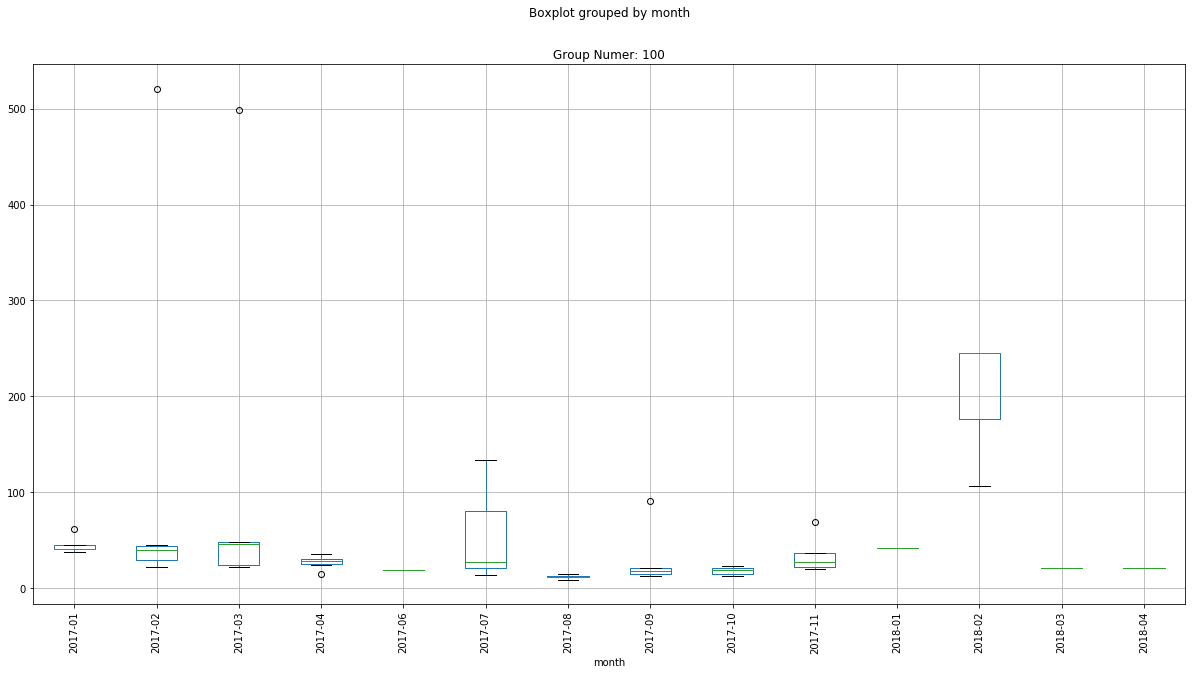

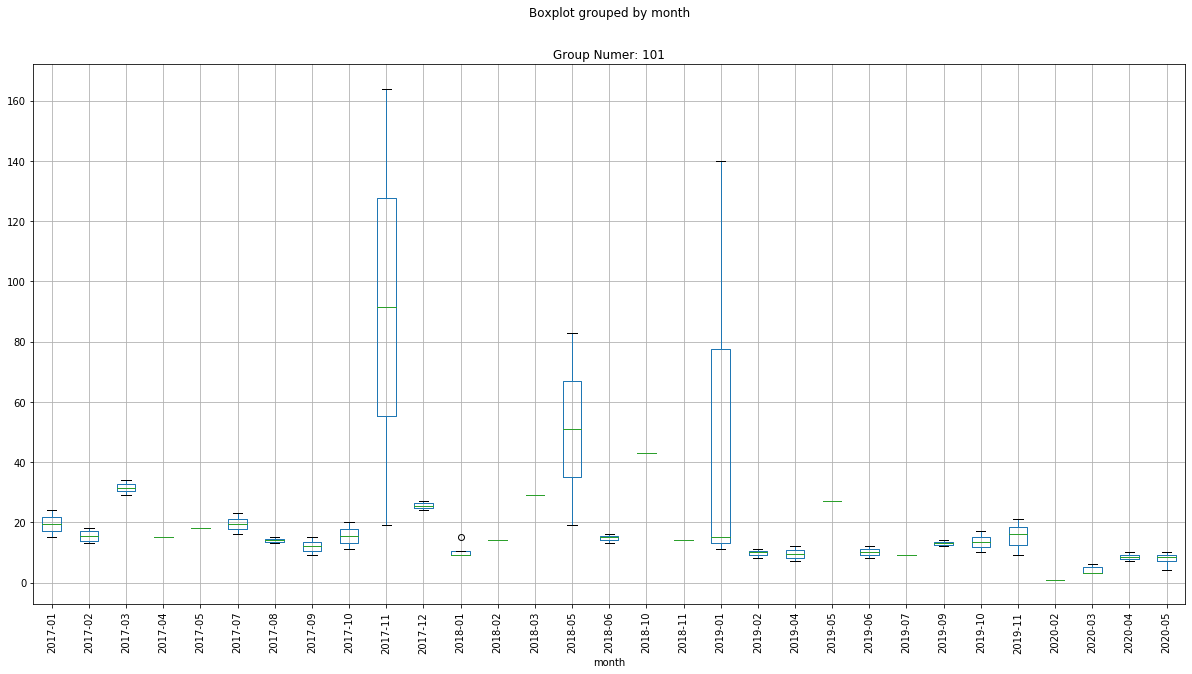

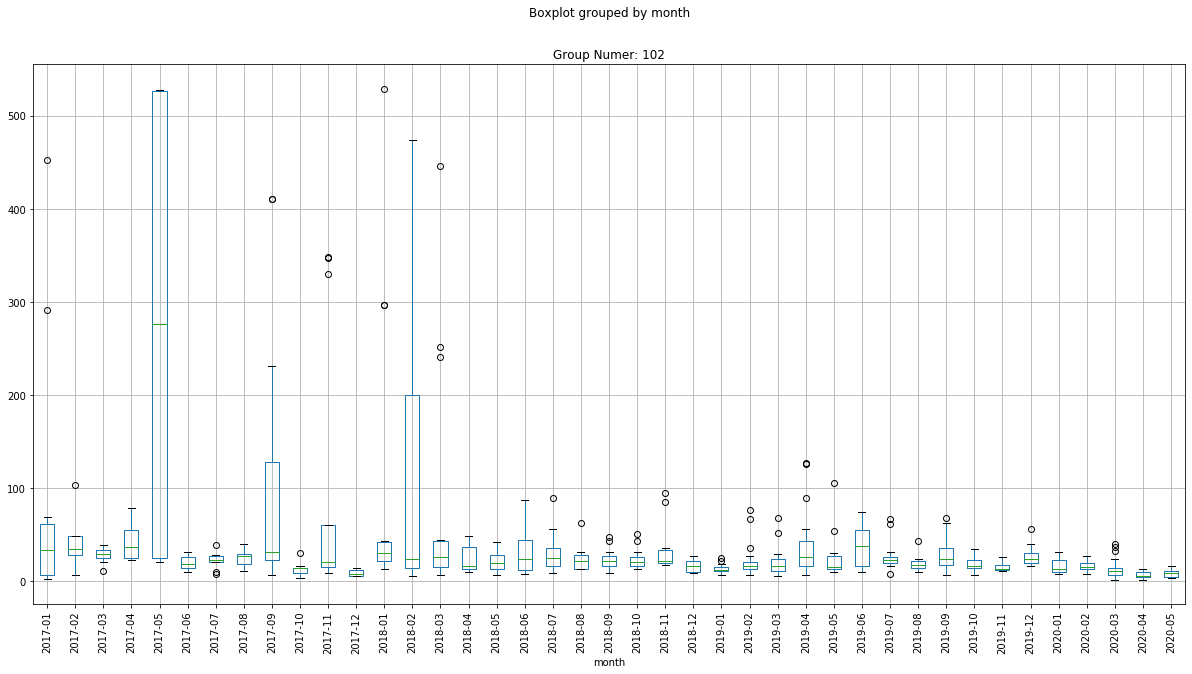

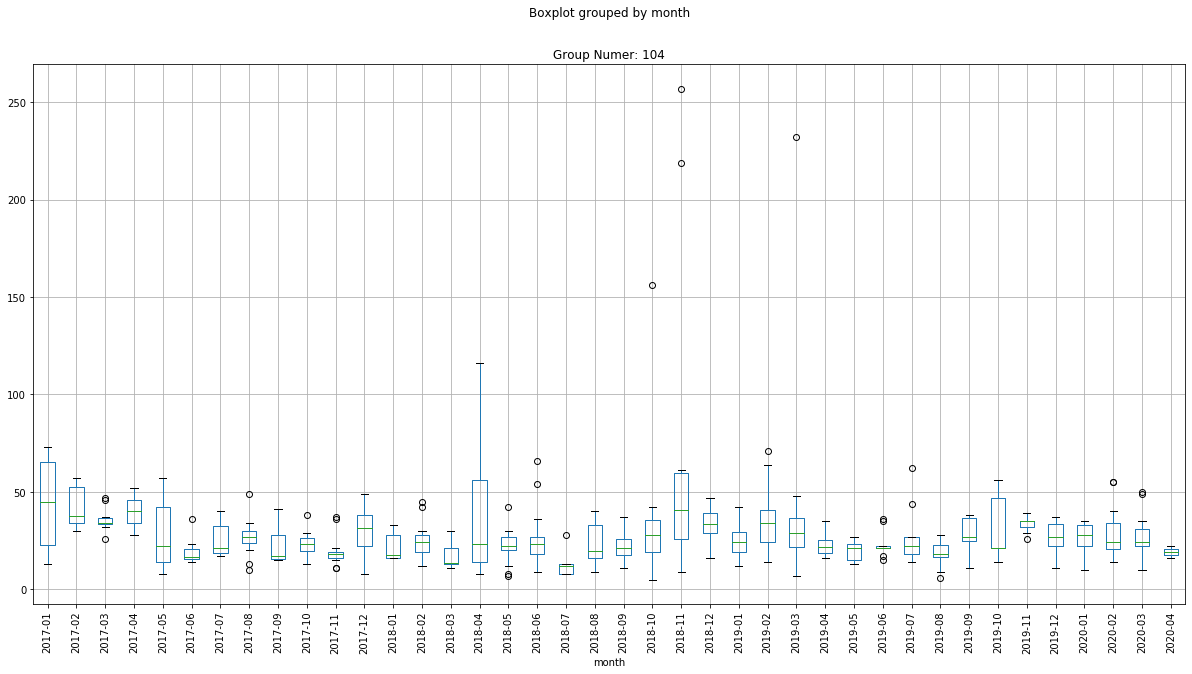

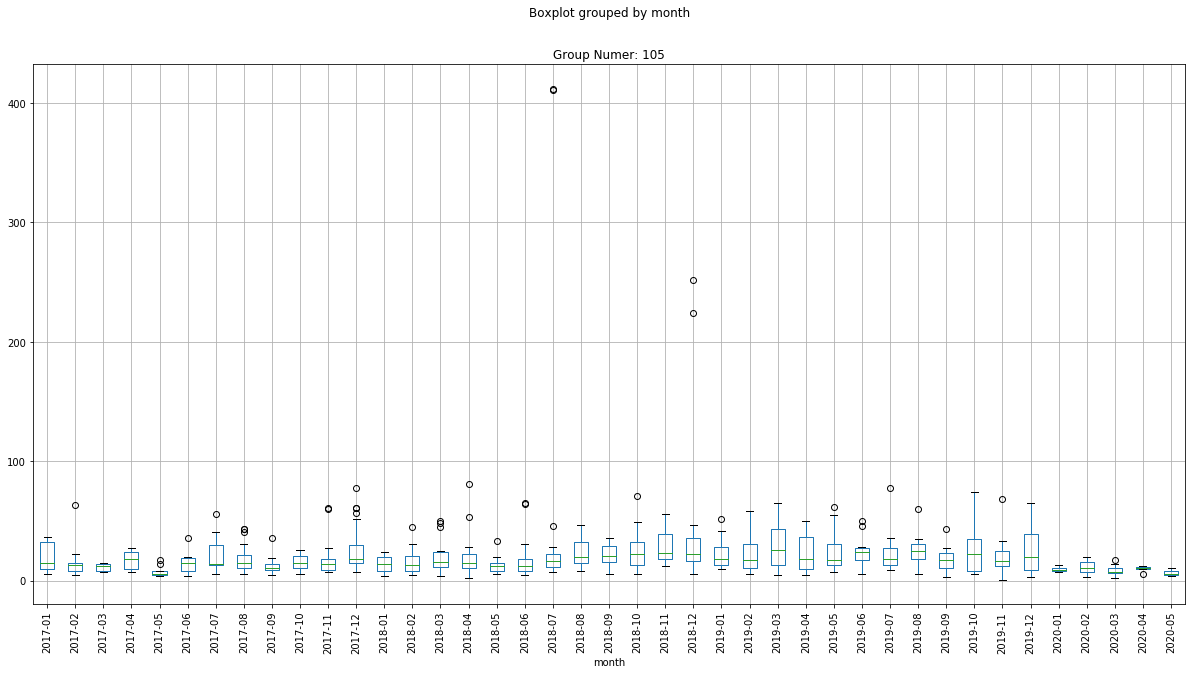

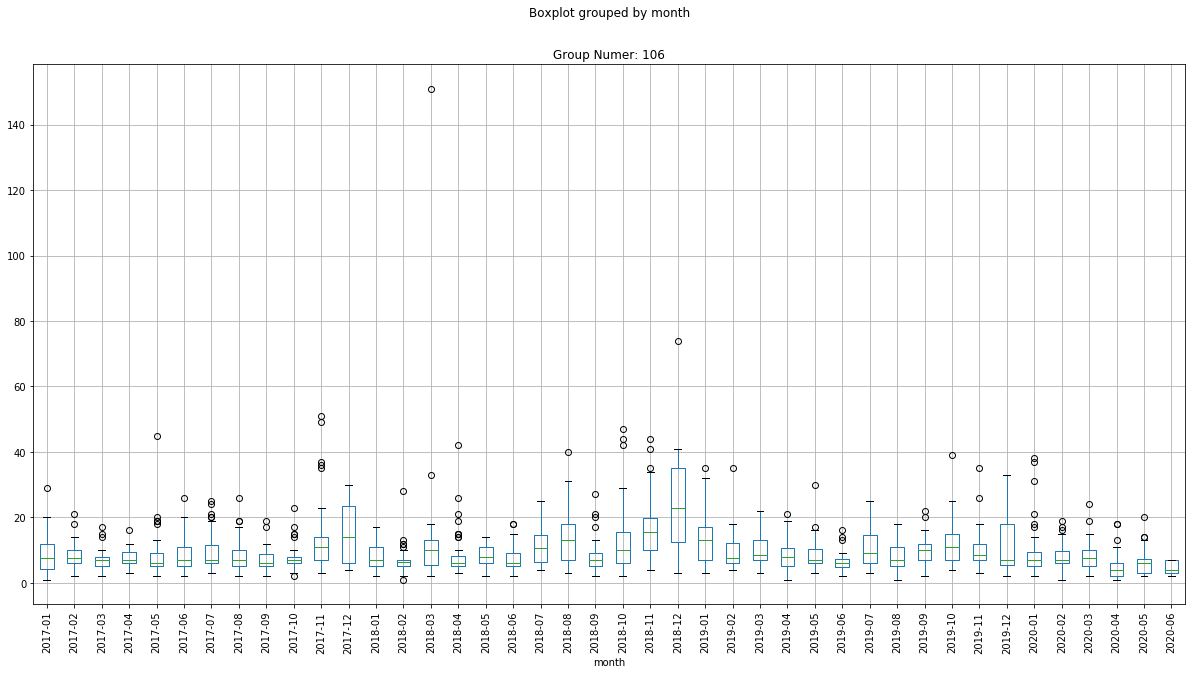

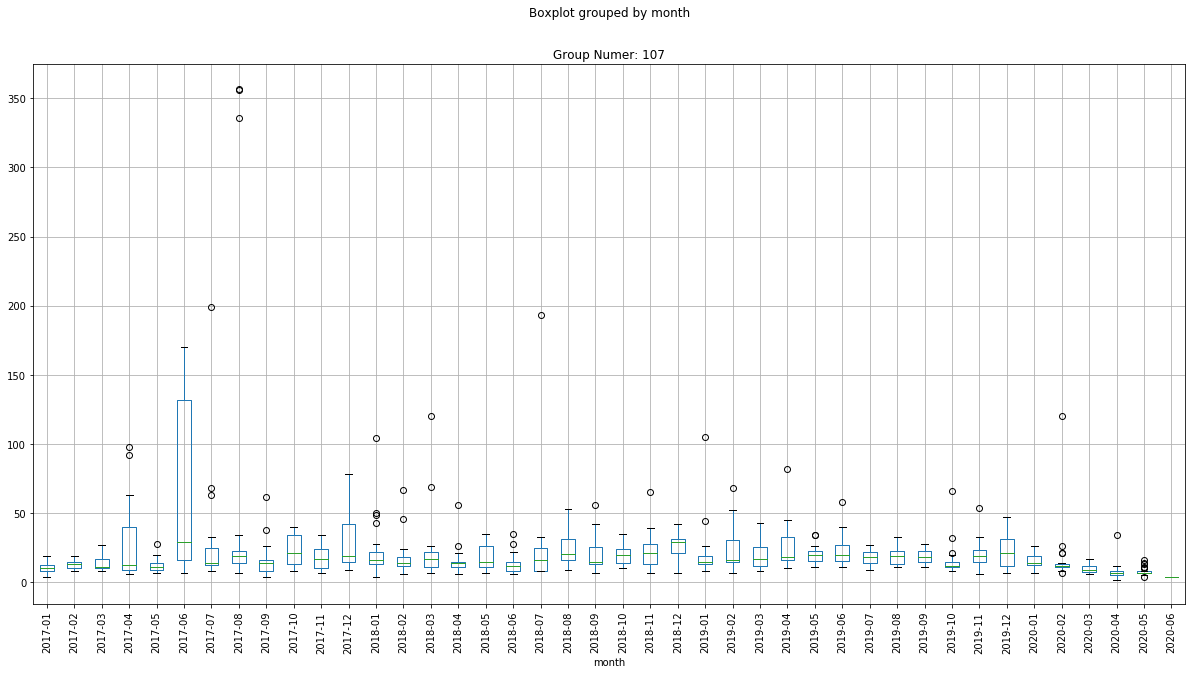

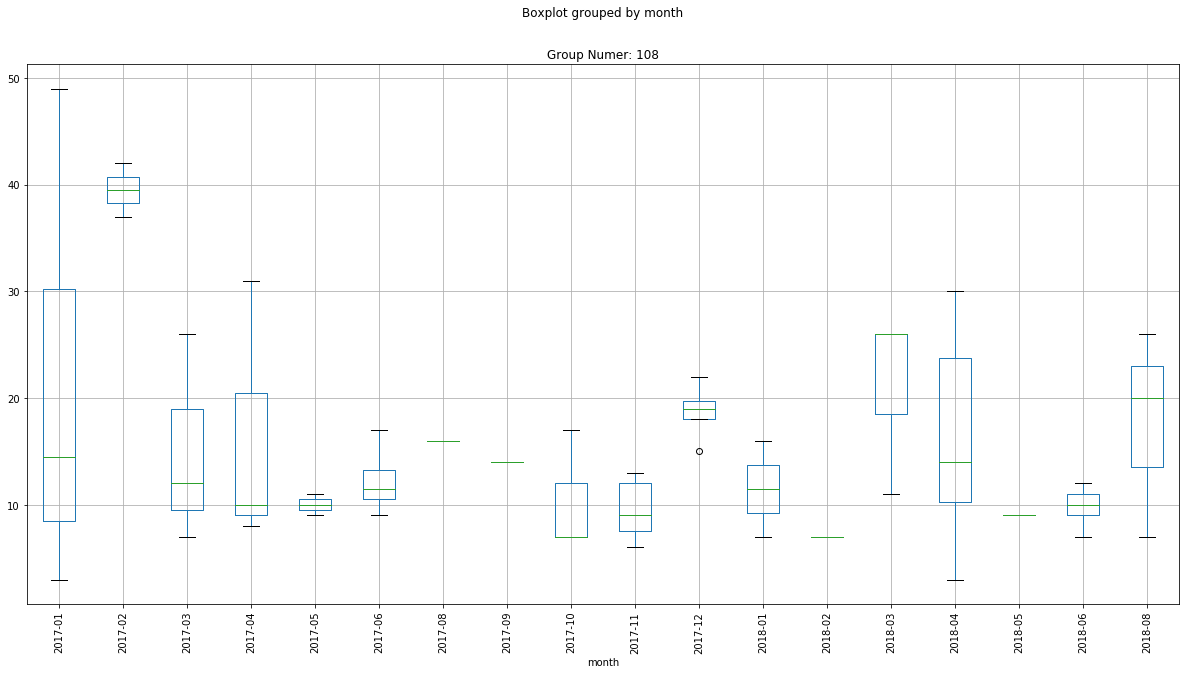

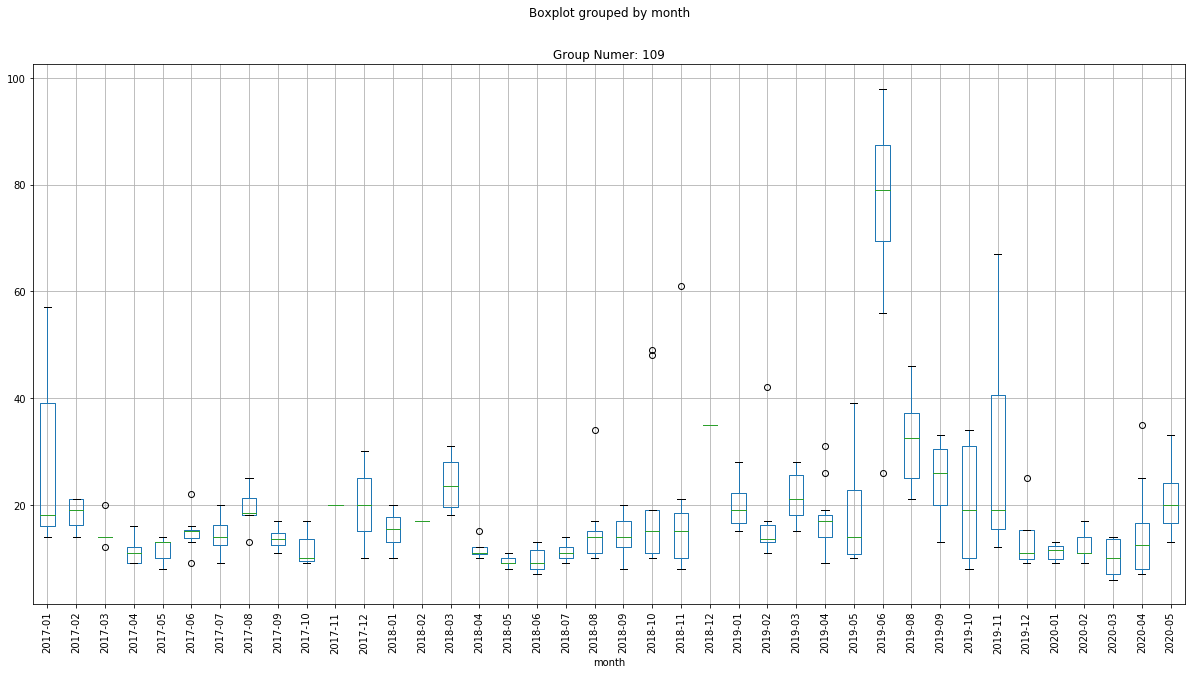

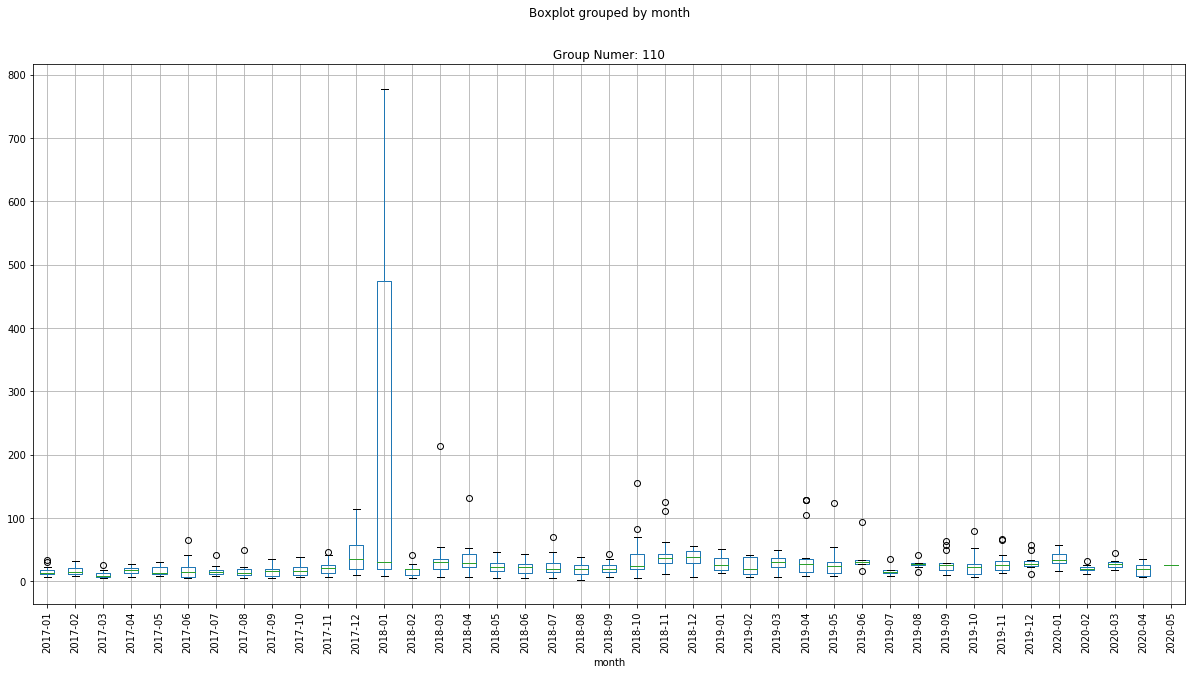

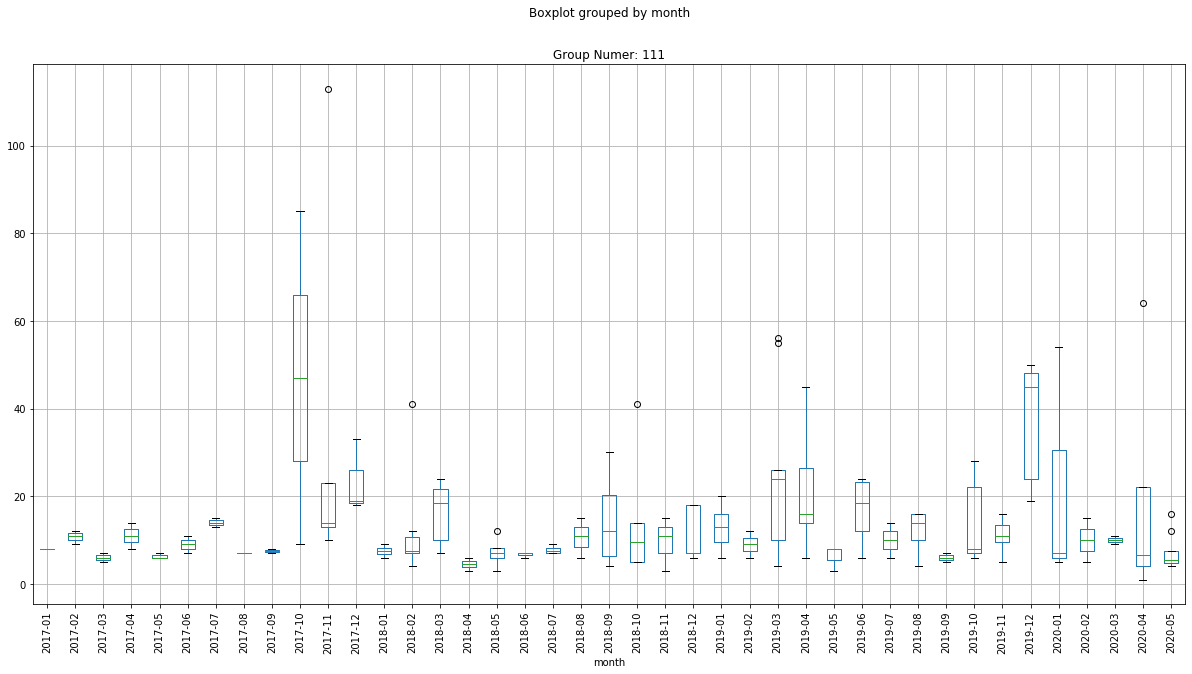

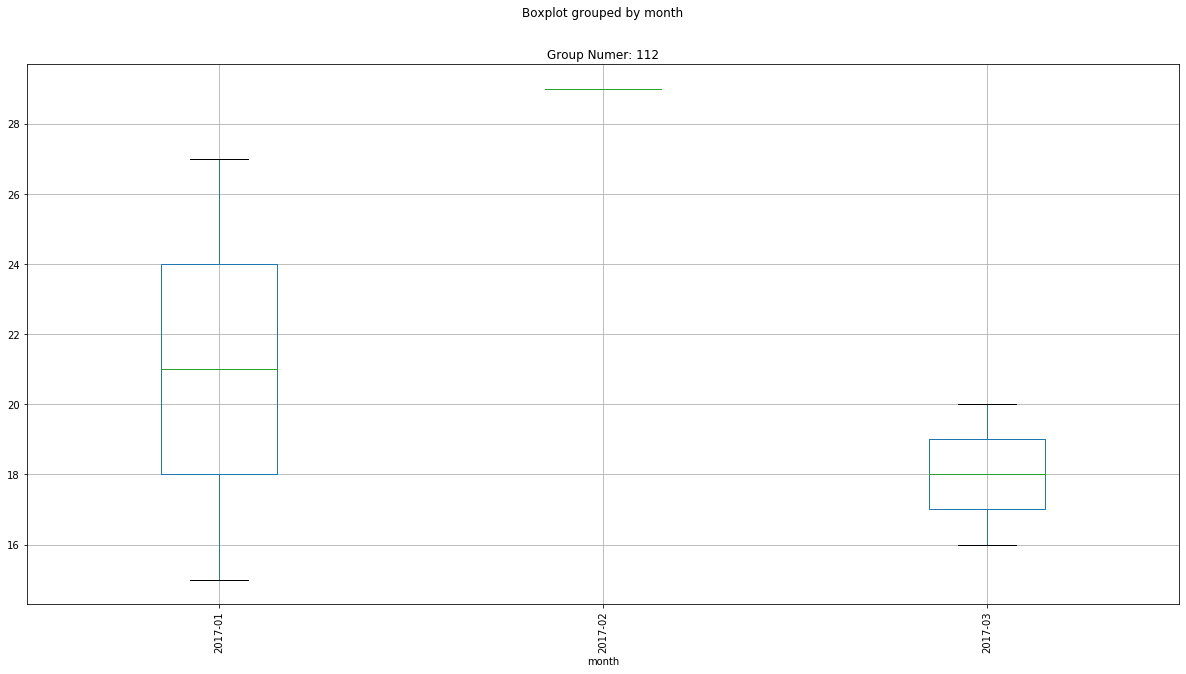

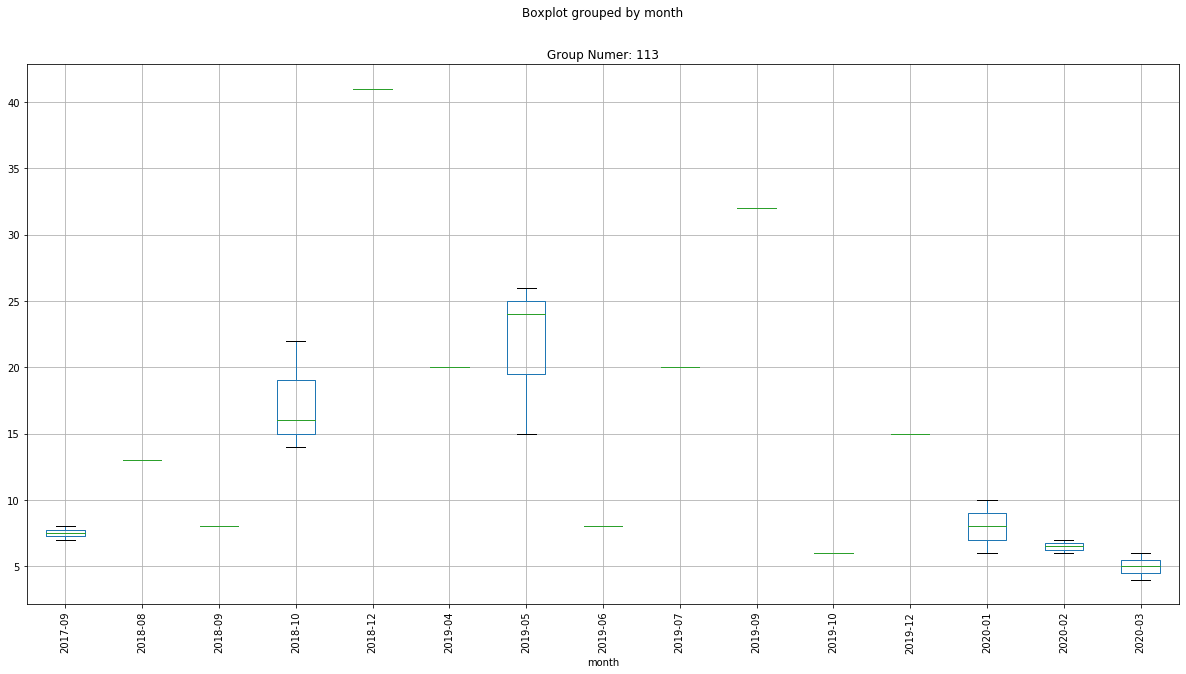

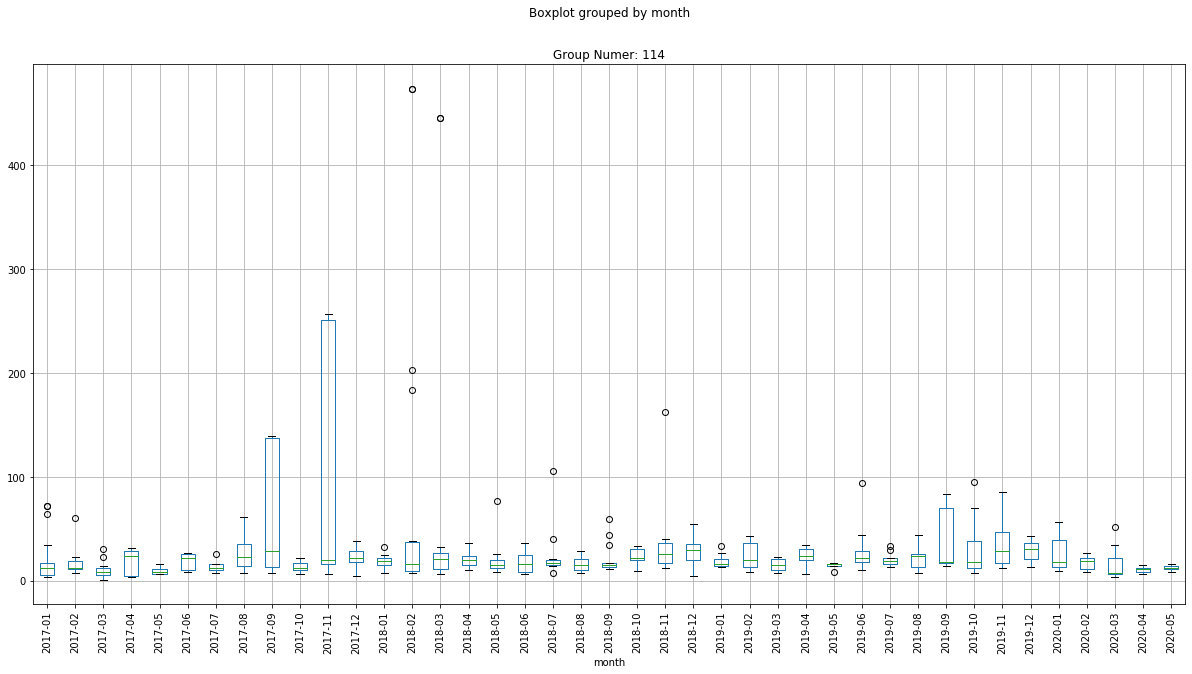

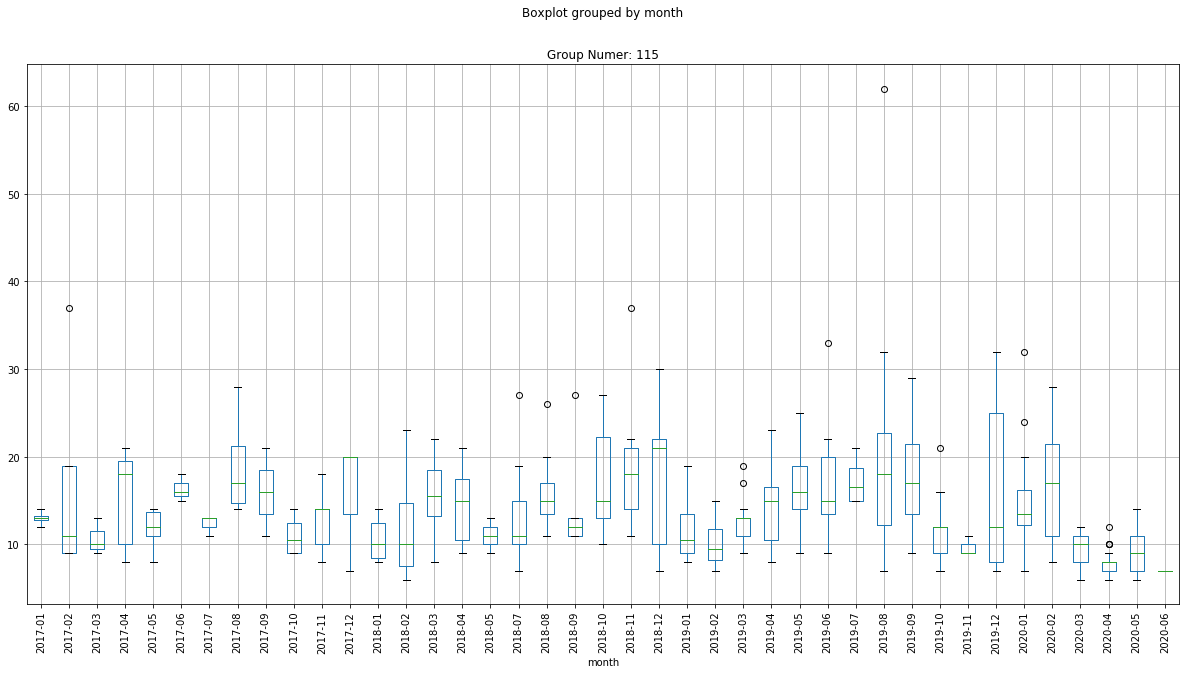

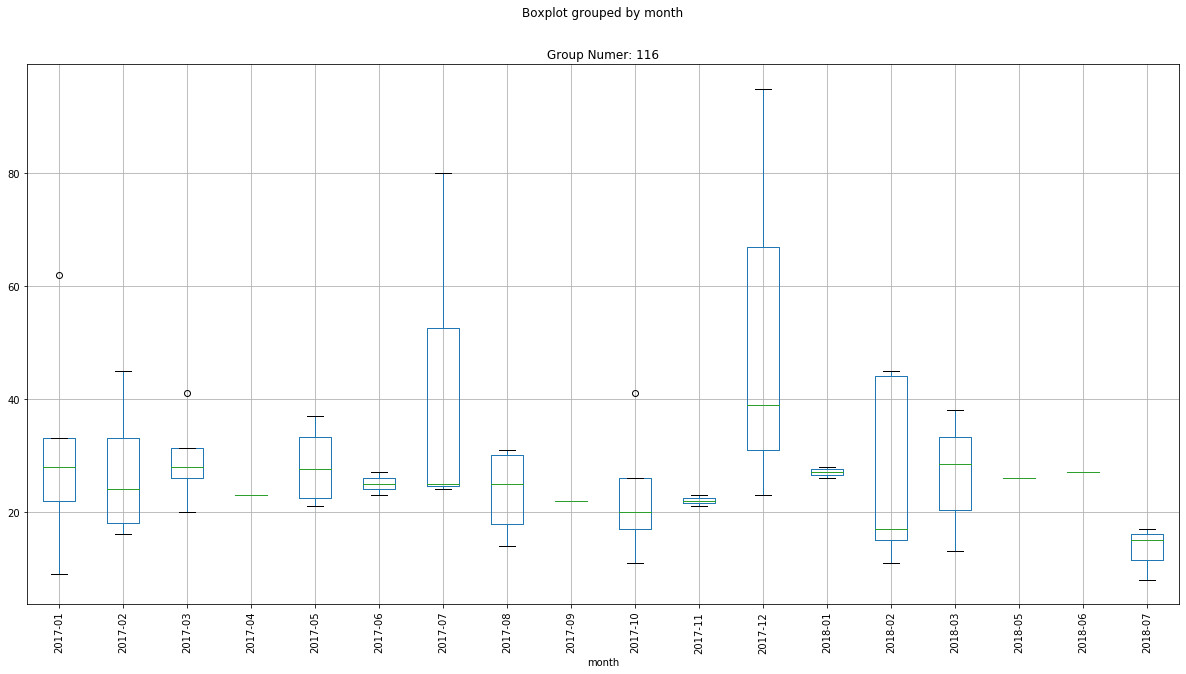

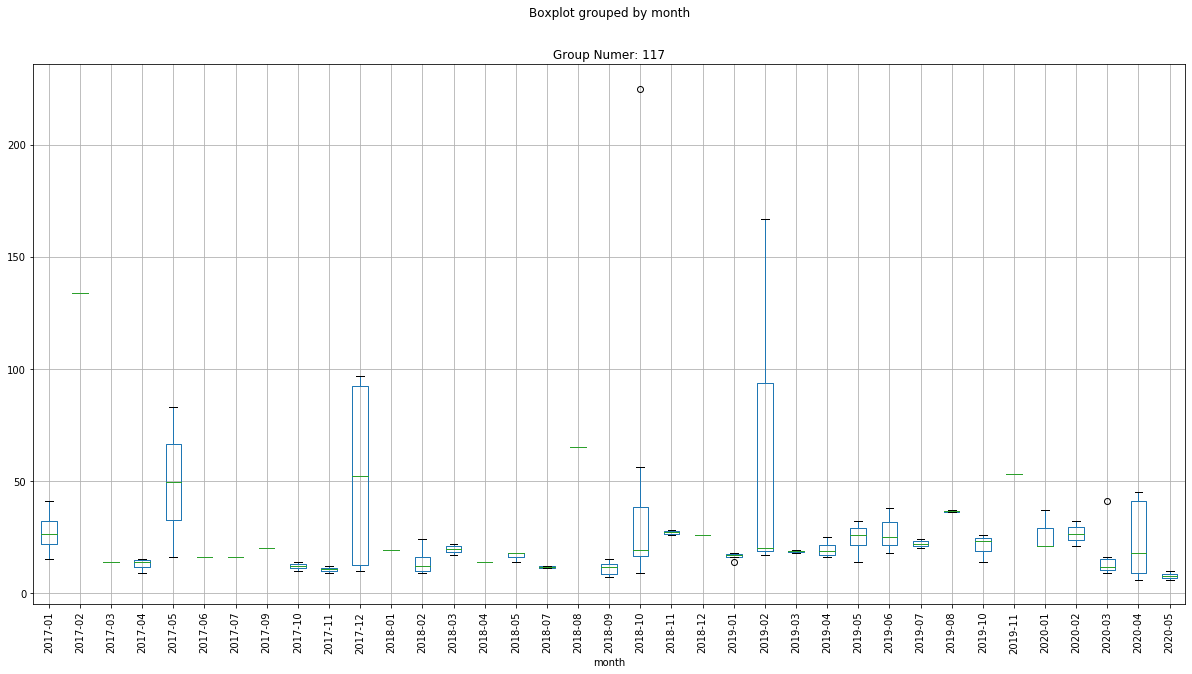

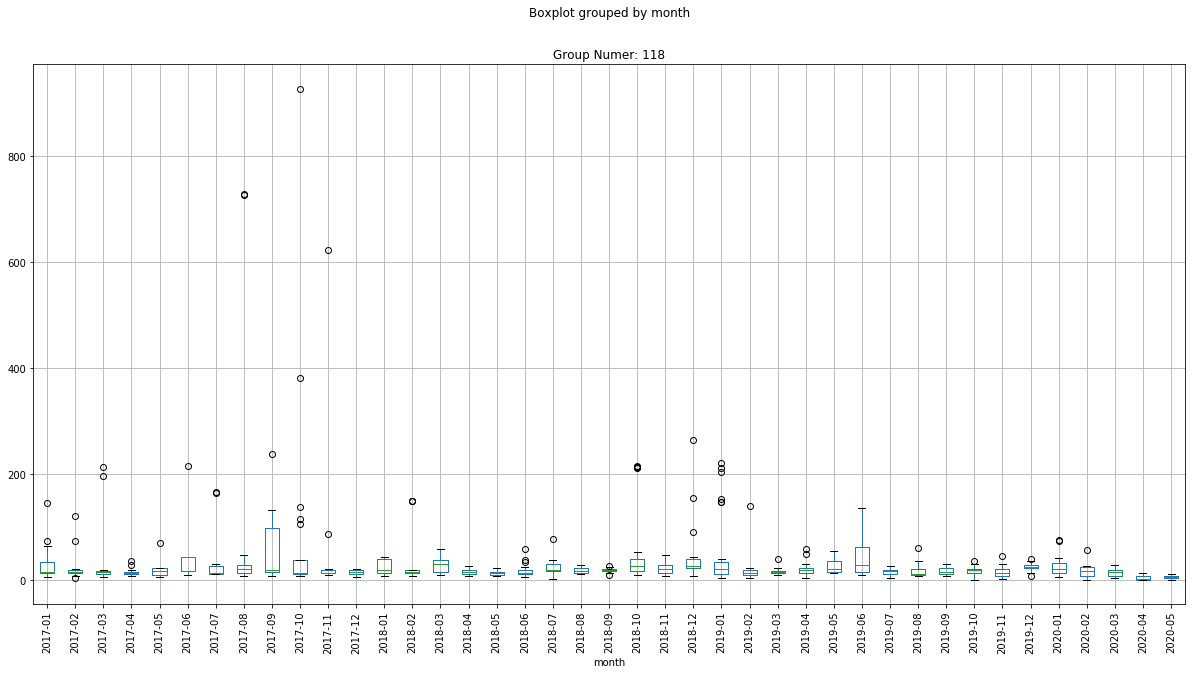

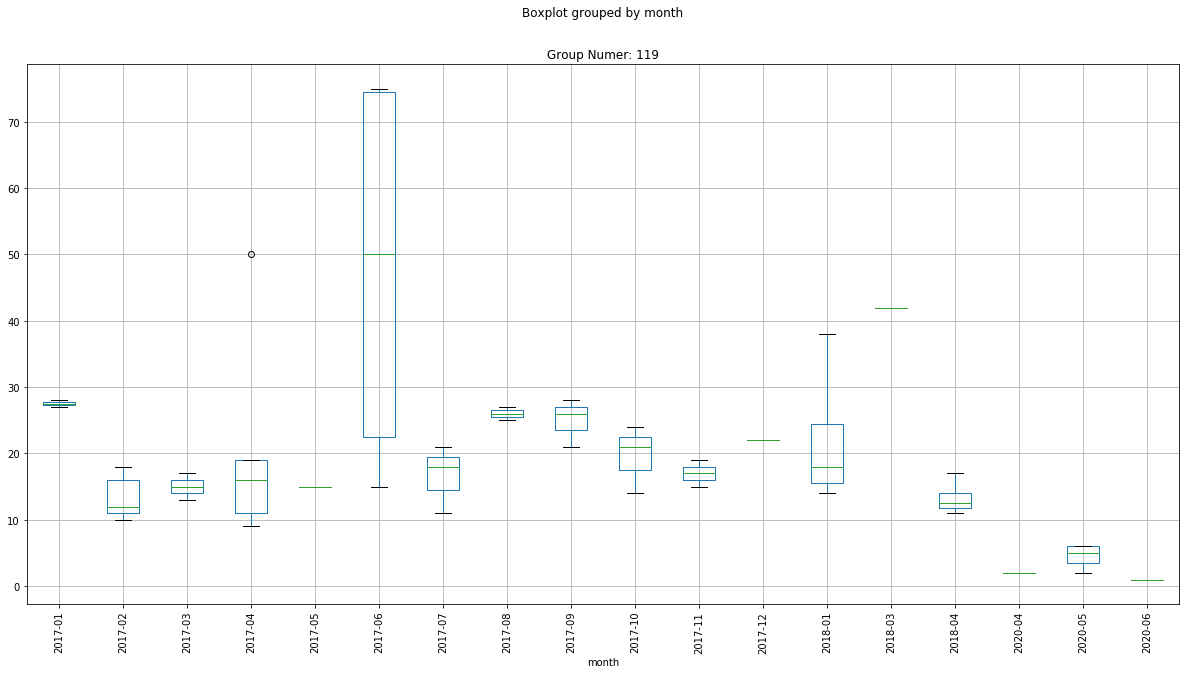

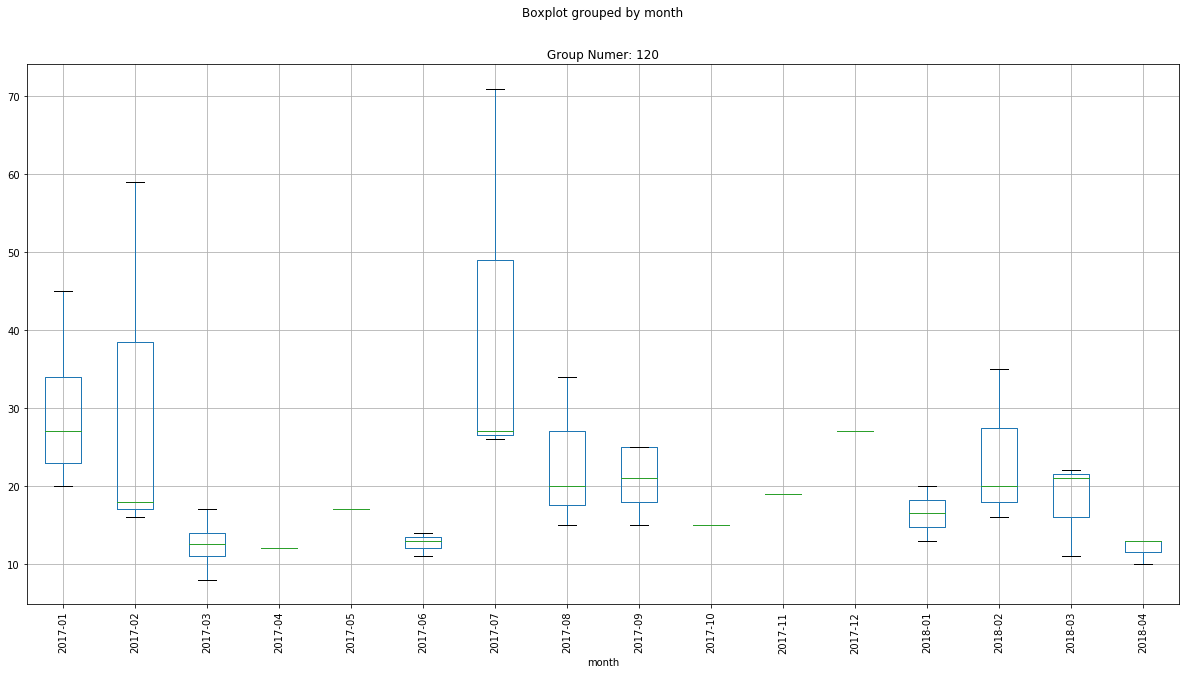

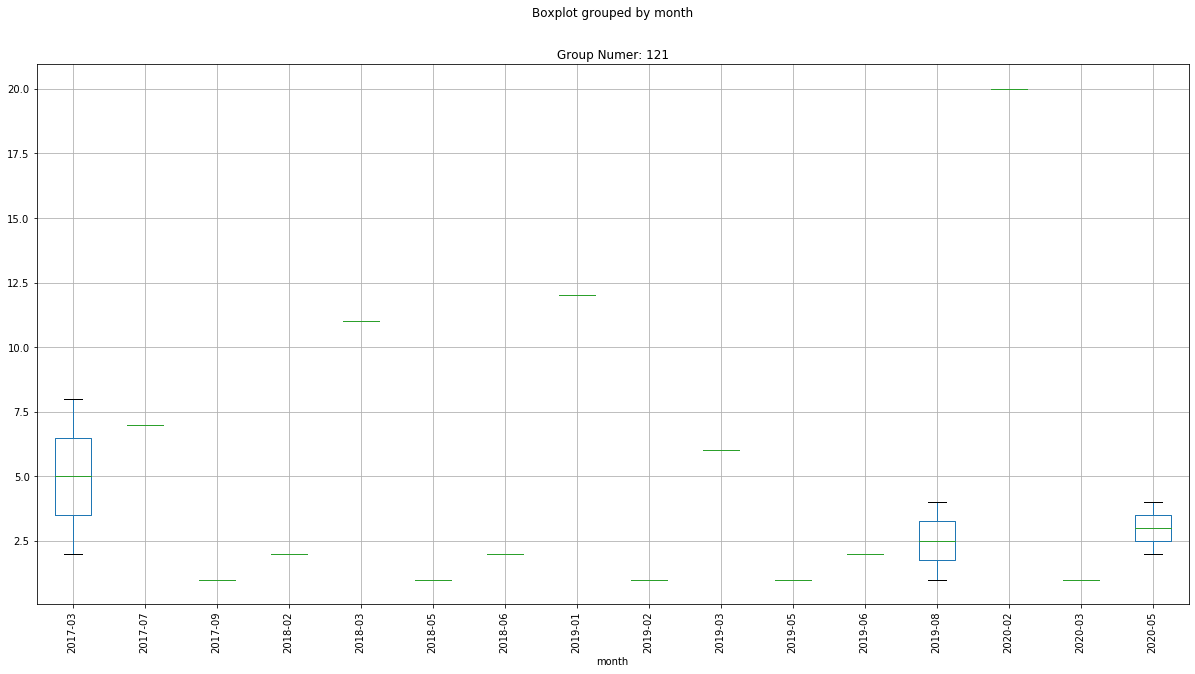

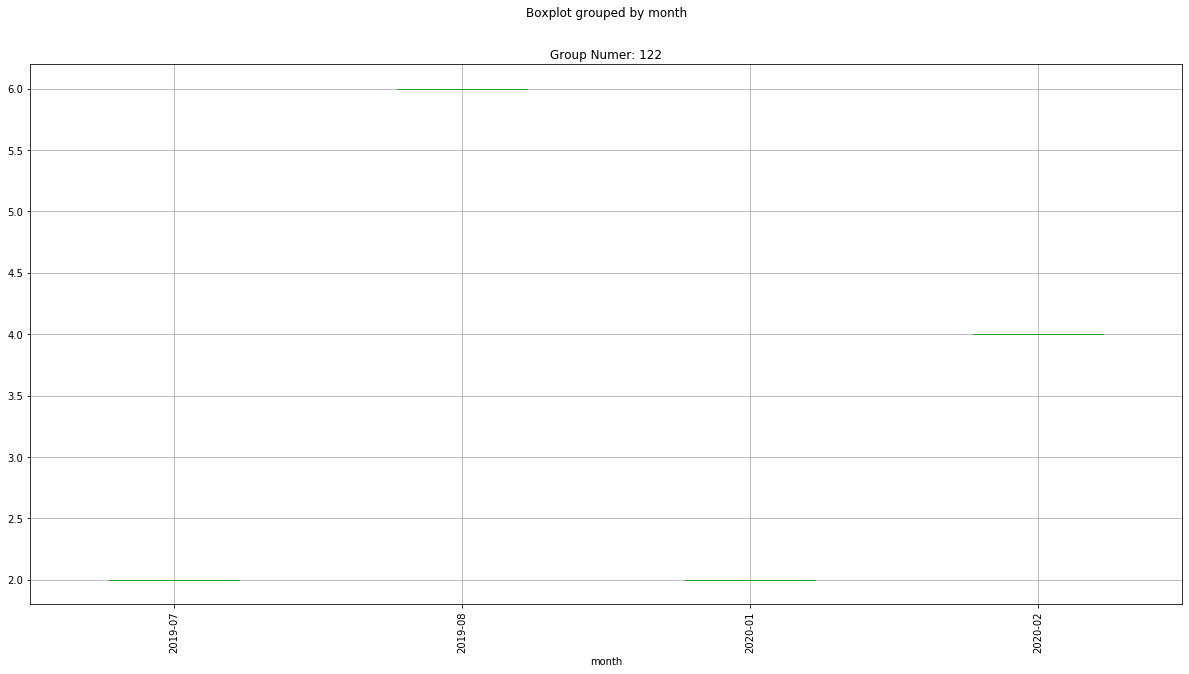

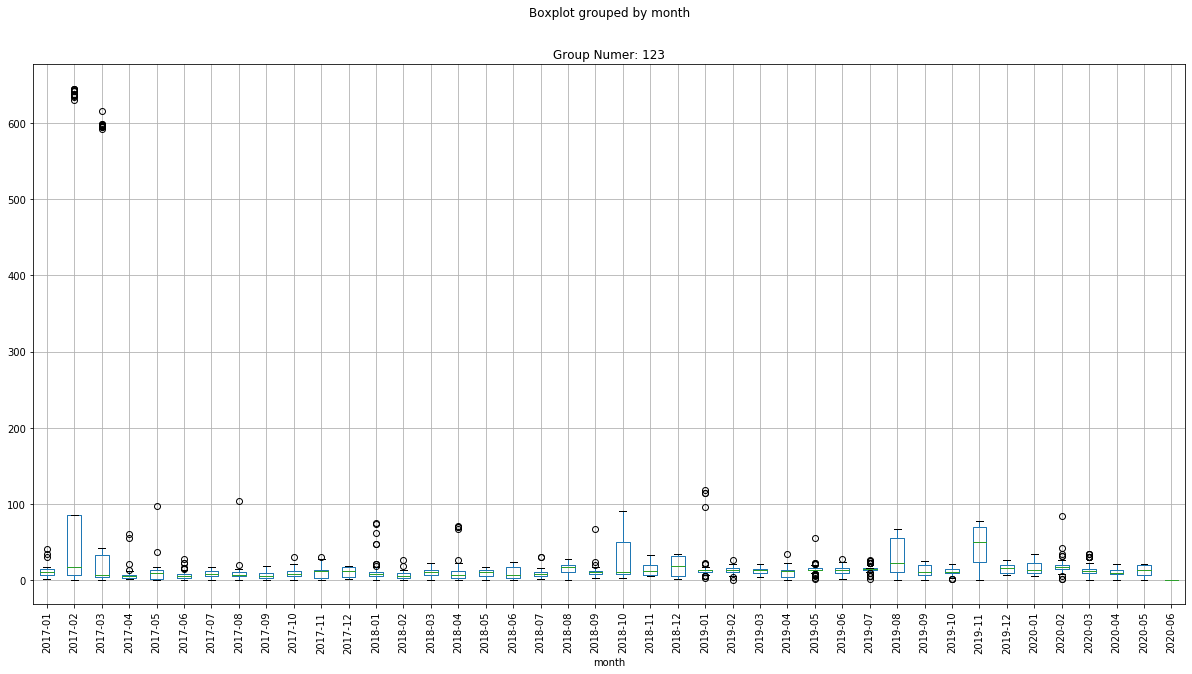

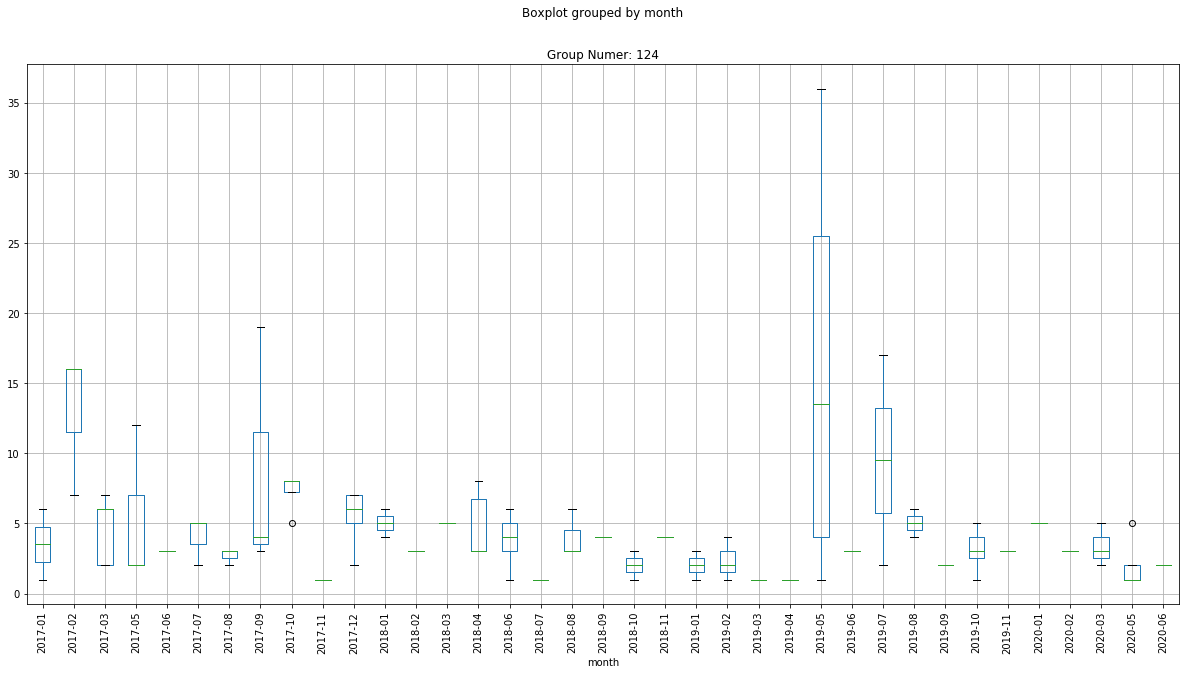

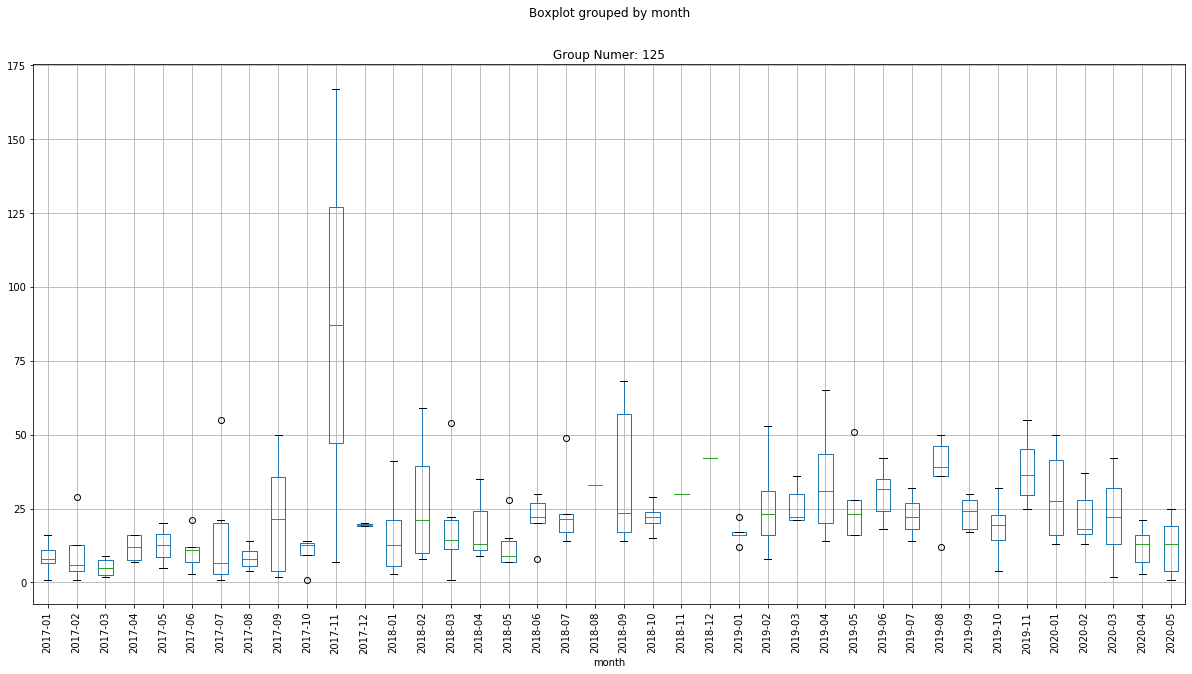

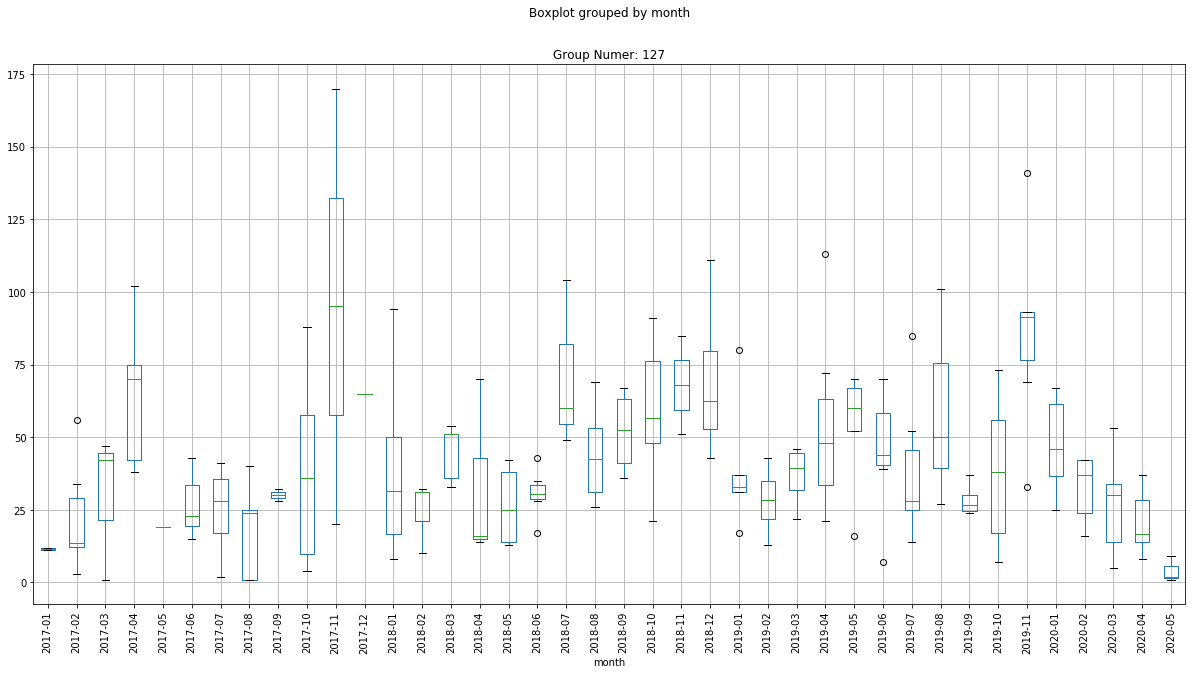

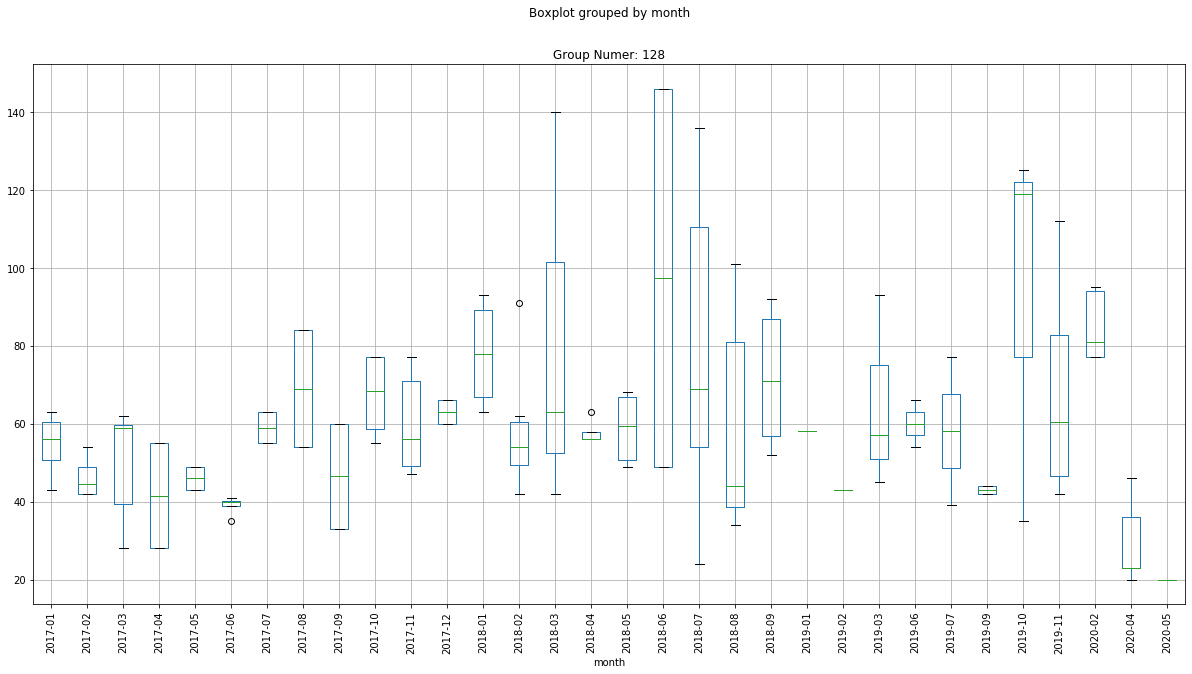

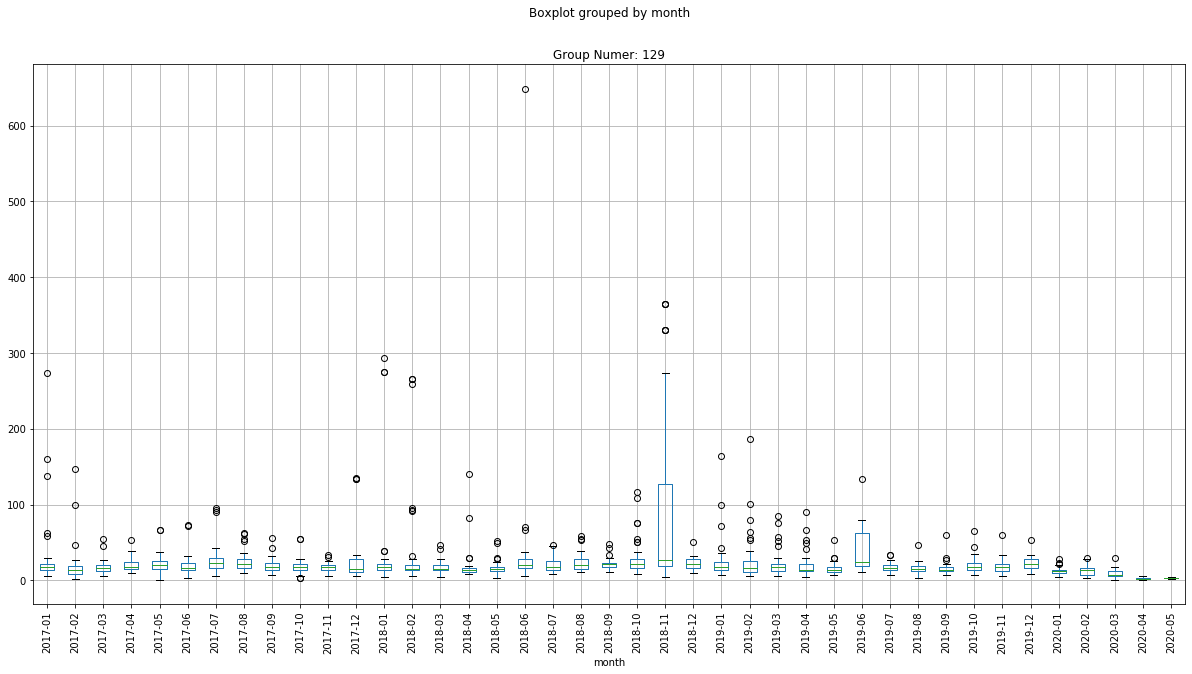

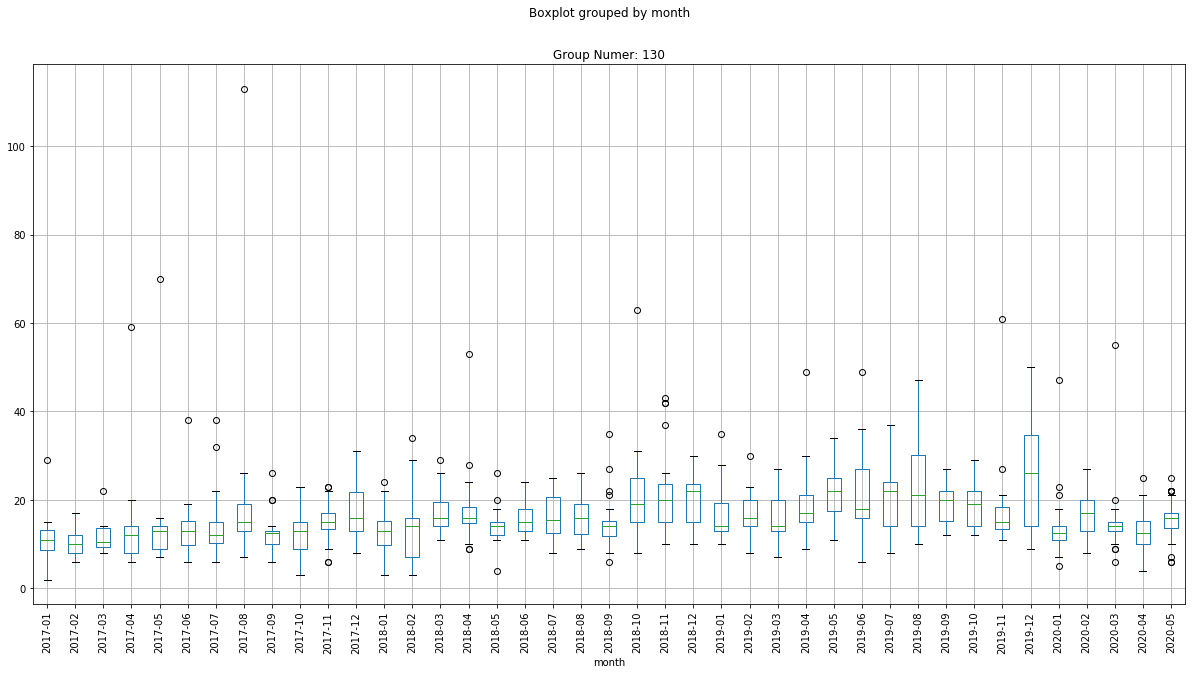

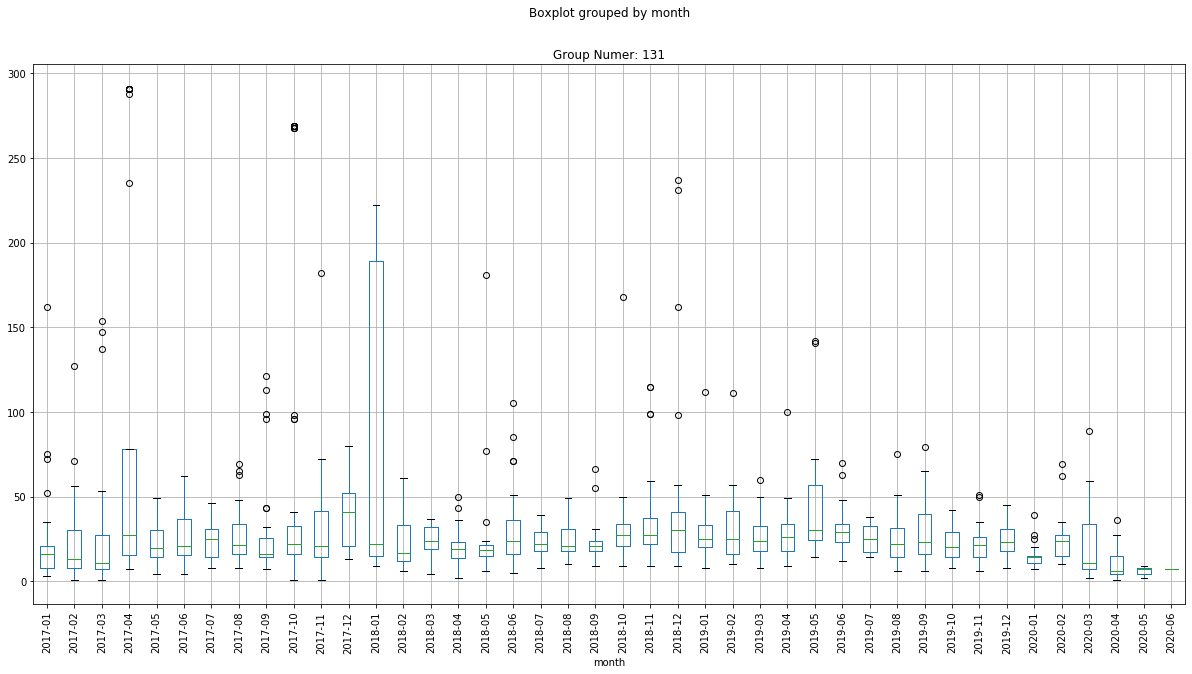

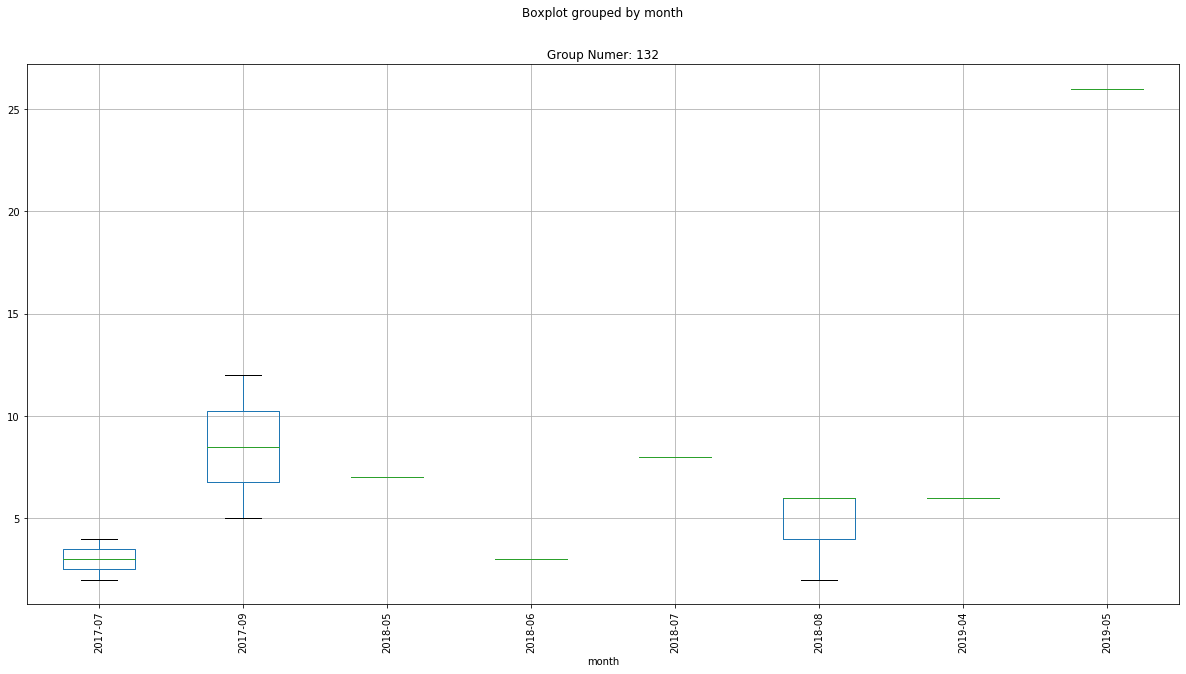

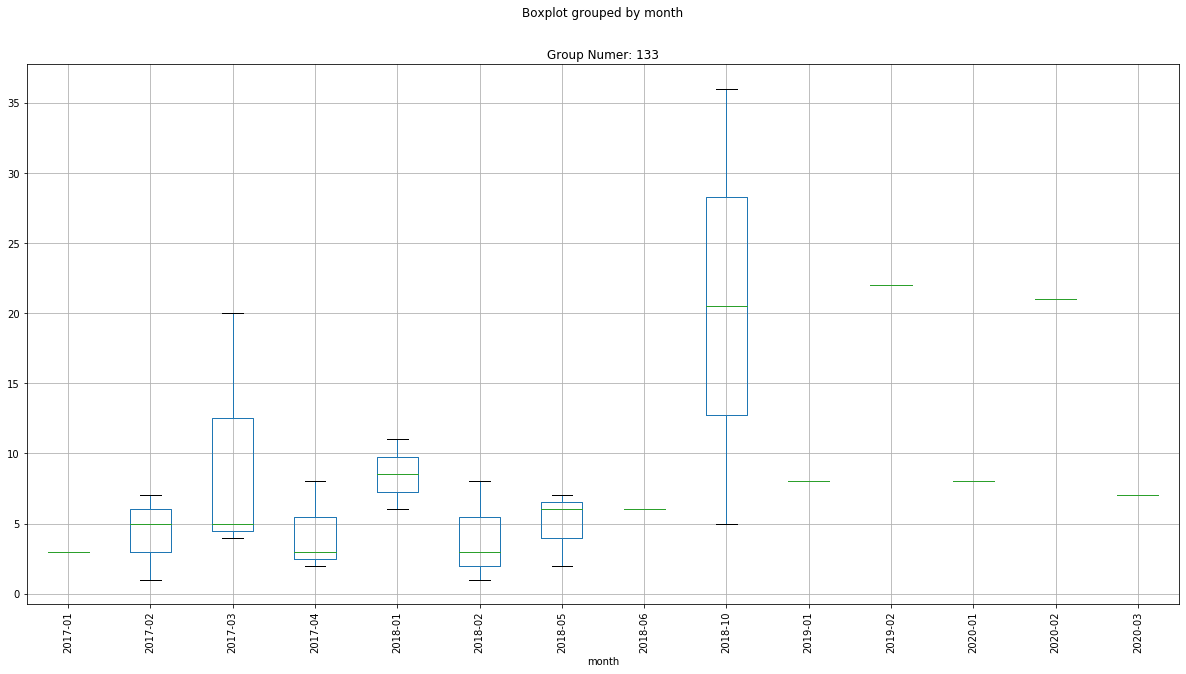

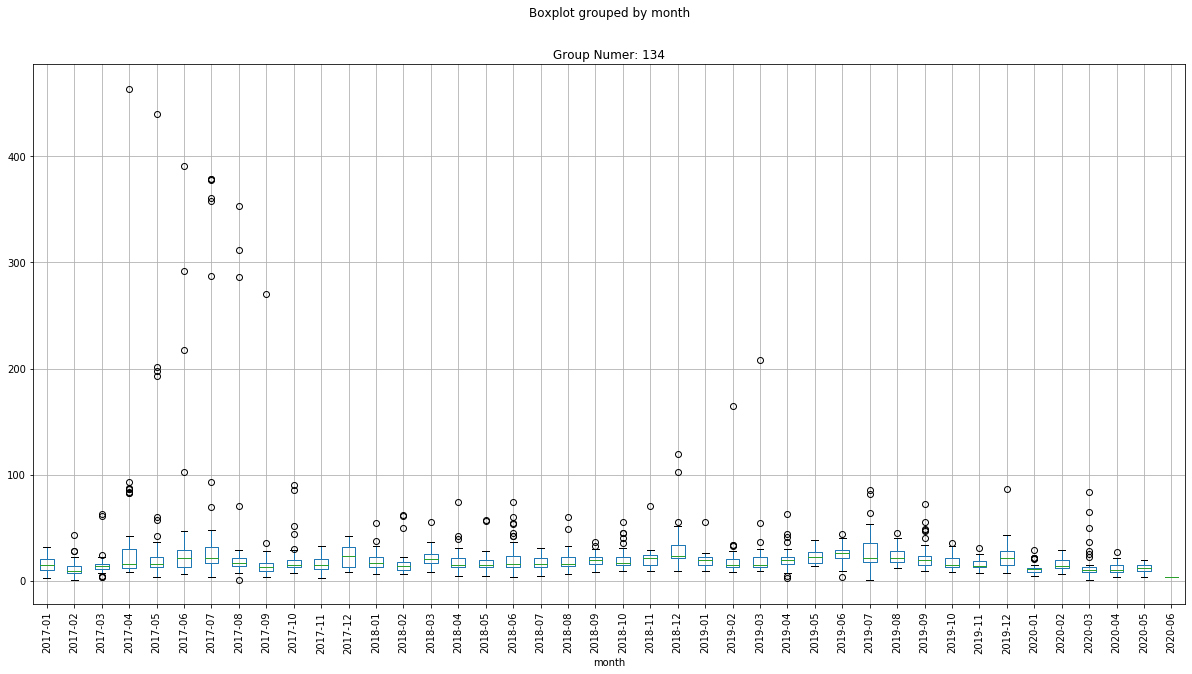

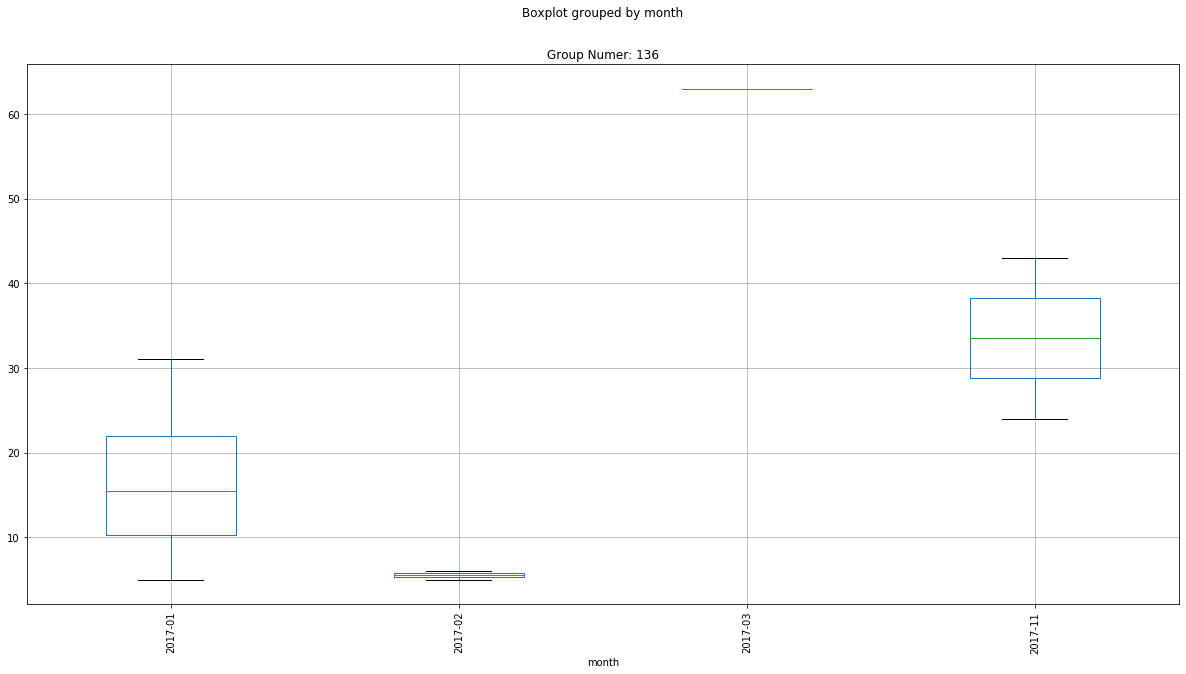

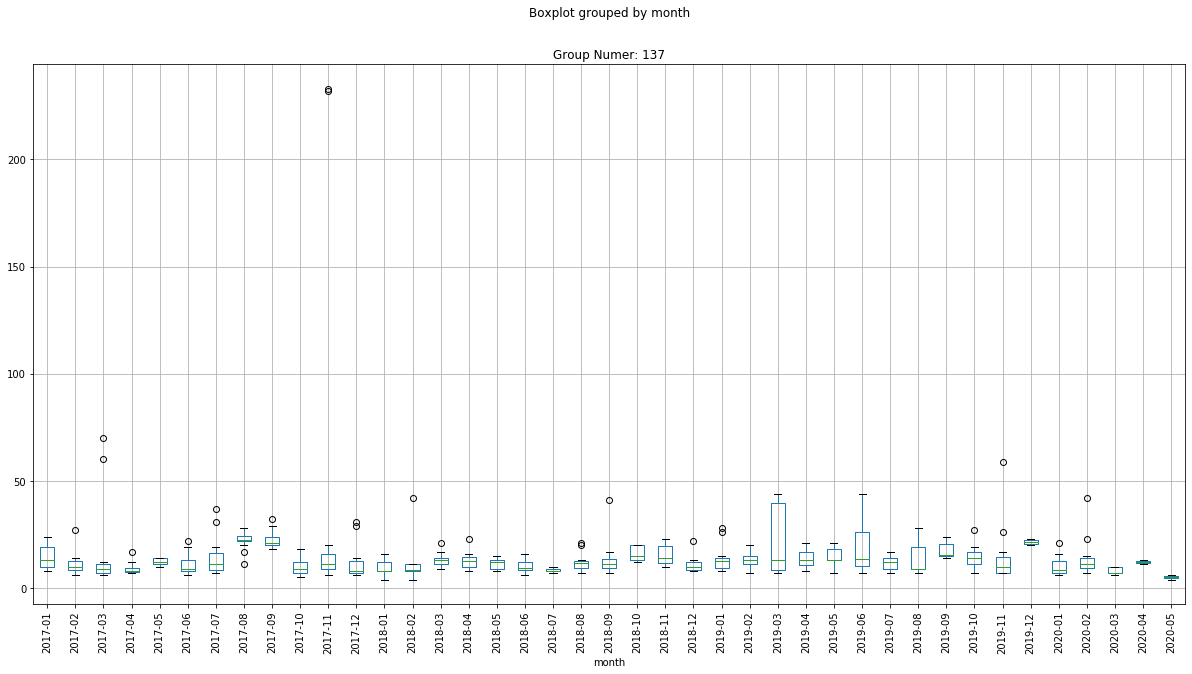

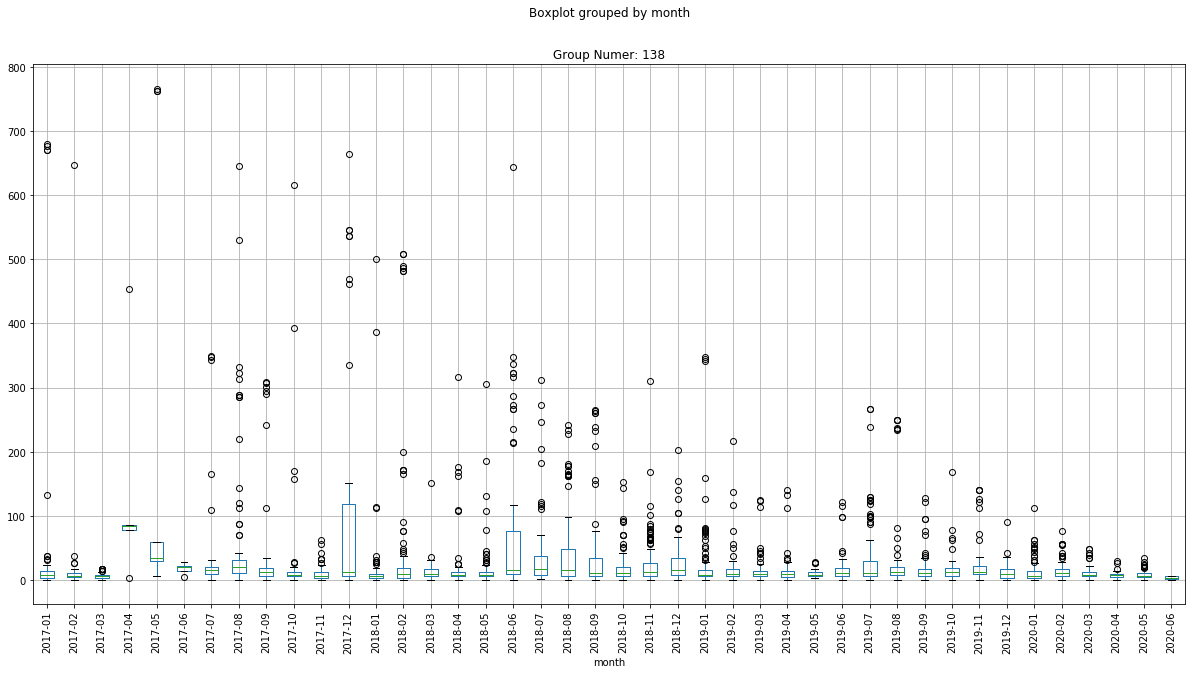

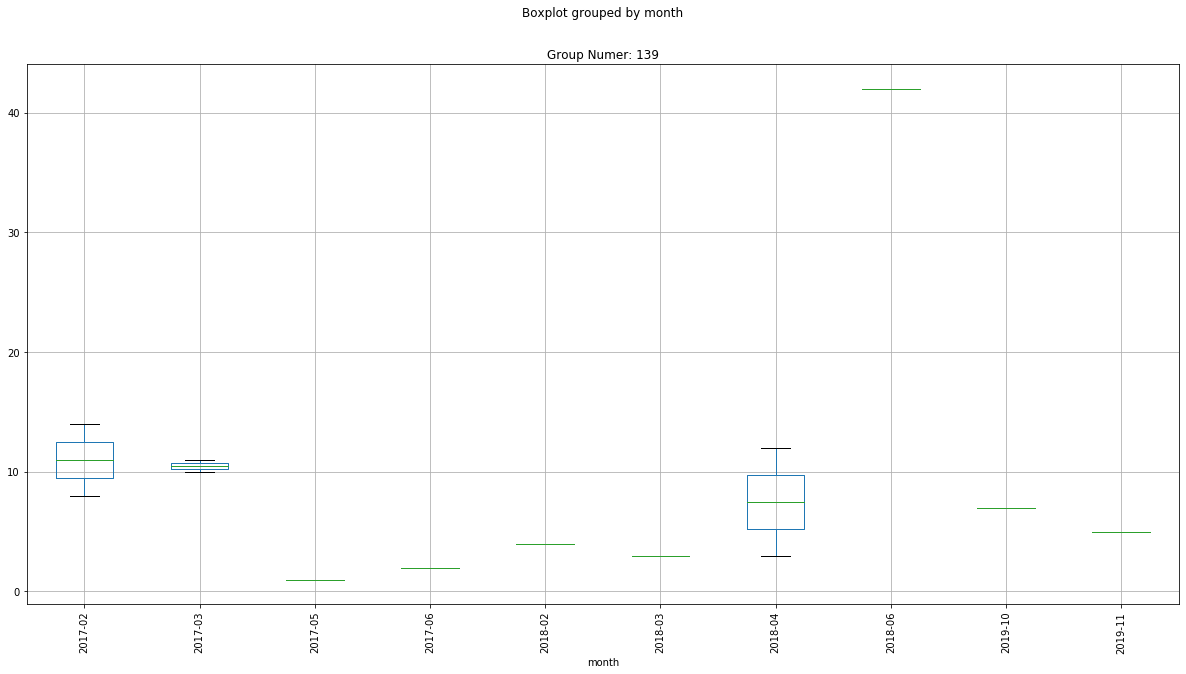

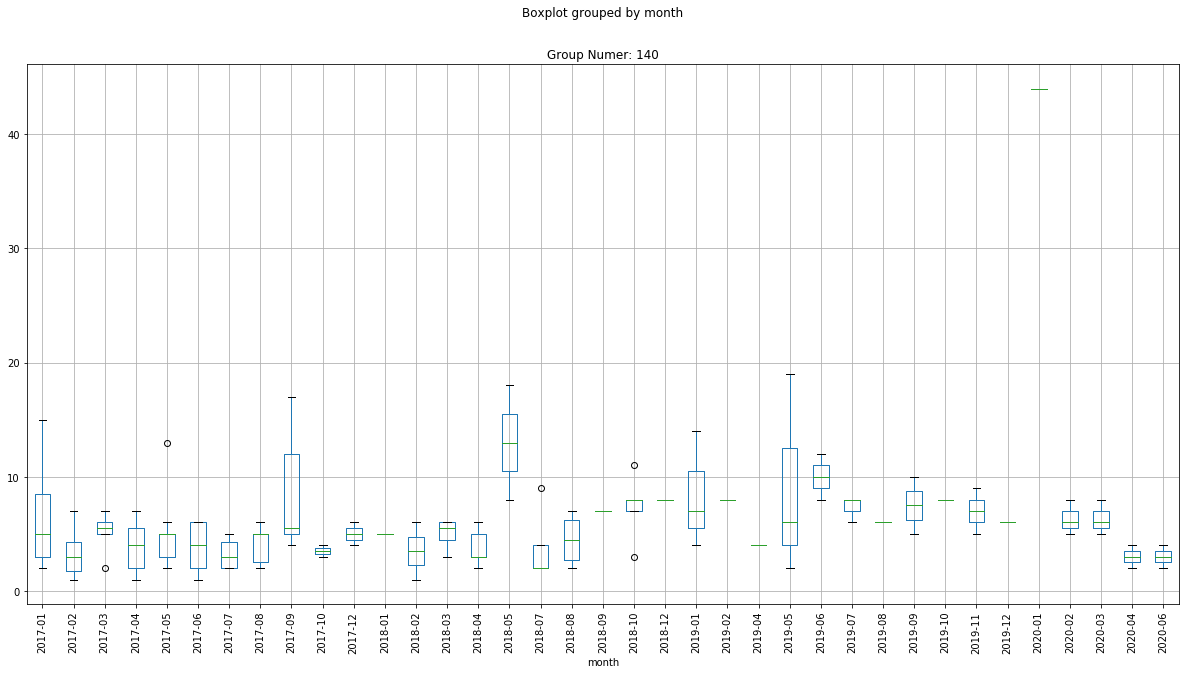

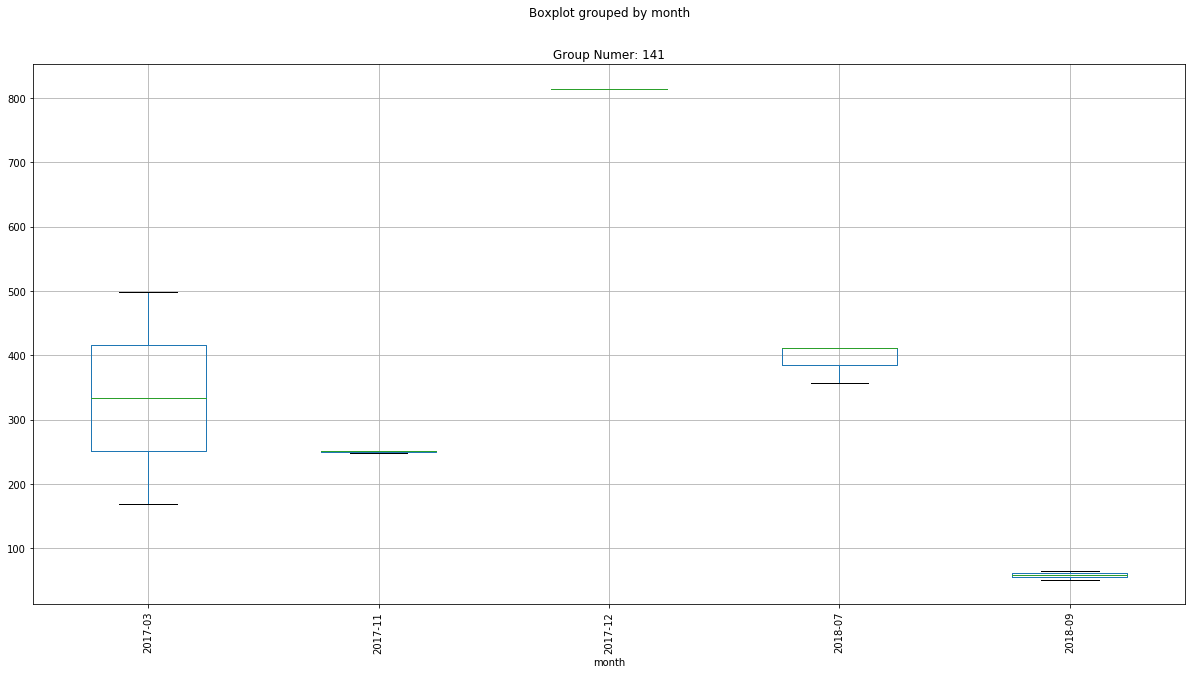

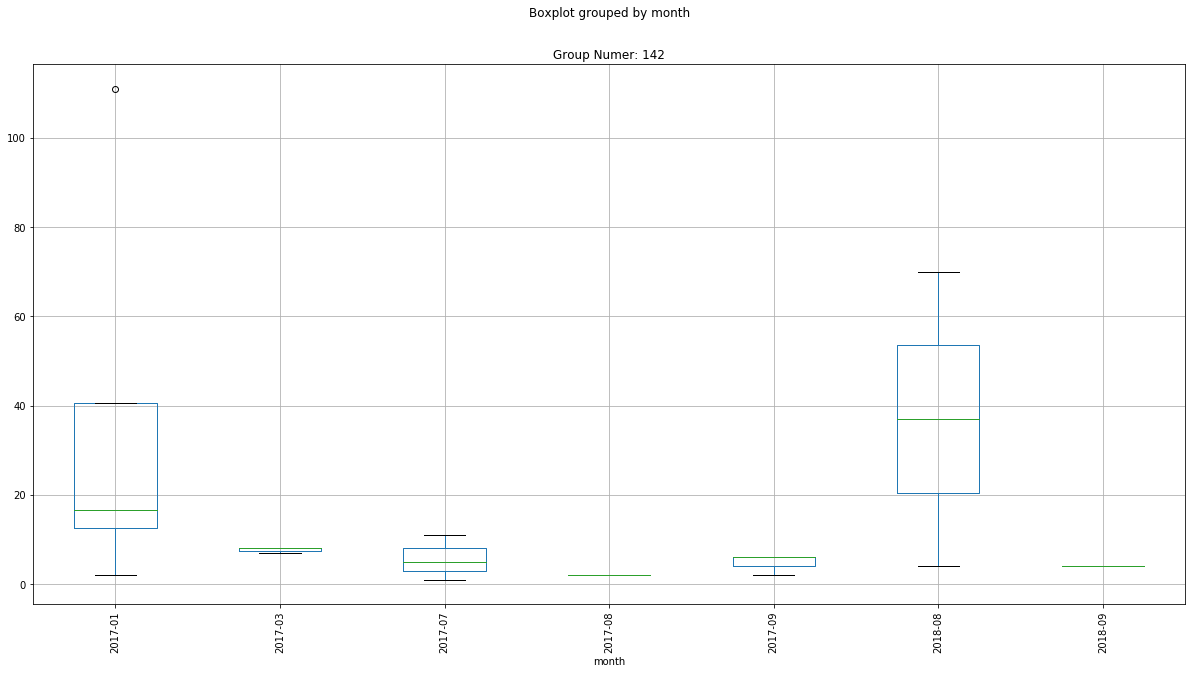

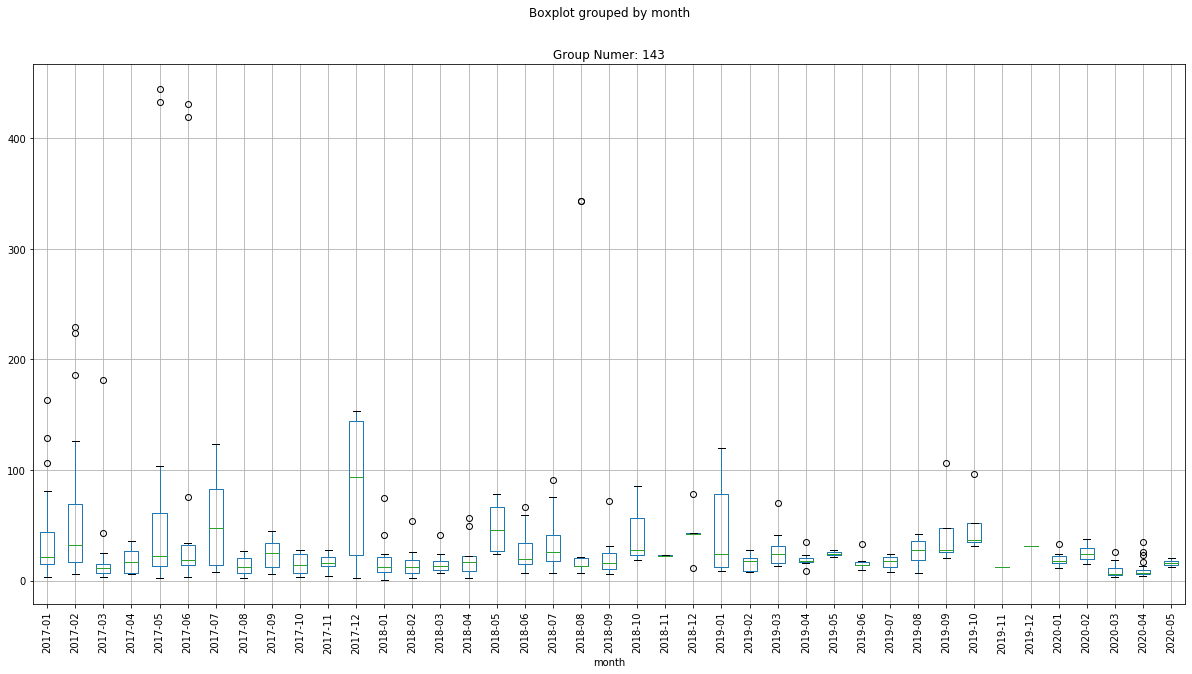

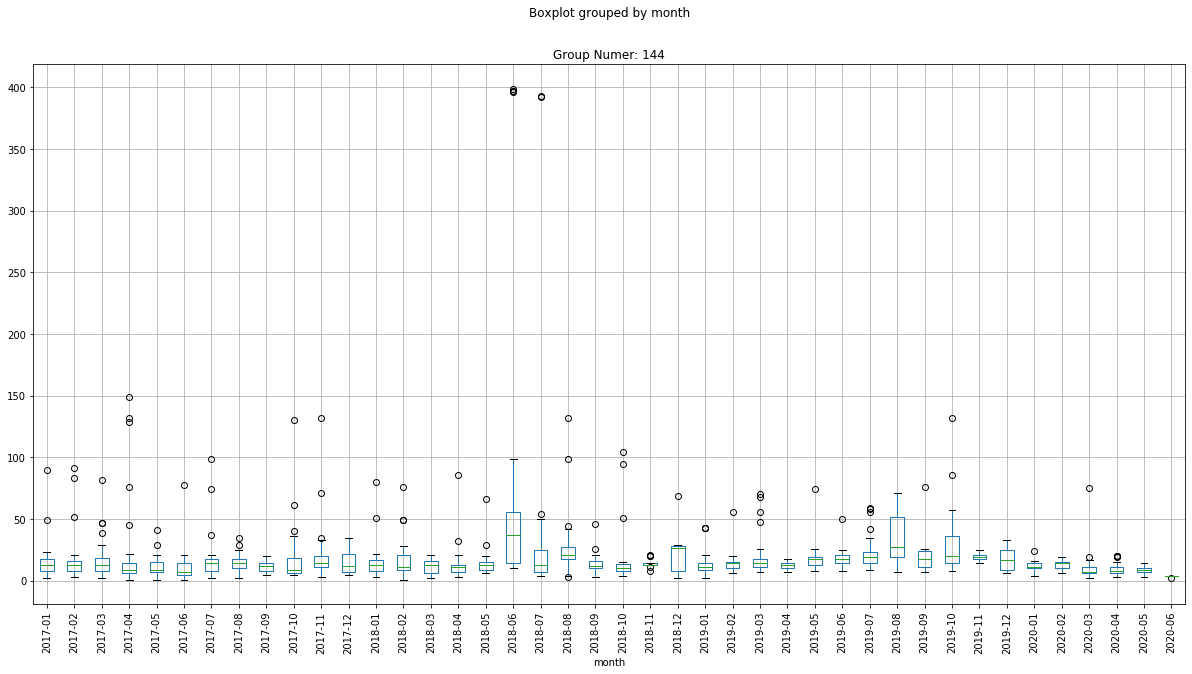

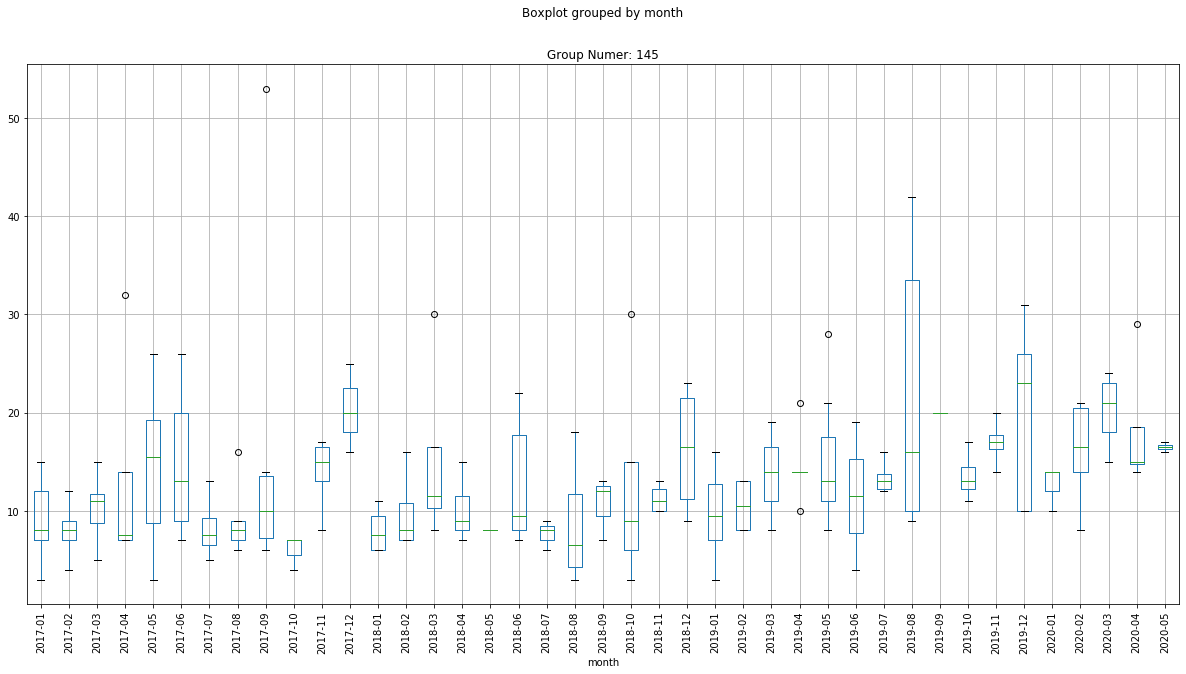

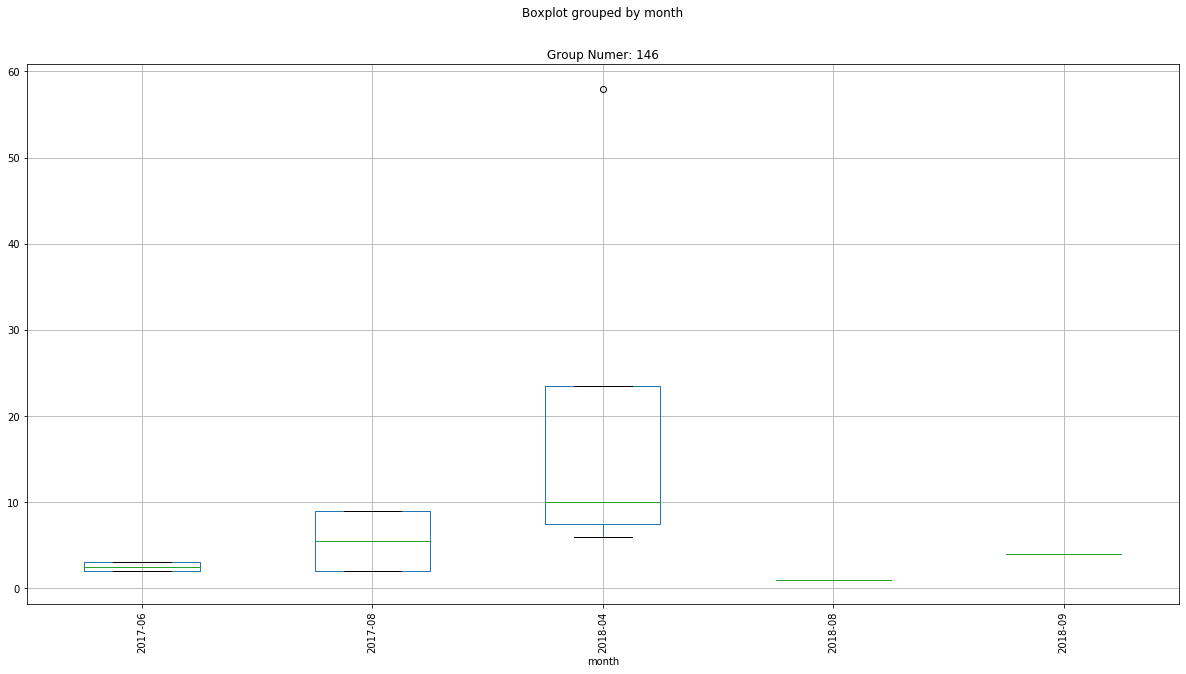

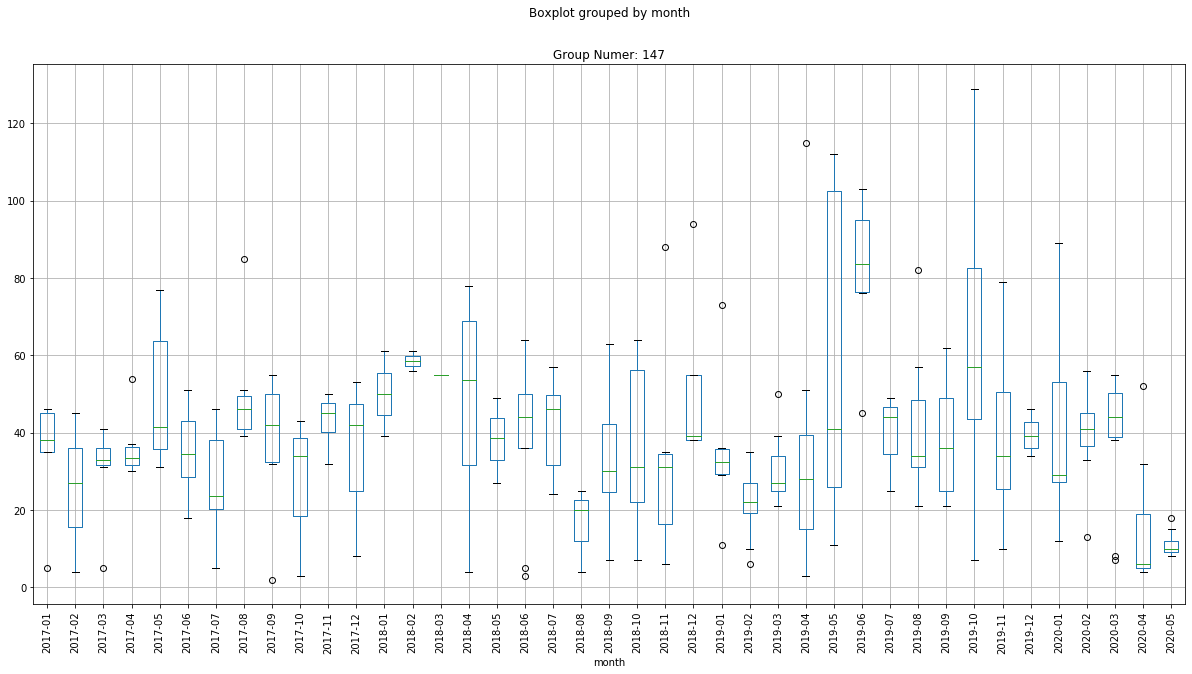

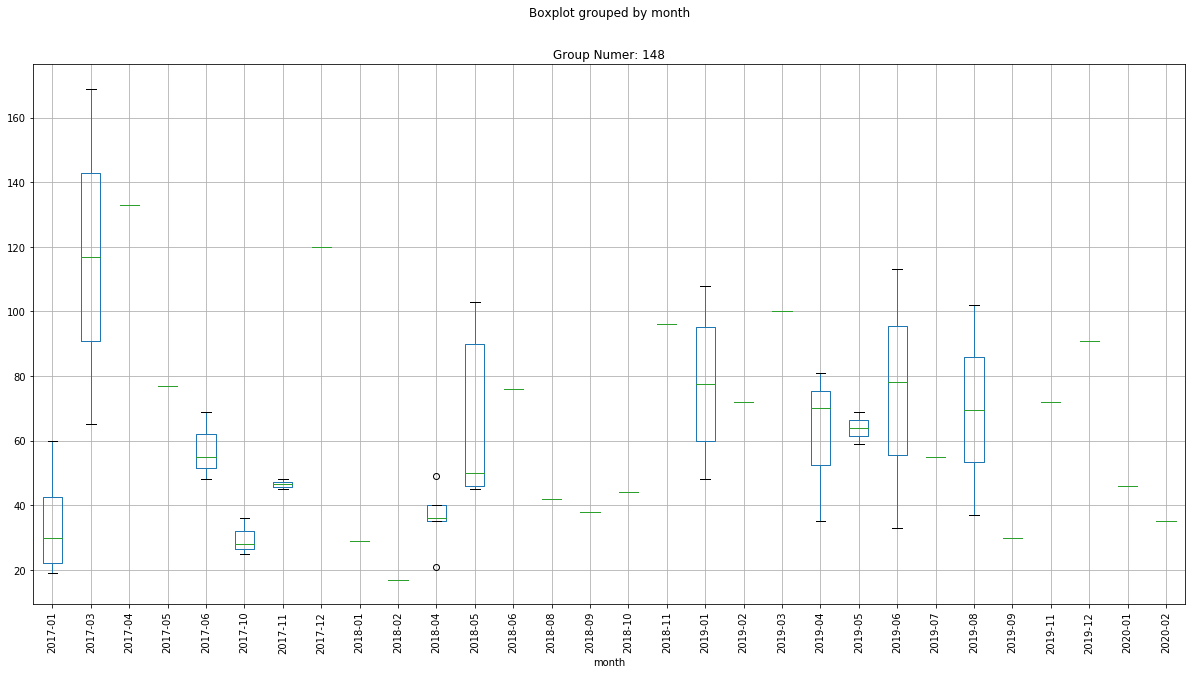

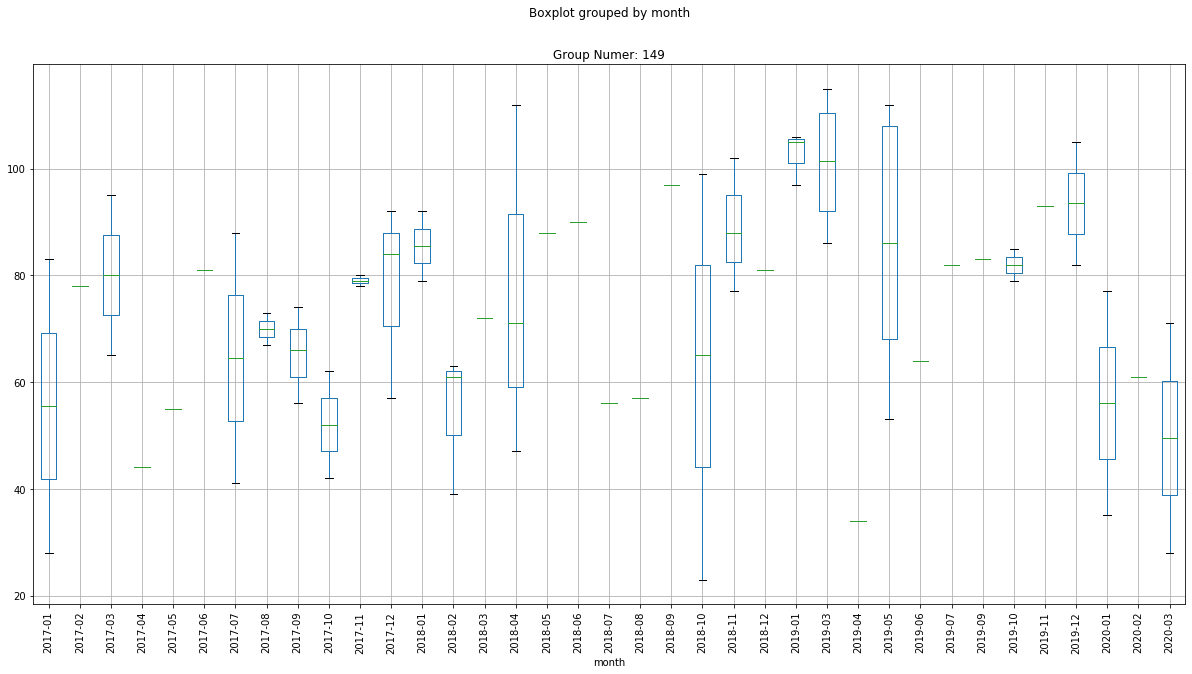

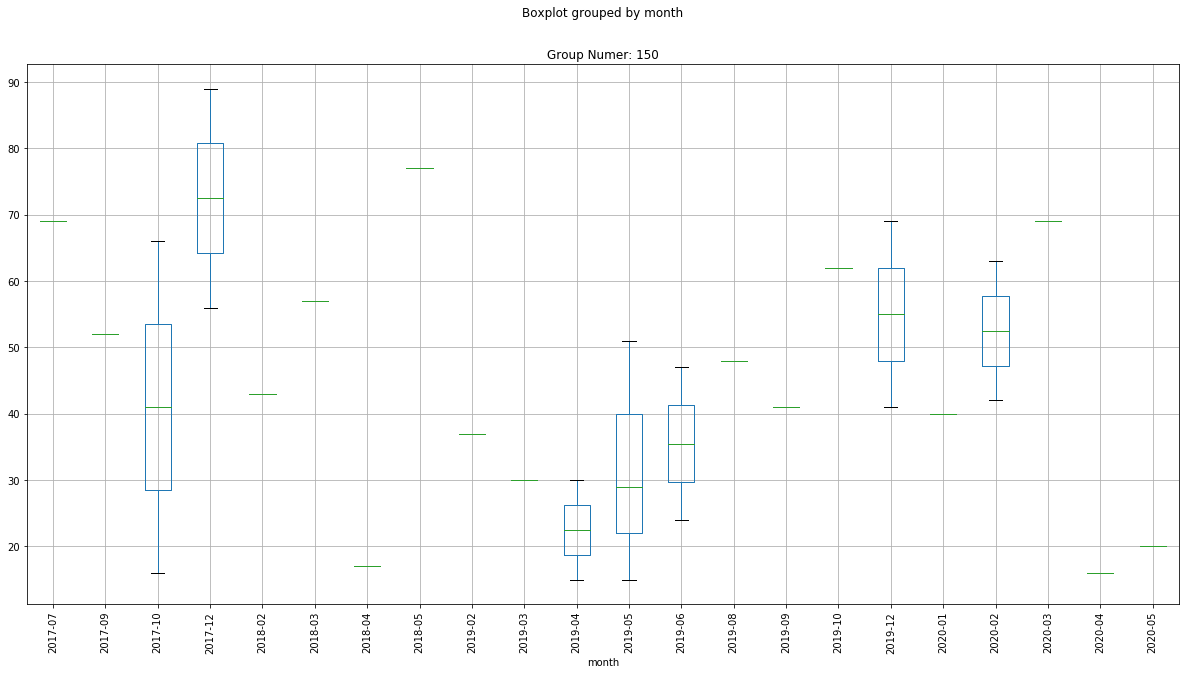

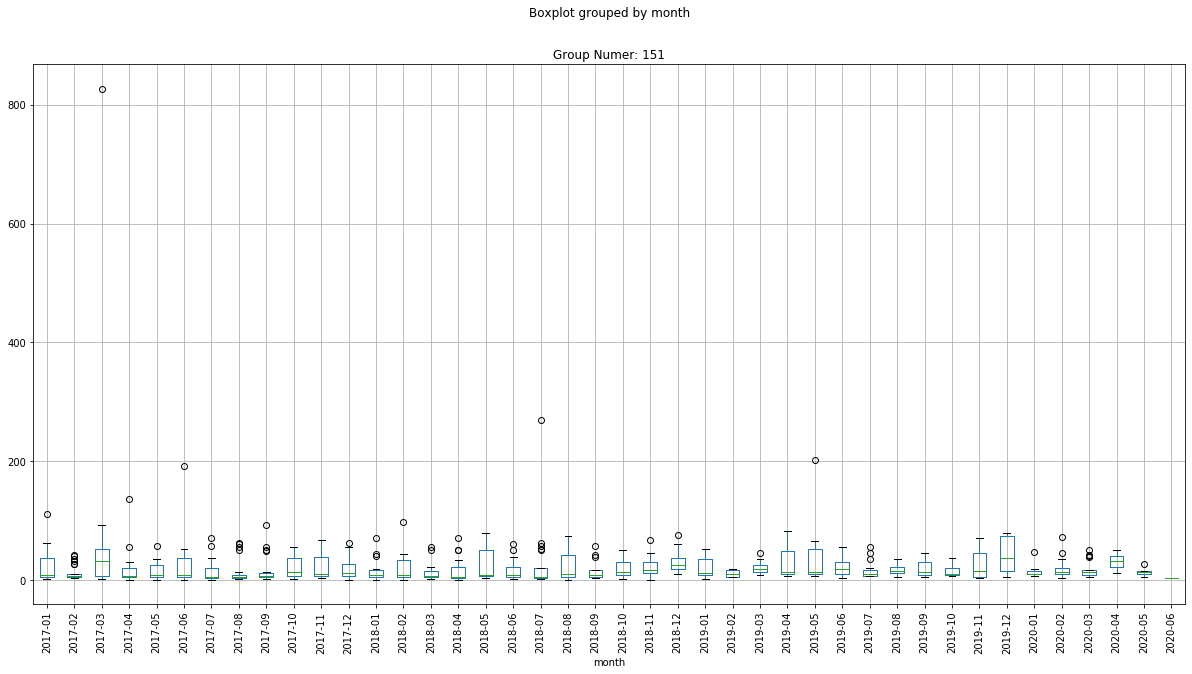

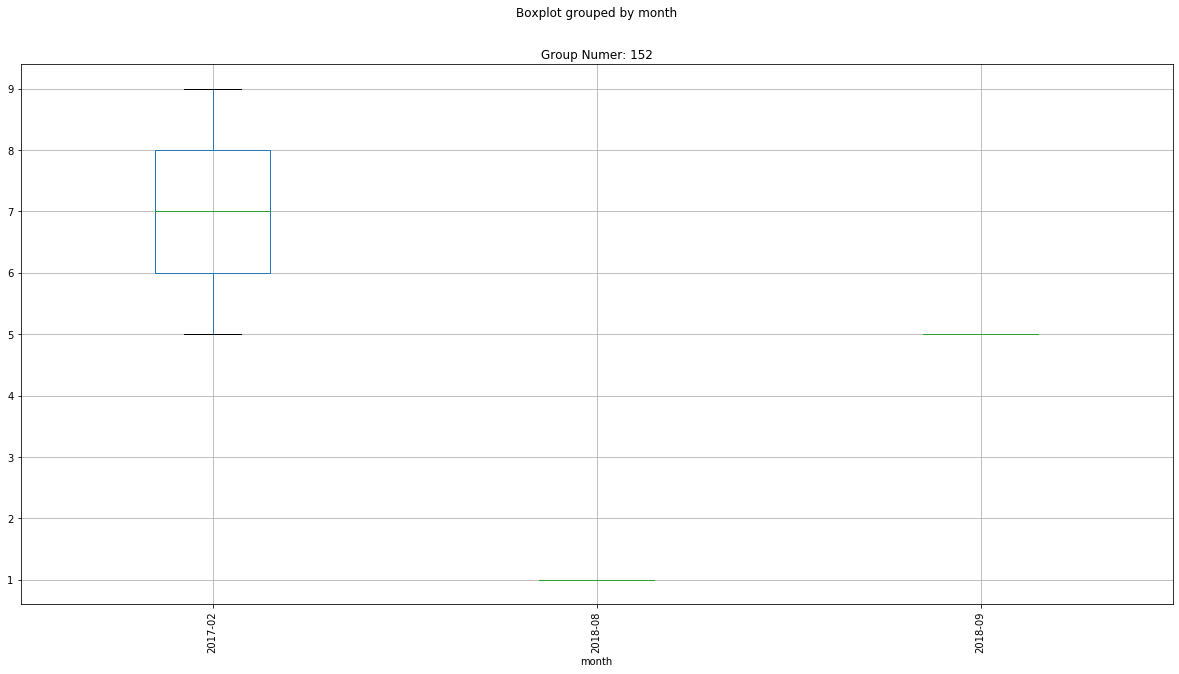

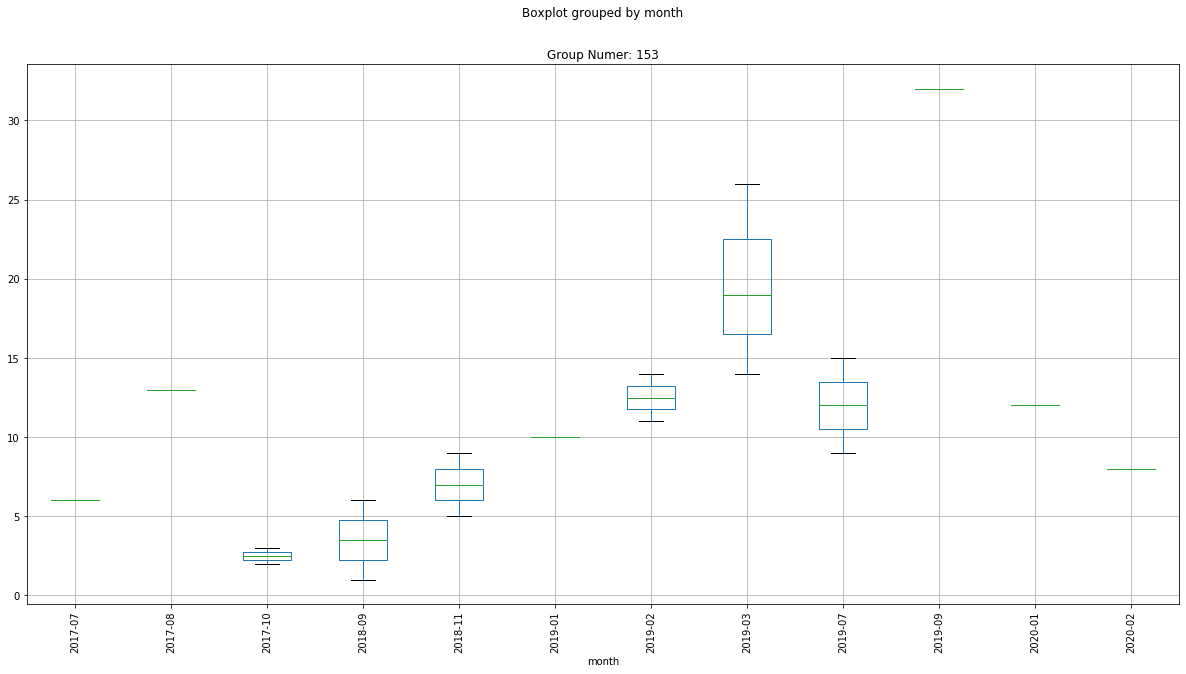

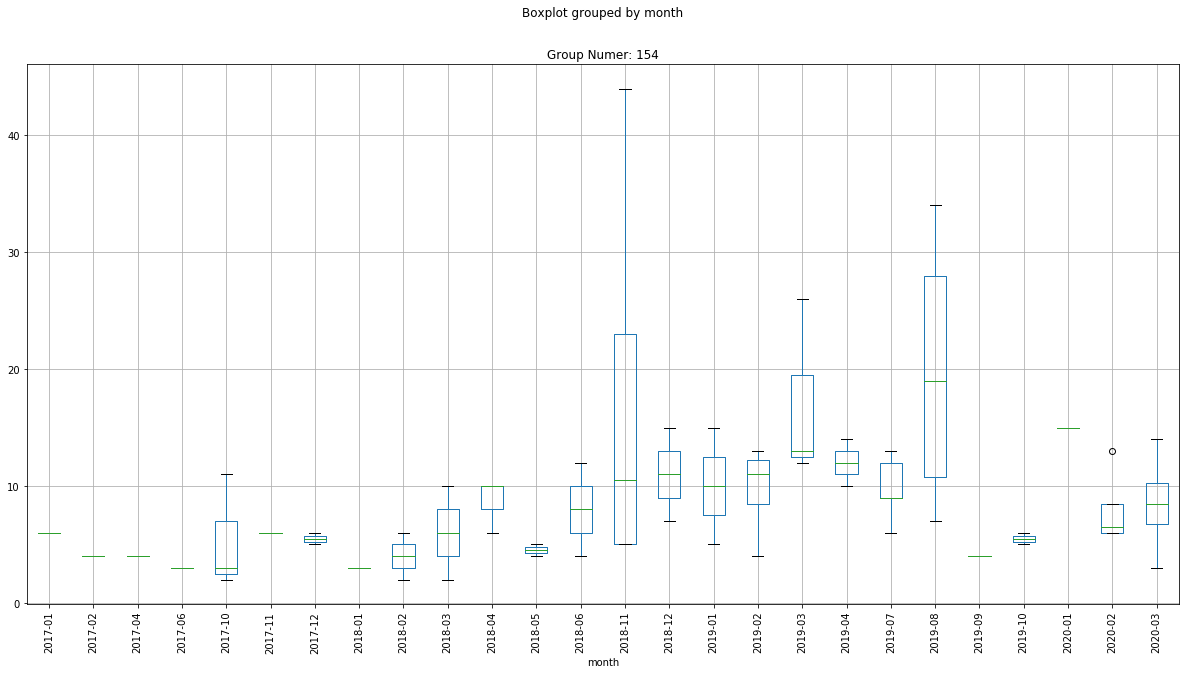

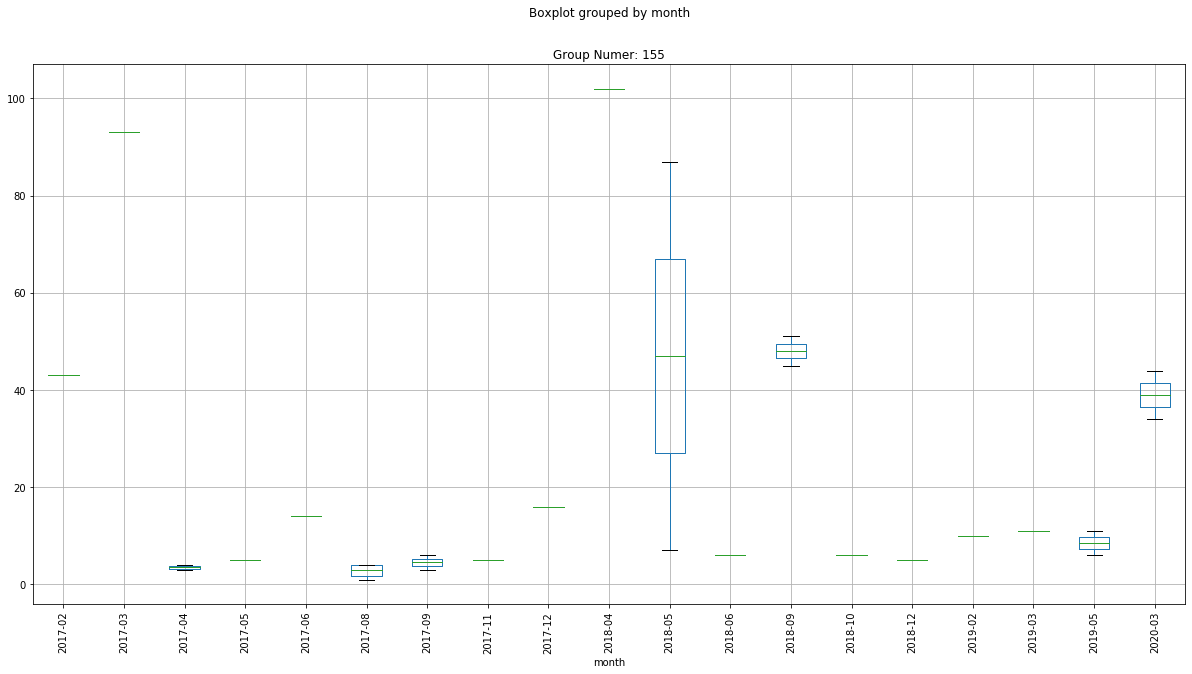

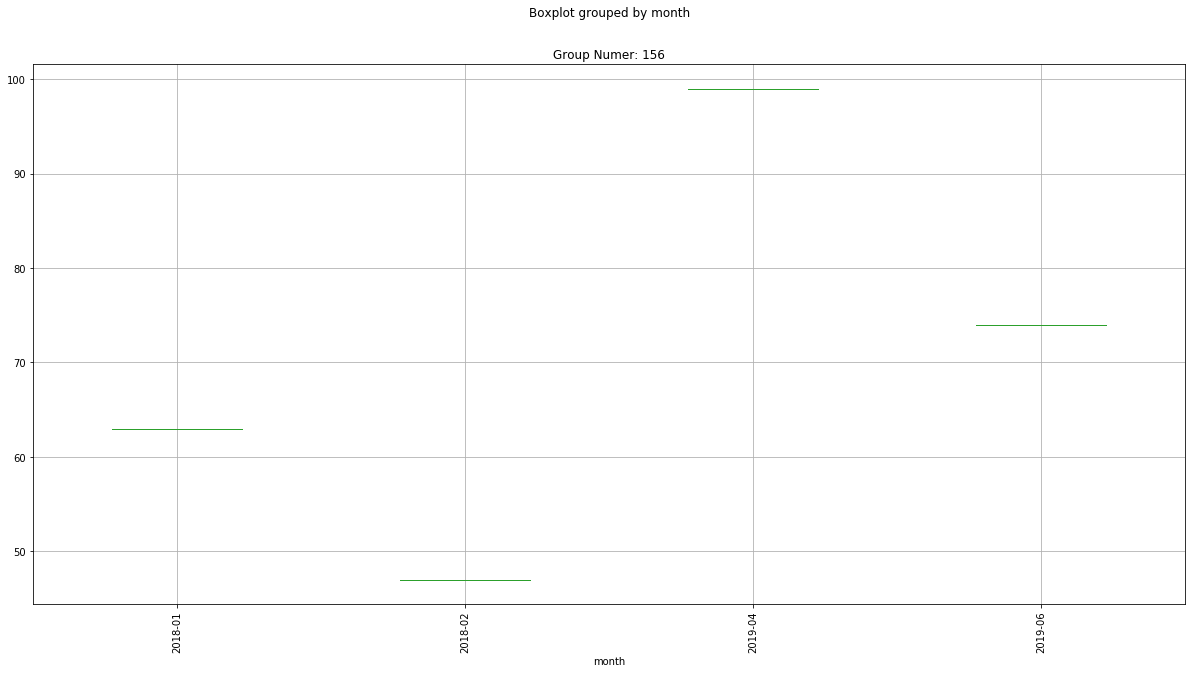

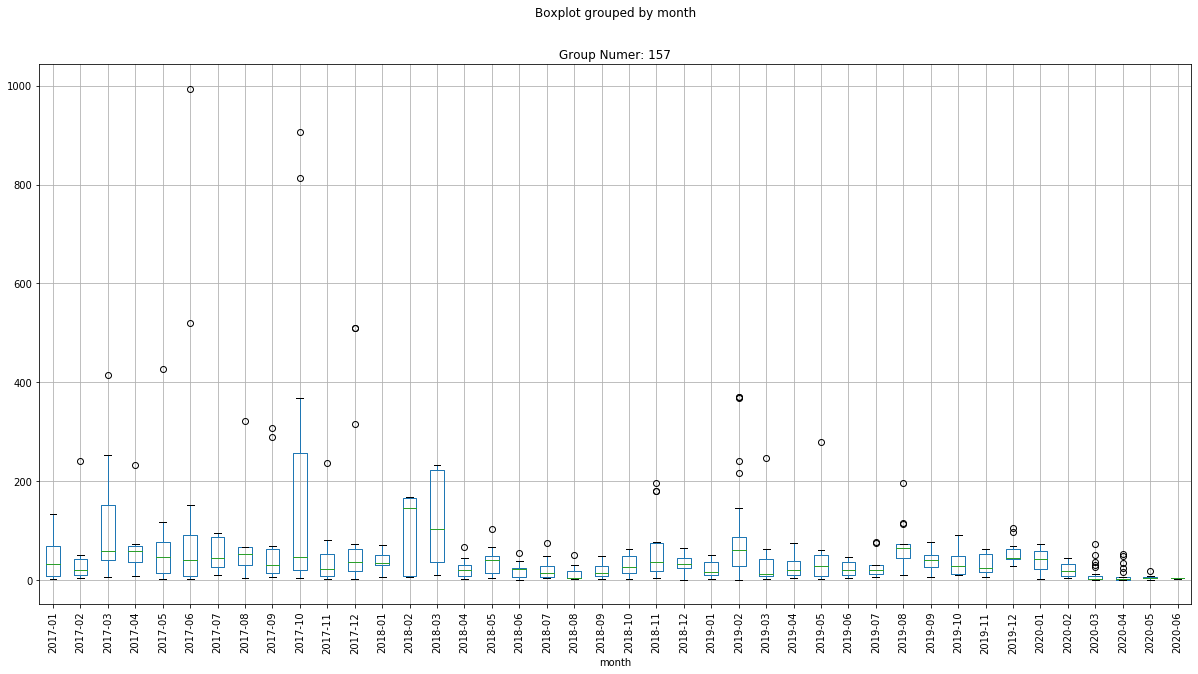

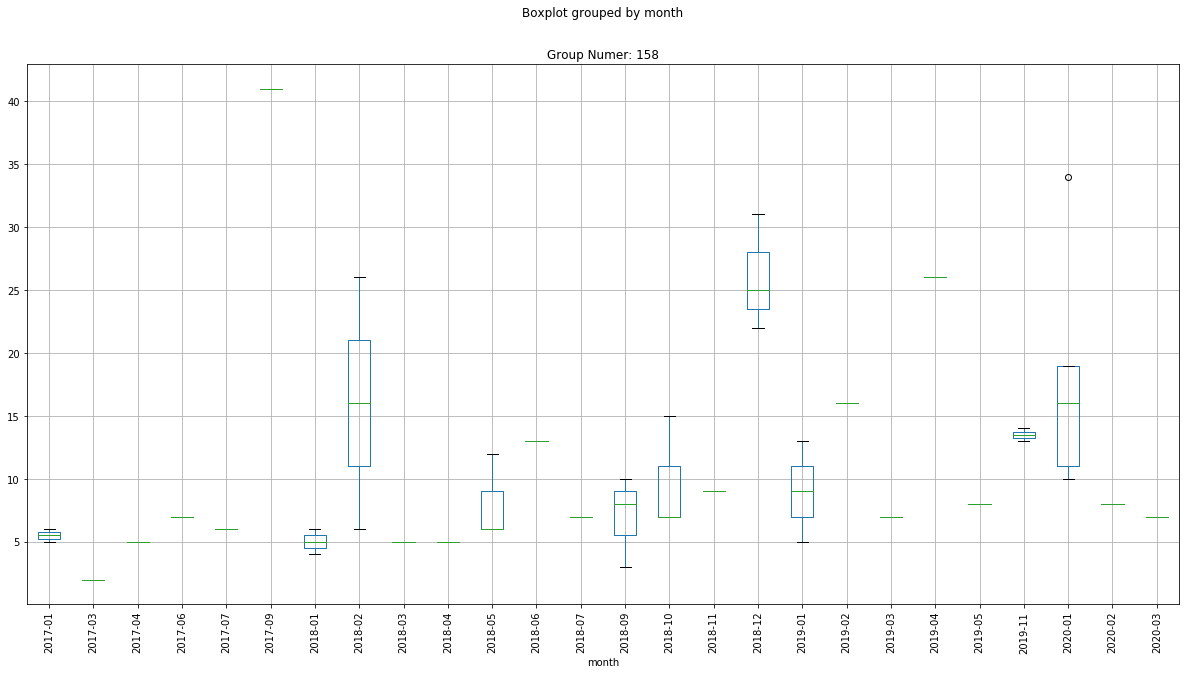

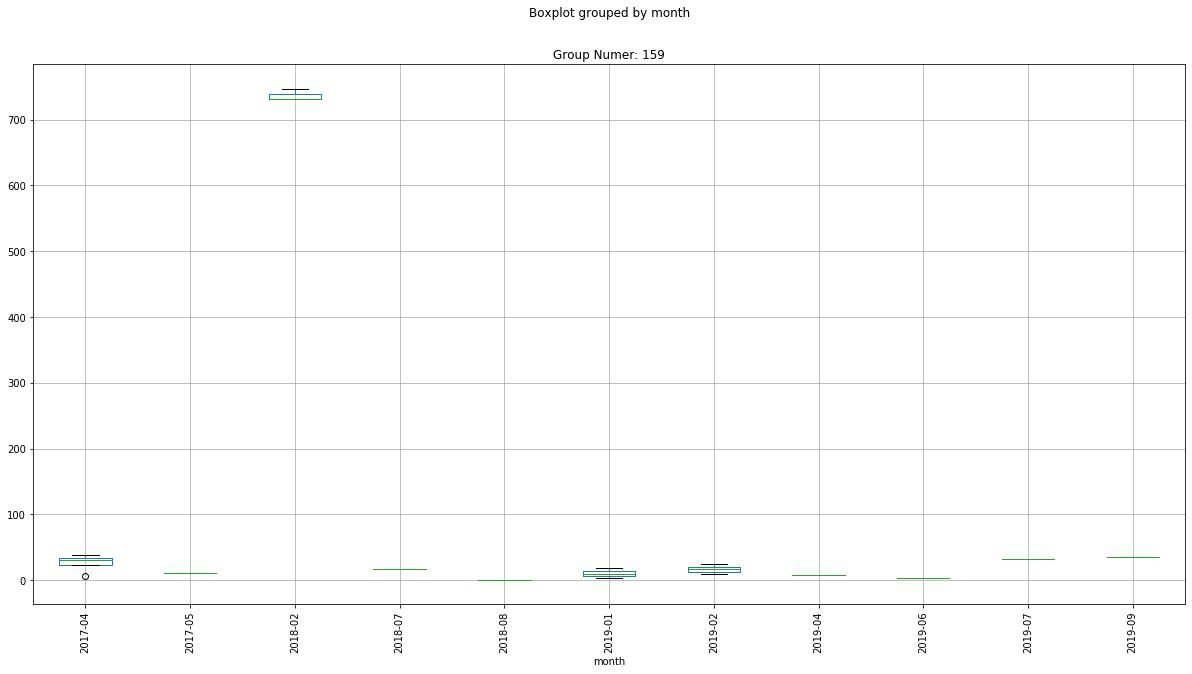

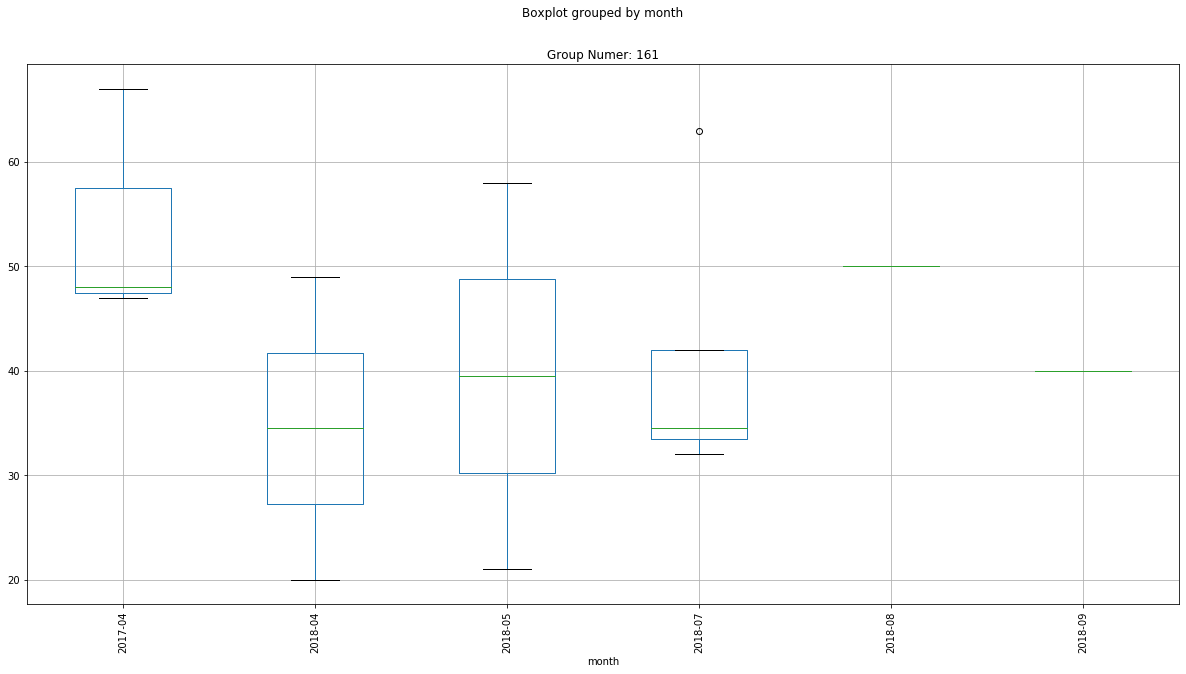

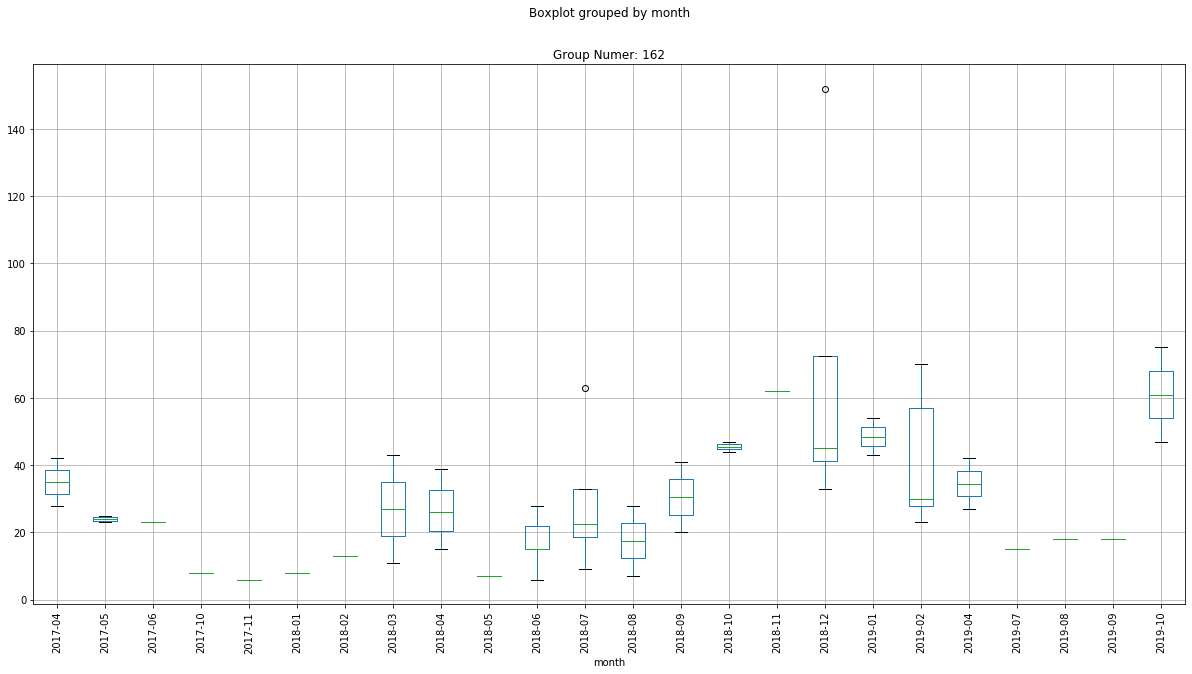

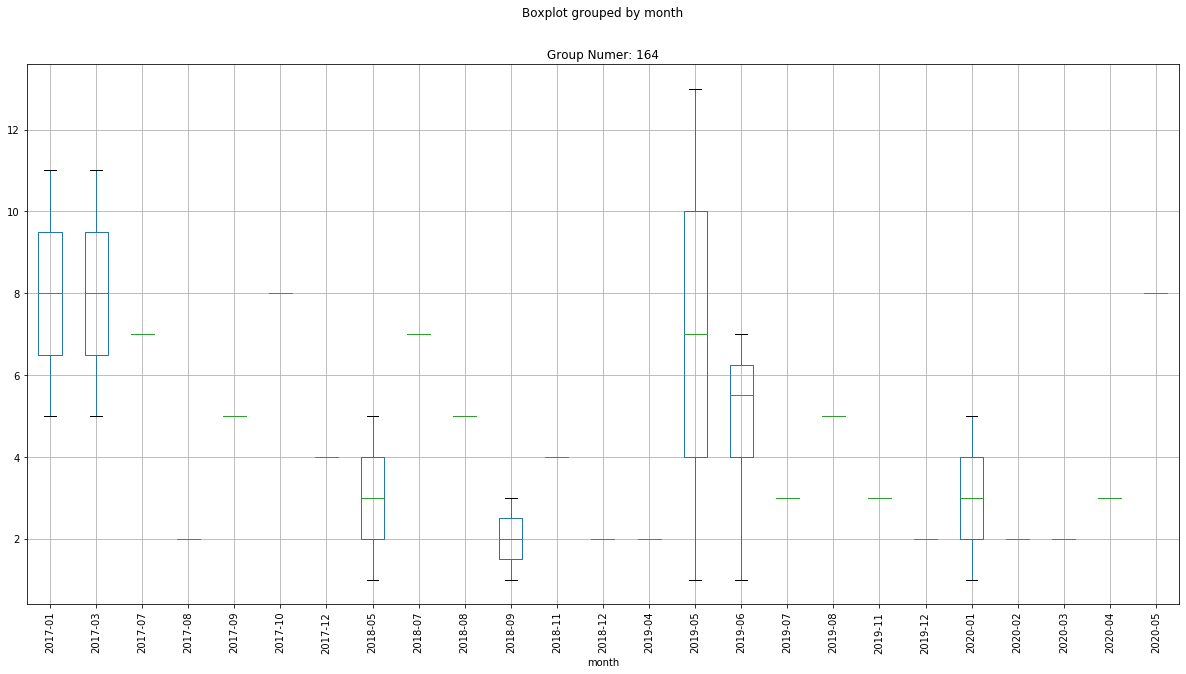

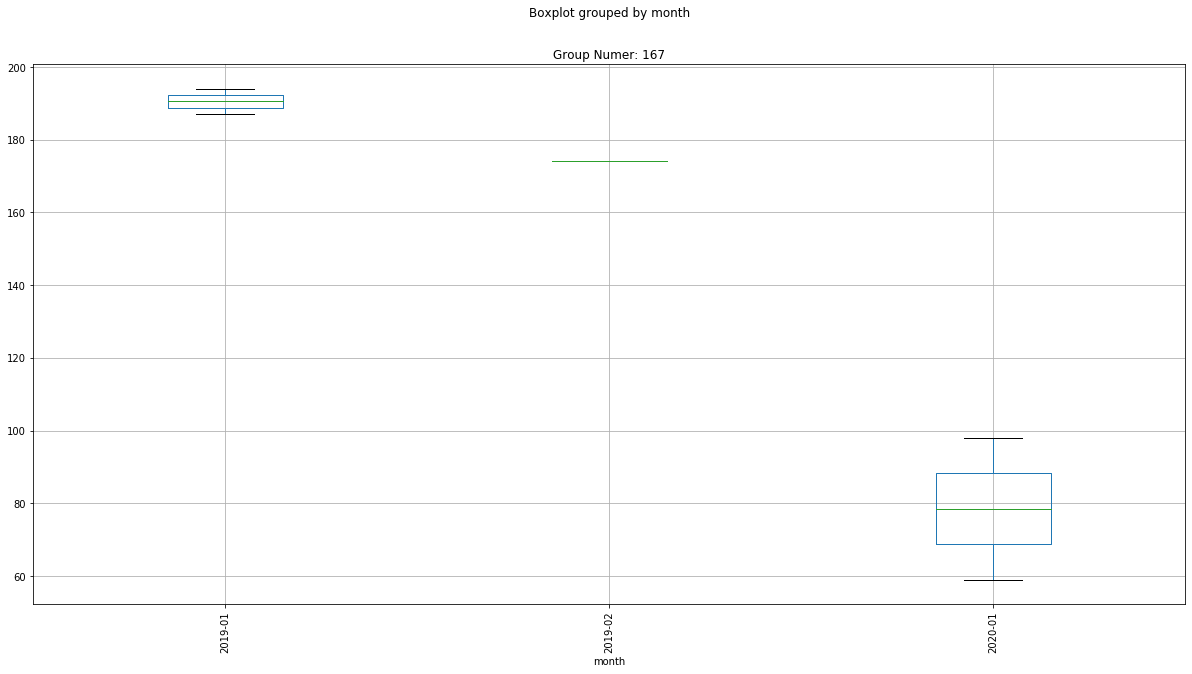

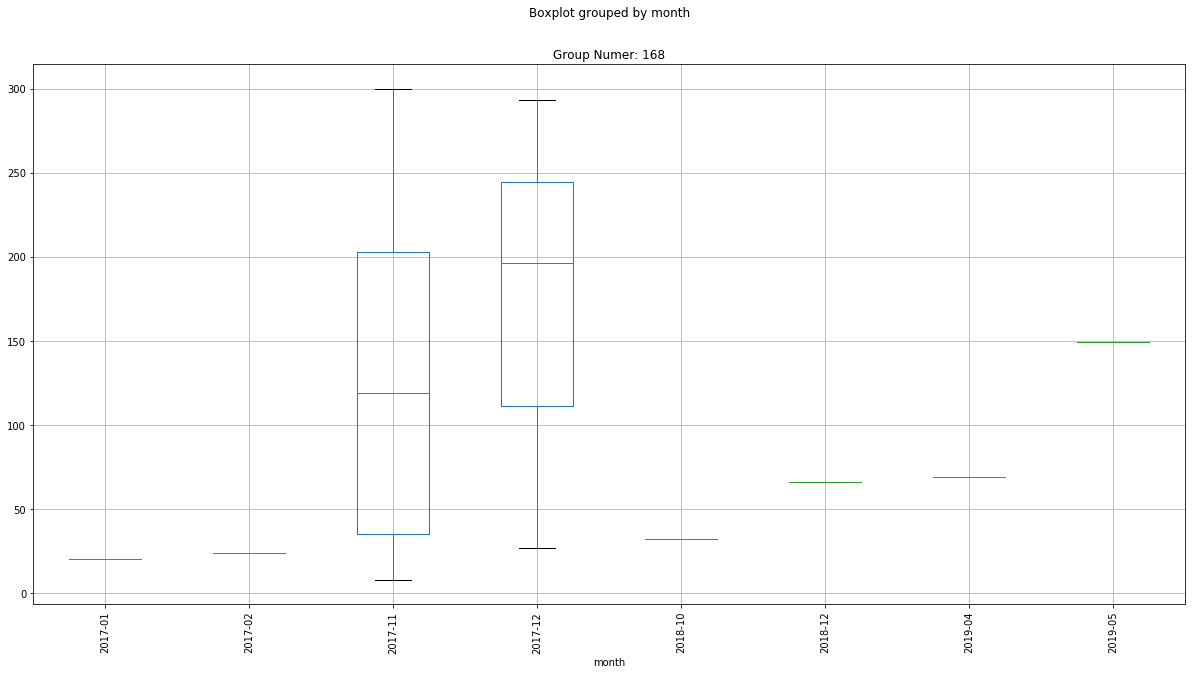

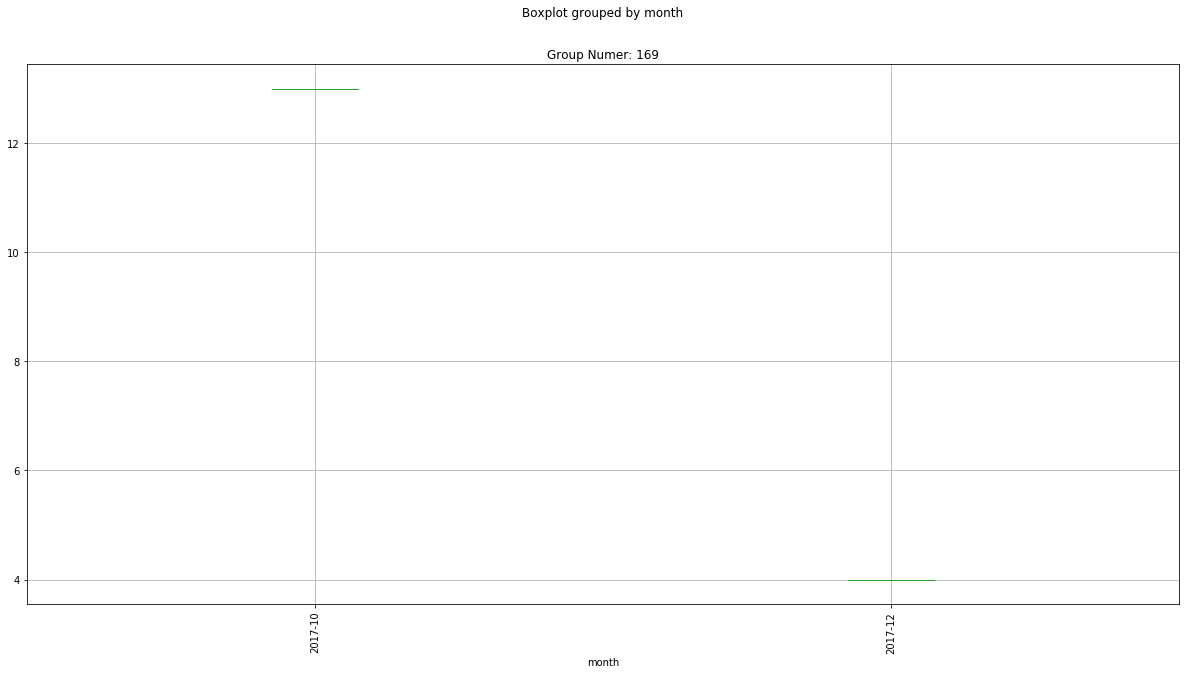

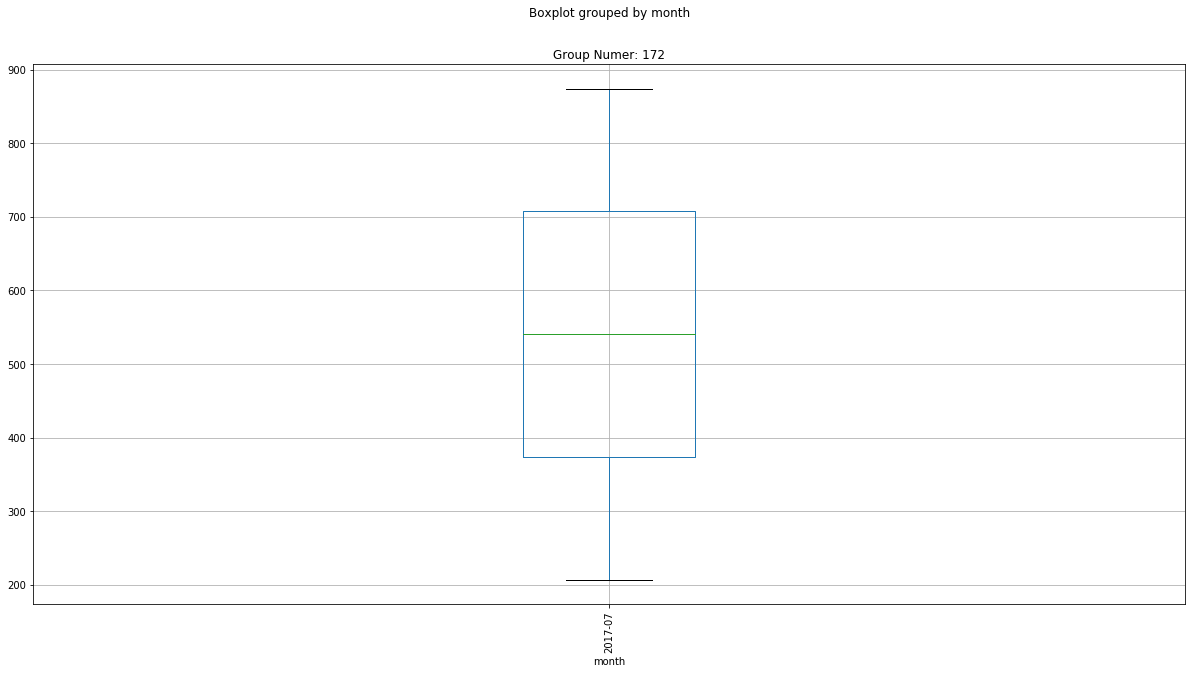

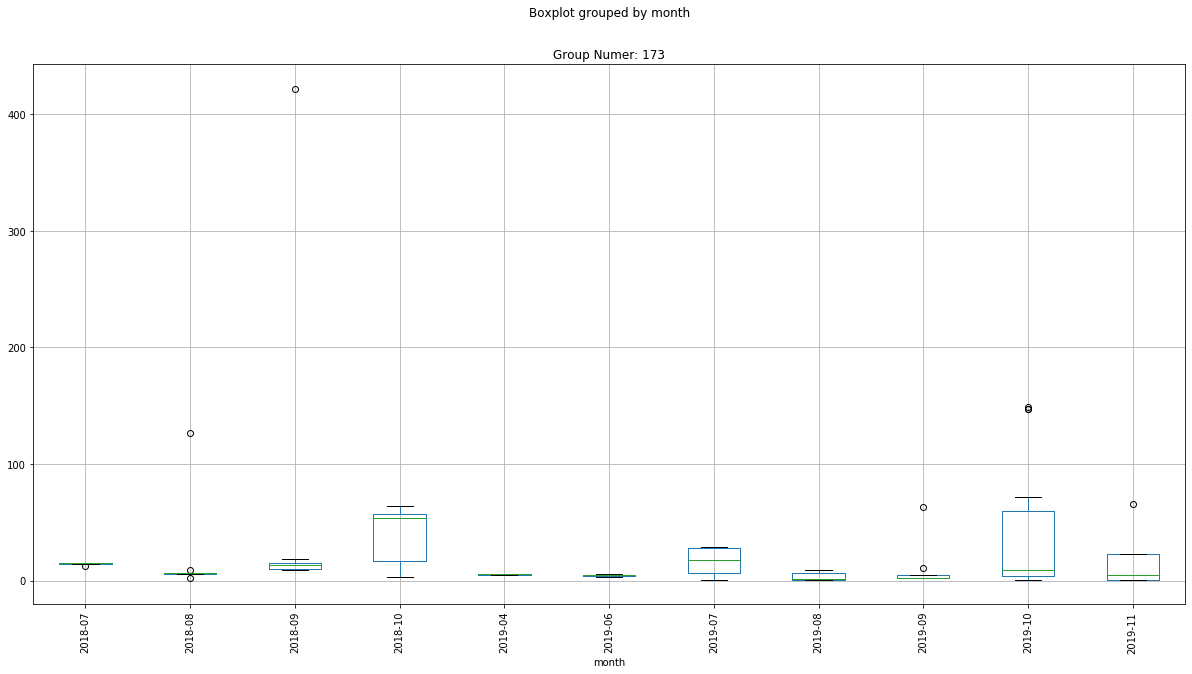

In [12]:
unique_group = pd.unique(df["Group"])
unique_group.sort()

for value in unique_group:
    group = new_df[new_df["Group"] == value]
    if len(group) > 0:
        group.boxplot(column = "Duration", by = "month", figsize = (20, 10), rot = 90)
        plt.title(f"Group Numer: {value}")
        name = str(value)
        plt.savefig(f"Removed Outliers group/" + name + ".png")
    

# Looking at Group

In [13]:
group = df.loc[df["Group"] == 106]
#group = df.loc[df["Material"] == 100001855]
group = group[["Duration", "Confirmation Start Date", "Total order quantity"]]
group.set_index("Confirmation Start Date", inplace = True)
group = group.loc[group["Duration"] > 0]
group = group.sort_values("Confirmation Start Date")
group["month"] = group.index.to_period("M")
group["quarter"] = group.index.to_period("Q")
#group["per"] = group["Confirmation Start Date"].dt.to_period("M")

In [14]:
group.head()

,Duration,Total order quantity,month,quarter
Confirmation Start Date,,,,
2017-01-04,1,15.0,2017-01,2017Q1
2017-01-04,15,15.0,2017-01,2017Q1
2017-01-04,5,16.0,2017-01,2017Q1
2017-01-05,5,16.0,2017-01,2017Q1
2017-01-05,6,16.0,2017-01,2017Q1


In [ ]:
#This shows that our data is not normally distributed
# import scipy.stats
# import pylab

# scipy.stats.probplot(group["Duration"], plot = pylab)
# pylab.show()

In [ ]:
#W
# train_start, train_end = "2016-10-02", "2019-09-08"
# test_start, test_end = "2019-09-15", "2020-06-07"

#BM
# train_start, train_end = "2016-09-30", "2019-08-30"
# test_start, test_end = "2019-09-30", "2020-06-30"

,count,mean,std,min,25%,50%,75%,max
Duration,1726.0,10.034183,8.158395,1.0,6.0,7.0,12.0,151.0
Total order quantity,1726.0,15.614137,2.538174,4.0,16.0,16.0,16.0,64.0


(1726, 4)

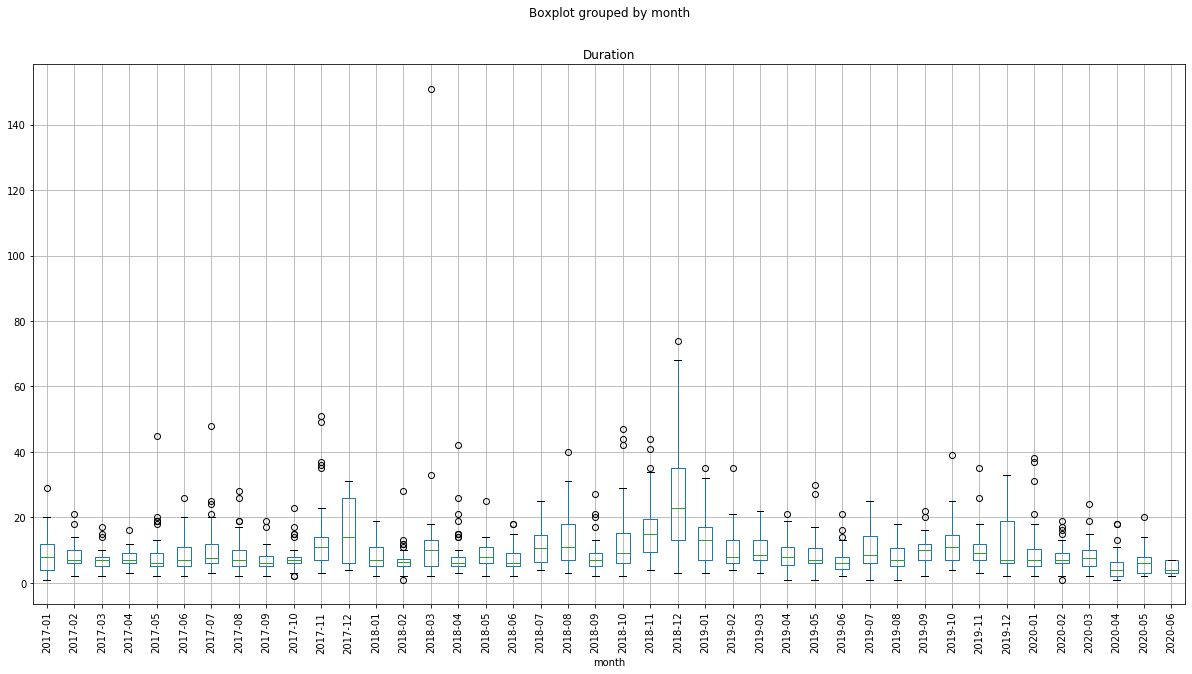

In [15]:
display(group.describe().transpose())
group.boxplot(column = "Duration", by = "month", figsize = (20, 10), rot = 90)
group.shape

#plt.savefig("With outliers" + ".png")

In [ ]:
# STD

# dates = pd.unique(group["per"])
# # empty is an empty dataframe that I am adding rows to at the end of the for-loop
# empty = pd.DataFrame()

# std = group["Duration"].std()
# mean = group["Duration"].mean()

# lower = mean - std*3
# upper = mean + std*3

# for month in dates:
#     df_quarter = group.loc[group["per"] == month]
    
#     #Looking at Outliers 
   

#     temp = df_quarter[(df_quarter["Duration"] < upper)]
#     empty = empty.append(temp)

,Duration,Total order quantity
count,1628.000000,1628.000000
mean,9.038084,15.603808
std,5.904986,2.604126
min,1.000000,4.000000
25%,6.000000,16.000000
50%,7.000000,16.000000
75%,11.000000,16.000000
max,41.000000,64.000000


(1628, 4)

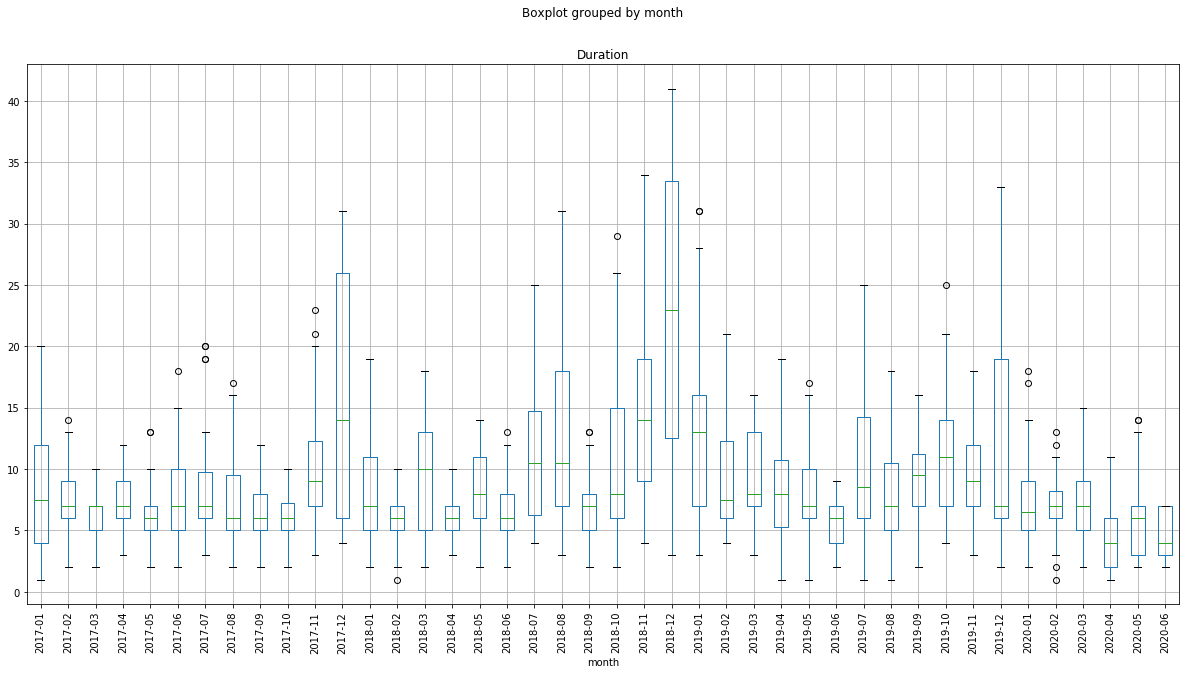

In [16]:
# IQR

dates = pd.unique(group["month"])
# empty is an empty dataframe that I am adding rows to at the end of the for-loop
empty = pd.DataFrame()
for month in dates:
    df_quarter = group.loc[group["month"] == month]
    
    #Looking at Outliers
    q1 = df_quarter.quantile(0.25)[0]
    q2 = df_quarter.quantile(0.50)[0]
    q3 = df_quarter.quantile(0.75)[0]

    IQR = q3 - q1
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR

    temp = df_quarter[(df_quarter["Duration"] < upper)]
    empty = empty.append(temp)
    
display(empty.describe())
empty.boxplot(column = "Duration", by = "month", figsize = (20, 10), rot = 90)
display(empty.shape)

#plt.savefig("Without outlier" + ".png")

,Duration,Total order quantity
count,1609.000000,1609.000000
mean,8.845867,15.600373
std,5.633266,2.619060
min,1.000000,4.000000
25%,5.000000,16.000000
50%,7.000000,16.000000
75%,11.000000,16.000000
max,41.000000,64.000000


(1609, 4)

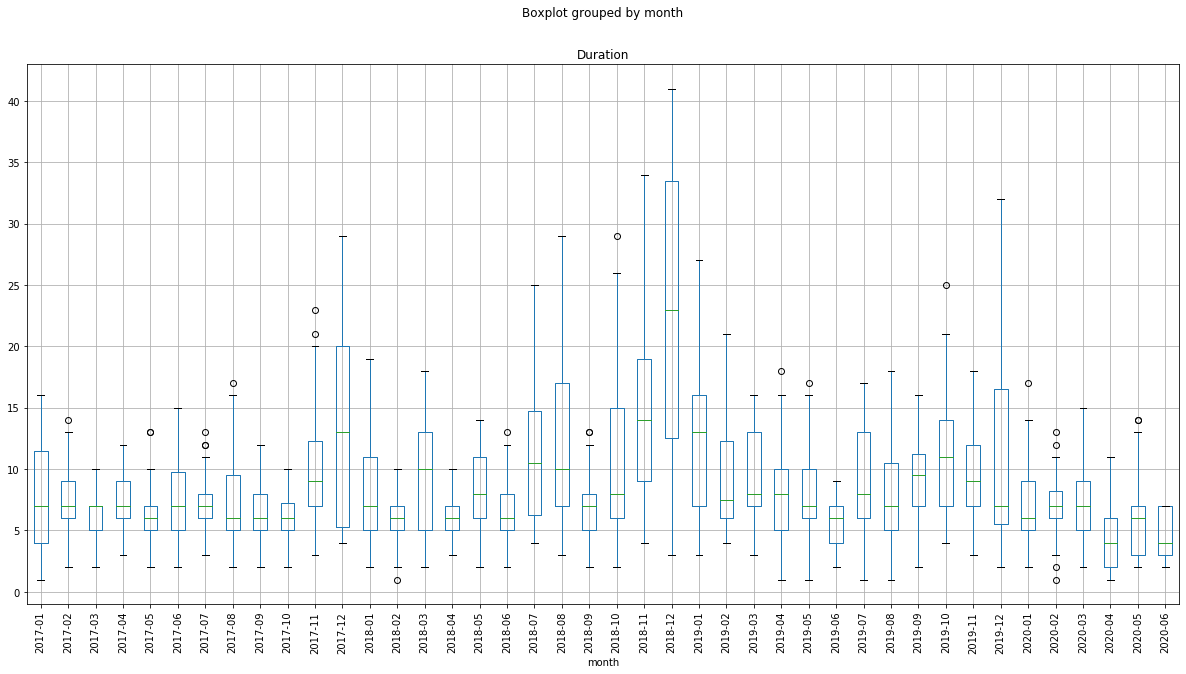

In [17]:
# STD

dates = pd.unique(group["quarter"])
# empty is an empty dataframe that I am adding rows to at the end of the for-loop
empty2 = pd.DataFrame()



for quarter in dates:
    df_quarter = empty.loc[empty["quarter"] == quarter]
    
    std = df_quarter["Duration"].std()
    mean = df_quarter["Duration"].mean()

    lower = mean - std*3
    upper = mean + std*3 
   

    temp = df_quarter[(df_quarter["Duration"] < upper)]
    empty2 = empty2.append(temp)
    

#display(empty2.head())
display(empty2.describe())
empty2.boxplot(column = "Duration", by = "month", figsize = (20, 10), rot = 90)
display(empty2.shape)

#plt.savefig("Without outlier" + ".png")

In [18]:
# group_resample has the moving average for every month
group_resample = empty2.resample("W").mean()
group_resample["Duration"] = group_resample["Duration"].fillna(method = "ffill")
group_resample["Total order quantity"] = group_resample["Total order quantity"].fillna(method = "ffill")


#group_resample["Total order quantity"] = group_resample["Total order quantity"].fillna(method = "ffill")
#group_resample["returns"] = group_resample["Duration"].pct_change(1)
#group_resample = group_resample.dropna()

ratio = 0.8
length = group_resample.shape[0]
pivot = int(ratio * length)

train = group_resample[:pivot]
test = group_resample[pivot:]

train_size = train.shape[0]
test_size = test.shape[0]
group_resample_size = group_resample.shape[0]


# display(train_size)
# display(test_size)
# display(group_resample_size)
display(group_resample)
# display(test)

,Duration,Total order quantity
Confirmation Start Date,,
2017-01-08,7.800000,15.800000
2017-01-15,12.250000,15.750000
2017-01-22,3.600000,14.800000
2017-01-29,8.250000,15.750000
2017-02-05,8.923077,15.461538
...,...,...
2020-05-10,5.533333,15.200000
2020-05-17,10.400000,14.600000
2020-05-24,6.500000,18.200000


In [ ]:
# Not finding moving average

# group_resample = empty
# group_resample["Duration"] = group_resample["Duration"].fillna(method = "ffill")
# group_resample["Total order quantity"] = group_resample["Total order quantity"].fillna(method = "ffill")


# ratio = 0.7
# length = group_resample.shape[0]
# pivot = int(ratio * length)

# train = group_resample[:pivot]
# test = group_resample[pivot:]

# train_size = train.shape[0]
# test_size = test.shape[0]
# group_resample_size = group_resample.shape[0]


# display(train_size)
# display(test_size)
# display(group_resample_size)
# display(group_resample)
# display(test)

In [ ]:
group_resample.plot()
display(empty[:20])
display(group_resample)

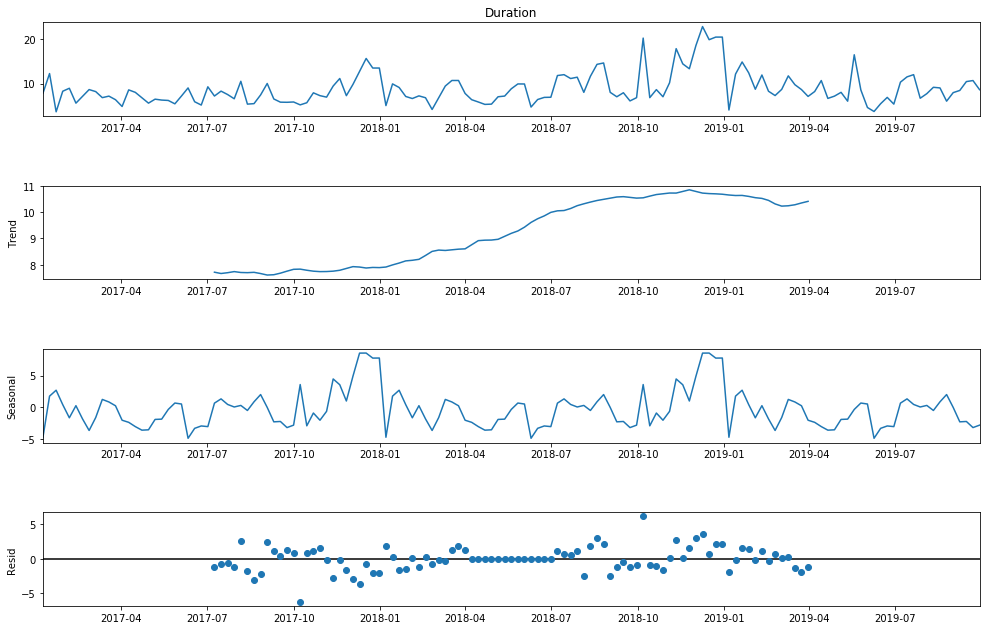

In [19]:
res = sm.tsa.seasonal_decompose(train["Duration"], model = "additive")
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

In [ ]:
#including returns and normalized data

# group_resample["returns"] = group_resample["Duration"].pct_change(1)
# group_resample["returns"].plot()

# benchmark = group_resample["Duration"].iloc[0]
# group_resample["norm"] = group_resample["Duration"].div(benchmark)

# group_resample["norm"].plot()
# display(adfuller(group_resample["returns"].dropna()))

In [ ]:
#Normalizing values

# bench_ret = group_resample["returns"].dropna().iloc[0]
# group_resample["norm_ret"] = group_resample["returns"].div(bench_ret).mul(100)
# group_resample.head()

In [ ]:
# Doing ACF and PACF on returns 

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, ax = plt.subplots(2, 1, figsize=(20, 15))
# fig = sm.graphics.tsa.plot_acf(train.returns.dropna(), lags = 25, ax=ax[0], zero = False)

# fig = sm.graphics.tsa.plot_pacf(train.returns.dropna(), lags = 25, ax=ax[1], zero = False, method = "ols")
# plt.show()

#p is 1, 2
#d is 1
#q is 1, 2

In [ ]:
def adf_check(time_series):
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Obs used']
    
    print('Critical values:')
    for key,value in result[4].items():
        print('\t{}: {}'.format(key, value) )
    
    for value, label in zip(result,labels):
        print(label+ ' : '+str(value))
    
    if ((result[1] <= 0.05 and  result[0] <= result[4]['1%']) or
    (result[1] <= 0.05 and  result[0] <= result[4]['5%']) or
        (result[1] <= 0.05 and  result[0] <= result[4]['10%'])):
        print('Reject null hypothesis')
        print ('Data has no unit root and is stationary')
   
    else:
        print('Fail to reject null hypothesis')
        print('Data has a unit root and it is non-stationary')

result = adf_check(group_resample["Duration"])

In [ ]:
#Beginning of indian YouTube Tutorial 

In [ ]:
# group_resample.shape

In [ ]:
# group_resample["Seasonal_First_Difference"] = group_resample["Duration"] - group_resample["Duration"].shift(12)

In [ ]:
# adf_check(group_resample["Seasonal_First_Difference"].dropna())
# group_resample["Seasonal_First_Difference"].plot()

In [ ]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(group_resample["Duration"])
# plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
fig = sm.graphics.tsa.plot_acf(train.Duration.dropna(), lags = 20, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(train.Duration.dropna(), lags = 20, ax=ax[1])
plt.show()

#p is 1, 2
#d is 1
#q is 1, 2

In [ ]:
# ARIMA model

#Not such a good approach because the data we have is seasonal
# model = ARIMA(group_resample["Duration"], order = (1, 1, 1), exog = train["Total order quantity"])
# results = model.fit()
# results.summary()

In [ ]:
# SARIMA model

model = sm.tsa.statespace.SARIMAX(train["Duration"], order = (1, 1, 1), seasonal_order=(1, 1, 1, 12), exog = train["Total order quantity"])
results = model.fit()
results.summary()

In [29]:
#AUTO ARIMA MODEl


# model_auto = pm.auto_arima(group_resample["Duration"].dropna(), m = 12, max_order = None, max_p = 5, max_q = 7, max_d = 2, 
#                               max_P = 4, max_Q = 4, max_D = 2, start_p = 3, trend = "ct", 
#                                 exogenous = group_resample[["Total order quantity"]])




# model_auto = pm.auto_arima(train["Duration"], m = 12, max_p = 5, max_q = 7, max_d = 2, max_P = 5, 
#                            max_Q = 4, start_p = 1, trend = "ct", exogenous = train[["Total order quantity"]],
#                            information_criterion = "aic", d = 1, D = 1, trace = True, suppress_warnings = True, 
#                           seasonal = True)

# model_auto = pm.auto_arima(group_resample["Duration"], m = 12, max_p = 5, max_q = 7, max_d = 2, max_P = 5, 
#                            max_Q = 4, start_p = 1, trend = "ct", exogenous = group_resample[["Total order quantity"]],
#                            information_criterion = "aic", d = 1, trace = True, suppress_warnings = True, 
#                           seasonal = True)

# model_auto = pm.auto_arima(train["Duration"], exogenous = train[["Total order quantity"]], d = 1,
#                           trace = True, suppress_warnings = True, information_criterion = "aic", start_p = 1, 
#                            start_q = 1, scoring = "mse")

model_auto = pm.auto_arima(train["Duration"], exogenous = train[["Total order quantity"]], start_p = 0, start_q = 0, 
                           start_Q = 0, max_p = 10, max_q = 10, max_Q = 10, stepwise = True, d = 1, 
                           suppress_warnings = True, D=1, max_D = 10, error_action = "ignore", approximation = False, 
                         trace = True, seasonal = True)


# model_auto = pm.auto_arima(train["Duration"], error_action='ignore', trace=True, trend = "ct",
#                       suppress_warnings=True, maxiter=100, D=1,
#                       seasonal=True)

#exogenous = train[["Total order quantity"]], 

model_auto.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=770.793, BIC=779.661, Time=0.056 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=757.196, BIC=769.019, Time=0.080 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=740.046, BIC=751.869, Time=0.074 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=768.793, BIC=774.705, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=735.897, BIC=750.676, Time=0.194 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=737.855, BIC=755.590, Time=0.368 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=735.791, BIC=753.526, Time=0.679 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=736.144, BIC=750.923, Time=0.244 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=746.264, BIC=761.043, Time=0.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -361.895
Date:                Thu, 09 Jul 2020   AIC                            735.791
Time:                        00:02:35   BIC                            753.526
Sample:                    01-08-2017   HQIC                           742.998
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0048      0.006      0.859      0.390      -0.006       0.016
Total order quantity     0.1644      0.467      0.352      0.725      -0.750       1.079
ar.L1                    0.7691      0.123      6.258      0.000       0.528       1.010
ma.L1                   -1.3852      1.451     -0.955      0.340      -4.228       1.458
ma.L2                    0.3855      0.619      0.622      0.534      -0.828       1.599
sigma2                   9.3529     12.756      0.733      0.463     -15.649      34.355
===================================================================================
Ljung-Box (Q):                       47.47   Jarque-Bera (JB):                78.44
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               4.08   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Auto Arima model forcasting check Without Exogenous variables

# Without exogenous variables

model_auto.fit(train["Duration"])
future_forecast = model_auto.predict(n_periods=test_size)
future_forecast

#---------------------------------------------------------------------------------------------------------------------------

# Predicting without exogenous

df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = test_size), index = test.index)

#---------------------------------------------------------------------------------------------------------------------------


# Putting forecasted and predicted into one table, plotting it, and showing it's error

df_auto_pred["test"] = test["Duration"]
df_auto_pred.columns = ["predict", "test"]
display(df_auto_pred)
display(df_auto_pred.plot())
error = mean_squared_error(df_auto_pred["predict"], df_auto_pred["test"])
display(f"mean squared error: {error}")

ValueError: x and y must have same first dimension, but have shapes (179,) and (36,)

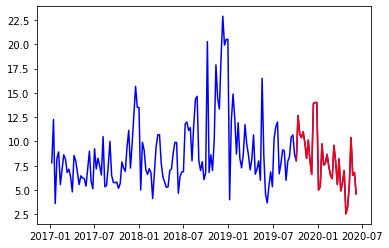

In [36]:
# Auto Arima model forcasting check with Exogenous variables

# With exogenous variables

model_auto.fit(train["Duration"], exogenous = train[["Total order quantity"]])
future_forecast = model_auto.predict(n_periods=test_size, exogenous = test[["Total order quantity"]])
future_forecast

#---------------------------------------------------------------------------------------------------------------------------

# Predicting with exogenous


df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = test_size, exogenous = test[["Total order quantity"]]), 
                                             index = test.index)

#---------------------------------------------------------------------------------------------------------------------------


# Putting forecasted and predicted into one table, plotting it, and showing it's error


df_auto_pred["test"] = test["Duration"]
df_auto_pred.columns = ["predict", "test"]


#trying to plot the data
# plt.plot(group_resample["Duration"], c = "blue")
# plt.plot(df_auto_pred["predict"], c = "red")


#Trying to copy Kenar's Code
# x = np.arange(group_resample_size)
# plt.plot(group_resample["Duration"], c='blue')
# plt.plot(df_auto_pred["test"], c = "red")
# plt.plot(x[:], df_auto_pred["predict"], c = "pink")

#display(df_auto_pred)
# display(group_resample["Duration"].plot())
# display(df_auto_pred.plot())
error = mean_squared_error(df_auto_pred["predict"], df_auto_pred["test"])
display(f"mean squared error: {error}")

In [34]:
group_resample.head()

,Duration,Total order quantity
Confirmation Start Date,,
2017-01-08,7.800000,15.800000
2017-01-15,12.250000,15.750000
2017-01-22,3.600000,14.800000
2017-01-29,8.250000,15.750000
2017-02-05,8.923077,15.461538


In [ ]:
# group_resample["forecast"] = model_auto.predict(start = train_size, end = group_resample_size - 1, dynamic = True, exog = test["Total order quantity"])
# group_resample[["Duration", "forecast"]].plot(figsize = (12, 8))
# # group_resample["forecast"].plot(figsize = (12, 8))
# # test["Duration"].plot()

# a = group_resample["forecast"].dropna()
# b = test["Duration"].dropna()
# display(type(a))
# display(type(b))
# newDf = a.to_frame().join(b)
# newDf = newDf.dropna()
# display(newDf)
# error = mean_squared_error(newDf["forecast"], newDf["Duration"])
# display(f"mean squared error: {error}")


In [ ]:
# Predicting with exogenous
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = test_size, exogenous = test[["Total order quantity"]]), 
                                               index = test.index)

# Predicting without exogenous
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = test_size), index = test.index)

# Putting forecasted and predicted into one table, plotting it, and showing it's residual
df_auto_pred["test"] = test["Duration"]
df_auto_pred.columns = ["predict", "test"]
display(df_auto_pred)
display(df_auto_pred.plot())
error = mean_squared_error(df_auto_pred["predict"], df_auto_pred["test"])
display(f"mean squared error: {error}")

In [ ]:
# future_forecast = pd.DataFrame(future_forecast, index = test.index, columns = ["Prediction"])
# # pd.concat([test, future_forecast], axis = 1)
# # future_forecast
# newDf = test["Duration"].to_frame().join(future_forecast)
# newDf = newDf.dropna()
# display(newDf)
# display(newDf.plot())

In [ ]:
# (mean_squared_error(newDf["Duration"], newDf["Prediction"]))

# Break of Code

In [ ]:
residuals = results.resid
residuals.describe()

In [ ]:
group_resample["forecast"] = results.predict(start = train_size, end = group_resample_size - 1, dynamic = True, exog = test["Total order quantity"])
group_resample[["Duration", "forecast"]].plot(figsize = (12, 8))
# group_resample["forecast"].plot(figsize = (12, 8))
# test["Duration"].plot()

a = group_resample["forecast"].dropna()
b = test["Duration"].dropna()
display(type(a))
display(type(b))
newDf = a.to_frame().join(b)
newDf = newDf.dropna()
display(newDf)
error = mean_squared_error(newDf["forecast"], newDf["Duration"])
display(f"mean squared error: {error}")


In [ ]:
test

In [ ]:
#end of indian video

In [ ]:
group_resample["Dif_1"] = group_resample["Duration"] - group_resample["Duration"].shift(1)
group_resample["Dif_1"].plot()
adf_check(group_resample["Dif_1"].dropna())

In [ ]:
group_resample["Dif_Season"] = group_resample["Duration"] - group_resample["Duration"].shift(12)
group_resample["Dif_Season"].plot(rot = 80, figsize=(14, 8))
adf_check(group_resample["Dif_Season"].dropna())

In [ ]:
group_resample["Dif_Season_1"] = group_resample["Dif_1"] - group_resample["Dif_1"].shift(12)
group_resample["Dif_Season_1"].plot()
adf_check(group_resample["Dif_Season_1"].dropna())

In [ ]:
group_resample["Dif_mean"] = group_resample["Duration"] - group_resample["Duration"].rolling(12).mean()
adf_check(group_resample["Dif_mean"].dropna())

In [ ]:
group_resample

In [ ]:
group_resample["Dif_Season_1"]

In [ ]:
decomp = sm.tsa.seasonal_decompose(group_resample["Duration"], freq = 23)
fig = decomp.plot()
fig.set_size_inches(15, 15)

In [ ]:
group_resample["Dif_Season_1"].dropna().size

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
fig = sm.graphics.tsa.plot_acf(group_resample.Duration.dropna(), lags = 40, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(group_resample.Duration.dropna(), lags = 30, ax=ax[1])
plt.show()

In [ ]:
model = sm.tsa.statespace.SARIMAX(train["Duration"], order = (2, 1, 2), seasonal_order = (2, 1, 2, 12))
model_result = model.fit()
print(model_result.summary())

In [ ]:
model_resid = resid.plot(rot = 80)
# res = model_result.resid
# fig, ax = plt.subplots(2, 1, figsize=(15, 8))
# fig = sm.graphics.tsa.plot_acf(res, lags = 50, ax = ax[0])
# fig = sm.graphics.tsa.plot_pacf(res, lags = 50, ax = ax[1])
# plt.show()

In [ ]:
from pandas.tseries.offsets import DateOffset
forecast_dates = [group_resample.index[-1] + DateOffset(months = x) for x in range(1, 24)]
df_future = pd.DataFrame(index = forecast_dates, columns = group_resample.columns)
df_final = pd.concat([group_resample, df_future])

In [ ]:
df_final["Forecast"] = model_result.predict(start = 40, end = 50, alpha = 0.5)
df_final[["Duration", "Forecast"]].plot(figsize=(12,8))

# END OF WORKBOOK ABHI GAVE ME

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig = sm.graphics.tsa.plot_acf(group.Duration.diff().dropna(), lags = 50, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(group.Duration.diff().dropna(), lags = 50, ax=ax[1])
plt.show()

In [ ]:
# p = 11 or 12
# d = 1

resDiff = sm.tsa.arma_order_select_ic(train, max_ar = 13, max_ma = 7, ic="aic", trend = "c")
print('ARMA(p,q) =', resDiff['aic_min_order'],'is the best.')
# 5, 7

In [ ]:
# ARIMA MODEL
arima = sm.tsa.statespace.SARIMAX(train, order = (2, 1, 2), seasonal_order=(0, 0, 0, 0), enforce_stationarity = False, enforce_invertibility = False,).fit()
arima.summary()

In [ ]:
## SARIMA MODEL
# sarima = sm.tsa.statespace.SARIMAX(train, order = (12, 1, 7), seasonal_order=(1, 1, 1, 4), enforce_stationarity = False, enforce_invertibility = False).fit()
# sarima.summary()
#12, 1, 7

In [ ]:
res = sarima.resid
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(res, lags = 50, ax = ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags = 50, ax = ax[1])
plt.show()

In [ ]:

#pred = arima.forecast(steps = 10)
pred = arima.predict(test_start, test_end).resample("BM").mean()
#print(f"arima model MSE".format(mean_squared_error(test, pred)))
pred

In [ ]:
test.shape
# pd.DataFrame({"test": test["Duration"], "pred": pred})
# plt.show()

In [ ]:
train.plot()
test.plot()
pred.plot()

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(group, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility=False)
            results = mod.fit()
            print("ARIMA{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(group, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
res = sm.tsa.adfuller(group["Duration"], regression = "ct")
print(res[1])
# test_result = adfuller(group["Duration"])
# test_result

In [ ]:
# group["Seasonal Difference"] = group["Duration"] - group["Duration"].shift(12)
# group.dropna()

group_diff = group.diff(periods= 12)
#integrated of order 1

group_diff.dropna()

In [ ]:
group_diff.plot(figsize=(30, 10))

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(group)
plot_pacf(group)

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig = sm.graphics.tsa.plot_acf(group["Duration"], lags = 50, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(group["Duration"], lags = 50, ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(group["Duration"], order = (1, 1, 1))
model_fit = model.fit()

In [ ]:
model_fit.summary()

In [ ]:
model = sm.tsa.statespace.SARIMAX(group["Duration"], order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
results = model.fit()

In [ ]:
group["forecast"] = results.predict(start = 90, end = 103, dynamic = True)
group[["Duration", "forecast"]].plot(figsize=(12, 8))

In [ ]:
def adfuller_test(duration):
    result = adfuller(duration)
    labels = ["ADF test statistic", "Pvalue", "#lags used", "Number of observations used"]
    for value, label in zip(result, labels):
        print (label + ": " + str(value))
    if result[1] <= 0.5:
        print("reject null")
    else:
        print("fail to reject null")
        
test = adfuller_test(group["Duration"])

In [ ]:
time_series = group["Duration"]
time_series.rolling(12).mean().plot(label = "mean")
time_series.rolling(12).std().plot(label = "std")
time_series.plot(label = "actual")
plt.legend()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(x = time_series)
decomp.plot()

In [ ]:
type(time_series)

# THIS IS WHERE CODE STARTS FOR GRAPHING ORDER QUANITY

In [ ]:
units = ["µL", "L", "ML"]
one = df.loc[df["MaterialCategory"] == 1 & ((df["Unit"] == "µL") | (df["Unit"] == "L") | (df["Unit"] == "ML"))]
#one_other = df.loc[df["MaterialCategory"] == 1 & ((df["Unit"] == "PC") | (df["Unit"] == "G"))]
#one.to_csv("MaterialOne.csv")
#one_other

In [ ]:
one.loc[one["Unit"] == "µL", "Total order quantity"] = one["Total order quantity"]/1000
one.loc[one["Unit"] == "L", "Total order quantity"] = one["Total order quantity"] * 1000
one["Unit"] = "ML"

In [ ]:
one
#one.to_csv("MaterialOne.csv")

In [ ]:
one["Color"] = "red"
one.loc[one["Total order quantity"] > 5000, "Color"] = "blue"
one.loc[one["Total order quantity"] > 10000, "Color"] = "green"
one.loc[one["Total order quantity"] > 50000, "Color"] = "magenta"
one.loc[one["Total order quantity"] > 100000, "Color"] = "pink"
one.loc[one["Total order quantity"] > 500000, "Color"] = "cyan"
one.loc[one["Total order quantity"] > 750000, "Color"] = "yellow"
one.loc[one["Total order quantity"] > 1000000, "Color"] = "black"

# one.loc[one["Unit"] == "PC", "Color"] = "purple"
# one.loc[one["Unit"] == "G", "Color"] = "orange"

In [ ]:
one

In [ ]:
one.set_index("Confirmation Start Date", inplace = True)
one

In [ ]:
#one["Total order quantity"].resample("M").mean().plot(color = "blue")

In [ ]:
#one.plot(title = "Material 1", figsize = (20, 20), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", color = one["Color"], grid = True, legend = True)

In [ ]:
black = one.loc[one["Color"] == "black"]
green = one.loc[one["Color"] == "green"]
blue = one.loc[one["Color"] == "blue"]
red = one.loc[one["Color"] == "red"]
magenta = one.loc[one["Color"] == "magenta"]
cyan = one.loc[one["Color"] == "cyan"]
pink = one.loc[one["Color"] == "pink"]
yellow = one.loc[one["Color"] == "yellow"]

# PC = one.loc[one["Unit"] == "PC"]
# G = one.loc[one["Unit"] == "G"]
# G.shape
#black.to_csv("Black.csv")

In [ ]:
d = "Duration"
frequency = "BM"
kind_value = "line"

red[d].resample(frequency).mean().plot(kind = kind_value, color = "red", label = "under 5k")
blue[d].resample(frequency).mean().plot(kind = kind_value, color = "blue", label = "5k-10k")
green[d].resample(frequency).mean().plot(kind = kind_value, color = "green", label = "10k-50k")
magenta[d].resample(frequency).mean().plot(kind = kind_value, color = "magenta", label = "50k-100k")
pink[d].resample(frequency).mean().plot(kind = kind_value, color = "pink", label = "100k-500k")
cyan[d].resample(frequency).mean().plot(kind = kind_value, color = "cyan", label = "500k-750k")
yellow[d].resample(frequency).mean().plot(kind = kind_value, color = "yellow", label = "750k-1M")
black[d].resample(frequency).mean().plot(kind = kind_value, color = "black", figsize=(20,10), label = "Over 1M")

#PC[d].resample("Q").mean().plot(kind = kind_value, color = "purple", label = "PC")
#G[d].resample("M").mean().plot(kind = kind_value, color = "orange", label = "G")

#one["Order"].resample(frequency).count().plot(kind = kind_value, color = "black", label = "Order Count")

plt.title("Material Category 1 - Duration vs Confirmation Start every " + frequency + " - most units are in ML")
plt.legend()
plt.ylabel("Duration in Days")
plt.grid(True)
plt.savefig("Material Category and Order Quanity break down.png")

# WHERE CODE ENDS FOR GRAPHING ALL ORDER QUANTITIES

In [ ]:
# Being able to graph all the Material Categories using a for loop and saving them as png
for i in range(1, df.MaterialCategory.nunique() + 1):
    graph = df.loc[df["MaterialCategory"] == i]
    image_name = f"MaterialCategory {i} - Duration vs Confirmation Start Date"
    graph.plot(title = image_name, figsize = (30, 20), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", color = "blue", grid = True, legend = True, xscale = 40)
#     plt.title(f"MaterialCategory: {i} - Duration vs Confirmation Start Date")
    plt.savefig(image_name + ".png")

In [ ]:
df

In [ ]:
#path = "C/Users/hersh/Jupyter Notebook proejcts new/Mareana_Data/Mareana Data/Group graphs"
#my_path = os.path.abspath(__file__)
for i in range(100, 100 + 2 ): #+ df.Group.nunique()
    graph = df.loc[df["Group"] == i]
    
    total_number_of_graphs = 0 
    
    PC = graph.loc[graph["Unit"] == "PC"]
    PC_resample = PC.set_index("Confirmation Start Date")
    PC_a, PC_b = PC.shape
    if PC_a > 0:
        total_number_of_graphs += 1
        
    fluid = graph.loc[(graph["Unit"] == "µL") | (graph["Unit"] == "L") | (graph["Unit"] == "ML")]
    fluid_resample = fluid.set_index("Confirmation Start Date")
    fluid_a, fluid_b = fluid.shape
    if fluid_a > 0:
        total_number_of_graphs += 1
    
    mass = graph.loc[(graph["Unit"] == "G") | graph["Unit"] == "µg"]
    mass_resample = mass.set_index("Confirmation Start Date")
    mass_a, mass_b = mass.shape
    if mass_a > 0:
        total_number_of_graphs += 1
    #print(total_number_of_graphs)
    
    

#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot(graph["Confirmation Start Date"], graph["Duration"], "ro")
#     plt.subplot(1, 2, 2)
#     plt.plot(PC["Confirmation Start Date"], PC["Duration"], "bo")
    
    image_name = f"Group {i} - Duration vs Confirmation Start Date"
    fig, axes = plt.subplots(3, 1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.suptitle(image_name)
#     plt.set_ylabel("Duration")
#     plt.set_xlabel("Confirmation Start Date")
# red[d].resample(frequency).mean().plot(kind = kind_value, color = "red", label = "under 5k")

#     axes[0] = PC_resample["Duration"].resample("M").mean().plot()#color = "red", label = "PC")
#     axes[1] = fluid_resample["Duration"].resample("M").mean().plot(color = "green", label = "fluid")
#     axes[2] = mass_resample["Duration"].resample("M").mean().plot(color = "blue", label = "mass")
    
    axes[0].plot(fluid["Confirmation Start Date"], fluid["Duration"], "ro", label = "fluid µL, ML, L")
    axes[1].plot(PC["Confirmation Start Date"], PC["Duration"], "bo", label = "PC")
    axes[2].plot(mass["Confirmation Start Date"], mass["Duration"], "go", label = "mass µg, G")
    fig.legend()
    
    fig.savefig("Segregated Groups/" +  image_name + ".png")
    axes[0].grid()
    axes[1].grid()
    axes[2].grid()
    
    ylabel = "Duration in Days"
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel(ylabel)
    axes[2].set_ylabel(ylabel)
    
    xlabel = "Confirmation Start Date"
    axes[0].set_xlabel(xlabel)
    axes[1].set_xlabel(xlabel)
    axes[2].set_xlabel(xlabel)

    #plt.savefig("Group graphs/" + image_name + ".png")
    
    

    #graph.plot(title = image_name, figsize = (30, 20), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", color = "blue", grid = True, legend = True)
    #ax = plt.gca()
    #ax.set_ylim([-100, 800])
    #ax.axes.set_xscale(20, "linear")
    #     plt.title(f"MaterialCategory: {i} - Duration vs Confirmation Start Date")
    

In [ ]:
#path = "C/Users/hersh/Jupyter Notebook proejcts new/Mareana_Data/Mareana Data/Group graphs"
#my_path = os.path.abspath(__file__)
for i in range(1, 1 + df["MaterialCategory"].nunique()): #+ df.Group.nunique()
    graph = df.loc[df["MaterialCategory"] == i]
    
    total_number_of_graphs = 0 
    
    PC = graph.loc[graph["Unit"] == "PC"]
    PC_resample = PC.set_index("Confirmation Start Date")
#     PC_a, PC_b = PC.shape
#     if PC_a > 0:
#         total_number_of_graphs += 1
        
    fluid = graph.loc[(graph["Unit"] == "µL") | (graph["Unit"] == "L") | (graph["Unit"] == "ML")]
    fluid_resample = fluid.set_index("Confirmation Start Date")
    fluid.loc[fluid["Unit"] == "µL", "Total order quantity"] = fluid["Total order quantity"]/1000
    fluid.loc[fluid["Unit"] == "L", "Total order quantity"] = fluid["Total order quantity"] * 1000
    #one["Unit"] = "ML"
#     fluid_a, fluid_b = fluid.shape
#     if fluid_a > 0:
#         total_number_of_graphs += 1
    
    mass = graph.loc[(graph["Unit"] == "G") | graph["Unit"] == "µg"]
    mass.loc[mass["Unit"] == "G", "Total order quantity"] = mass["Total order quantity"] * 1000000
    mass_resample = mass.set_index("Confirmation Start Date")
#     mass_a, mass_b = mass.shape
#     if mass_a > 0:
#         total_number_of_graphs += 1
    #print(total_number_of_graphs)
    
    

#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot(graph["Confirmation Start Date"], graph["Duration"], "ro")
#     plt.subplot(1, 2, 2)
#     plt.plot(PC["Confirmation Start Date"], PC["Duration"], "bo")
    
    image_name = f"MaterialCategory {i} - Duration vs Order Quantity"
    fig, axes = plt.subplots(3, 1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    fig.suptitle(image_name)
#     plt.set_ylabel("Duration")
#     plt.set_xlabel("Confirmation Start Date")
# red[d].resample(frequency).mean().plot(kind = kind_value, color = "red", label = "under 5k")

#     axes[0] = PC_resample["Duration"].resample("M").mean().plot()#color = "red", label = "PC")
#     axes[1] = fluid_resample["Duration"].resample("M").mean().plot(color = "green", label = "fluid")
#     axes[2] = mass_resample["Duration"].resample("M").mean().plot(color = "blue", label = "mass")
    
    axes[0].plot(fluid["Total order quantity"], fluid["Duration"], "ro", label = "fluid ML")
    axes[1].plot(PC["Total order quantity"], PC["Duration"], "bo", label = "PC")
    axes[2].plot(mass["Total order quantity"], mass["Duration"], "go", label = "mass µg")
    fig.legend()
    
    #fig.savefig("Segregated Groups/" +  image_name + ".png")
    axes[0].grid()
    axes[1].grid()
    axes[2].grid()
    
    ylabel = "Duration in Days"
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel(ylabel)
    axes[2].set_ylabel(ylabel)
    
    xlabel = "Total order quantity"
    axes[0].set_xlabel(xlabel)
    axes[1].set_xlabel(xlabel)
    axes[2].set_xlabel(xlabel)

    plt.savefig("MatCat (Duration vs Order Quantity)/" + image_name + ".png")
    
    

    #graph.plot(title = image_name, figsize = (30, 20), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", color = "blue", grid = True, legend = True)
    #ax = plt.gca()
    #ax.set_ylim([-100, 800])
    #ax.axes.set_xscale(20, "linear")
    #     plt.title(f"MaterialCategory: {i} - Duration vs Confirmation Start Date")
    

In [ ]:
df.info()

In [ ]:
def colorFunction():
    
    if ((df["Total order quantity"]) > 6000.0) == True:
        green = "green"
        return green
    else:
        pink = "pink"
        return pink
#    np.where(df["Total order quantity"] > 4000, 'k')


one = df.loc[df["MaterialCategory"] == 1]
one.plot(title = "ajdjfdf", figsize = (20, 10), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", c = colorFunction(), grid = True, legend = True)

In [ ]:
#path = "C\Users\hersh\Jupyter Notebook proejcts new\Mareana_Data\Mareana Data\Graphs"

    
    
    
#     graph = df.loc[df["MaterialCategory"] == 1]
# i = 1
# image_name = f"MaterialCategory {i} - Duration vs Confirmation Start Date"
# print(image_name)
# graph.plot(title = image_name, figsize = (20, 10), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", color = "blue", grid = True, legend = True)
# plt.savefig(image_name + ".png")

In [ ]:
df = df.drop(df.loc[df["Duration"] < 0].index)
df

In [ ]:
# print(df.loc[95][ud])
# print(df.loc[95][fncf])
# (df.loc[95][ud] - df.loc[95][fncf]).days
# type((df.loc[95][ud] - df.loc[95][fncf]).days)

In [ ]:
df.plot(figsize = (20, 10), kind = "scatter",  x = "MaterialCategory", y = "Duration", color = "red", grid = True, legend = True)
# plt.xlabel("Confirmation Start Date")
# plt.ylabel("Duration")
# plt.title("Duration vs Confirmation Start Date")
plot.show()

In [ ]:
numbers = [i for i in range(1, df.MaterialCategory.nunique() + 1)]

In [ ]:
numbers

In [ ]:
axes = df["MaterialCategory"][numbers].plot(marker = ".", alpha = 0.5, linestyle = "None", figsize=(11,9), subplots = True)
for ax in axes:
    ax.set_ylabel("Daily")
    


In [ ]:
for number in range(1, df.MaterialCategory.nunique() + 1):
    newNum = df.loc[df["MaterialCategory"] == number]
    newNum.plot(figsize = (20, 10), kind = "scatter",  x = "Confirmation Start Date", y = "Duration", color = "red", grid = True, subplots = True)
    plt.xlabel("Confirmation Start Date")
    plt.ylabel("Duration")
    plt.title(f"{number}Duration vs Confirmation Start Date")
    plot.show()

In [ ]:
df.plot(figsize = (20, 20), kind = "scatter",  x = "Material", y = "Duration", color = "red", grid = True, legend = True)
# plt.xlabel("Confirmation Start Date")
# plt.ylabel("Duration")
# plt.title("Duration vs Confirmation Start Date")
plot.show()

In [ ]:
df = df.pivot(index = "Confirmation Start Date", columns = "MaterialCategory")
df

In [ ]:
df.plot(kind = "scatter",  x = "MaterialCategory", y = "Duration", color = "red")
plt.xlabel("MaterialCategory")
plt.ylabel("Duration")
plt.title("MaterialCategory vs Duration")
plot.show()

In [ ]:
df["Group"].nunique()

In [ ]:

# Array of external variables
exog_df = pd.DataFrame(df[['Group', 'MaterialCategory', 'Total order quantity']])
"""
# Disregard 
# Mapping units to numbers
units = ['G', 'KU', 'L', 'ML', 'PC', 'µL', 'µMO', 'µg']
for ind, item in enumerate(units):
    exog_df.replace(item, ind)
print(exog_df)
"""
# Convert to values for arima model
exog_arr = exog_df.values

In [ ]:
exog_df.values

In [ ]:

# Series of stamped time-series data
dates = df['Usage Decision Date']
ts = pd.Series( df['Duration'].values, index=dates)

# Just visualizing data
dfmod = ts.to_frame()
dfmod.reset_index(inplace=True)
dfmod.columns = ['date','dur']
dfmod.plot(kind='scatter',x='date',y='dur')
plt.show()